In [1]:
import glob
import os

import numpy as np

import tensorflow as tf
keras = tf.keras

from spektral.data import BatchLoader
from spektral.transforms import LayerPreprocess
import spektral as spktrl

import optuna
import mlflow
import mlflow.tensorflow

from tensorcell_gnn.models import GAT
from tensorcell_gnn.data import TensorcellDataset, train_dev_test_split

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# GAT on the Tensorcell traffic problem

## GPU check & config

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Experiment name
EXPERIMENT_NAME = 'Ochota 100k - Exp 02'

# Create exp
mlflow.create_experiment(EXPERIMENT_NAME)

# Start MLflow
mlflow.tensorflow.autolog(log_models=False)

# Optuna rounds
N_OPTUNA_TRIALS = 80

## Define objective

In [4]:
def objective(trial):
    
    """Runs an optimization step with MLflow tracking included"""
    
    with mlflow.start_run():
    
        ################# PARAMS AND LOGGING ######################

        # Define params
        BATCH_SIZE = trial.suggest_categorical('_BATCH_SIZE', [32, 64, 128, 256])
        LR = trial.suggest_loguniform('LR', 1e-6, 1e-2) 
        N_GAT_LAYERS = trial.suggest_int('N_GAT_LAYERS', 1, 8)
        N_GAT_CHANNELS = trial.suggest_categorical('N_GAT_CHANNELS', [8, 16])
        N_ATTN_HEADS = trial.suggest_categorical('N_ATTN_HEADS', [4, 8])
        DROPOUT_RATE = trial.suggest_float('DROPOUT_RATE', 0., .3)
        GAT_DROPOUT_RATE = trial.suggest_float('GAT_DROPOUT_RATE', 0., .5)
        L2_REG_RATE = trial.suggest_loguniform('L2_REG_RATE', 1e-4, 1e-2) 

        N_EPOCHS = 500  # Number of training epochs

        PATIENCE = 20
        LR_PATIENCE = 4
        LR_FACTOR = .5

        # Log addtitonal params
        mlflow.log_param('_BATCH_SIZE', BATCH_SIZE)
        mlflow.log_param('N_GAT_LAYERS', N_GAT_LAYERS)
        mlflow.log_param('N_GAT_CHANNELS', N_GAT_CHANNELS)
        mlflow.log_param('N_ATTN_HEADS', N_ATTN_HEADS)
        mlflow.log_param('DROPOUT_RATE', DROPOUT_RATE)
        mlflow.log_param('GAT_DROPOUT_RATE', GAT_DROPOUT_RATE)
        mlflow.log_param('L2_REG_RATE', L2_REG_RATE)


        ################# DATA LOADERS ######################
        
        # Get the dataset
        dataset = TensorcellDataset(
            'ochota_100k', 
            circular_mapping=True, 
            add_constant_feature=True,
            add_one_hot_index=True,
            transforms=[LayerPreprocess(spktrl.layers.GATConv)])
        
        # Train/dev/test split
        dataset_train, dataset_dev, dataset_test = train_dev_test_split(dataset, train_size=.8)

        # Loaders
        loader_train = BatchLoader(dataset_train, batch_size=BATCH_SIZE)
        loader_dev = BatchLoader(dataset_dev, batch_size=BATCH_SIZE)
        loader_test = BatchLoader(dataset_test, batch_size=BATCH_SIZE)
        
        # Parameters
#         F = dataset.n_node_features  # Dimension of node features
#         n_out = dataset.n_labels  # Dimension of the target


        ################# SESSION CONFIG ######################

        # Cleaer session
        tf.keras.backend.clear_session()


        ################# MODEL CONFIG ######################
        
        # Initialize the model
        model = GAT(
            n_gat_channels=N_GAT_CHANNELS,
            dropout_rate=DROPOUT_RATE,
            gat_dropout_rate=GAT_DROPOUT_RATE,
            n_attn_heads=N_ATTN_HEADS,
            regularizer_rate=L2_REG_RATE,
            n_layers=N_GAT_LAYERS
        )

        # Define callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                patience=PATIENCE, 
                restore_best_weights=True),

            tf.keras.callbacks.ReduceLROnPlateau(
                patience=LR_PATIENCE,
                factor=LR_FACTOR,
                min_delta=1000,
                min_lr=1e-6
            )
        ]

        # Define the optimizer
        optimizer = keras.optimizers.RMSprop(LR)

        # Compile the model
        model.compile(
            optimizer=optimizer, 
            loss=tf.keras.losses.MSE,
            metrics=tf.keras.metrics.mape,
        )
        
        # Fit the model
        history = model.fit(
            loader_train.load(), 
            steps_per_epoch=loader_train.steps_per_epoch, 
            validation_data=loader_dev.load(),
            validation_steps=loader_dev.steps_per_epoch,
            epochs=N_EPOCHS,
            callbacks=callbacks
        )

        # Evaluate on DEV
        val_mse, val_mape = model.evaluate(loader_dev.load(), steps=loader_dev.steps_per_epoch)
    
    return val_mse
    

In [5]:
# Optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_OPTUNA_TRIALS)

[I 2022-01-25 16:42:40,439] A new study created in memory with name: no-name-c59512f0-0d11-4402-9089-a78e8420268a


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 13s 29ms/step - loss: 2403279872.0000 - mean_absolute_percentage_error: 99.9884 - val_loss: 2406114304.0000 - val_mean_absolute_percentage_error: 99.9780 - lr: 4.0526e-06
Epoch 2/500
330/330 [==============================] - 9s 27ms/step - loss: 2402258176.0000 - mean_absolute_percentage_error: 99.9669 - val_loss: 2404822272.0000 - val_mean_absolute_percentage_error: 99.9540 - lr: 4.0526e-06
Epoch 3/500
330/330 [==============================] - 9s 27ms/step - loss: 2400936448.0000 - mean_absolute_percentage_error: 99.9392 - val_loss: 2404692480.0000 - val_mean_absolute_percentage_error: 99.9215 - lr: 4.0526e-06
Epoch 4/500
330/330 [==============================] - 9s 27ms/step - loss: 2399090432.0000 - mean_absolute_percentage_error: 99.9004 - val_loss: 2400973568.0000 - val_mean_absolute_percentage_error: 99.8743 - lr: 4.0526e-06
Epoch 5/500
330/330 [====================

Epoch 36/500
330/330 [==============================] - 9s 27ms/step - loss: 88770968.0000 - mean_absolute_percentage_error: 16.9234 - val_loss: 132973552.0000 - val_mean_absolute_percentage_error: 22.2491 - lr: 4.0526e-06
Epoch 37/500
330/330 [==============================] - 9s 27ms/step - loss: 29853380.0000 - mean_absolute_percentage_error: 8.8087 - val_loss: 58791912.0000 - val_mean_absolute_percentage_error: 13.8169 - lr: 4.0526e-06
Epoch 38/500
330/330 [==============================] - 9s 27ms/step - loss: 19634416.0000 - mean_absolute_percentage_error: 7.2441 - val_loss: 54419024.0000 - val_mean_absolute_percentage_error: 13.1703 - lr: 4.0526e-06
Epoch 39/500
330/330 [==============================] - 9s 27ms/step - loss: 19509474.0000 - mean_absolute_percentage_error: 7.2237 - val_loss: 51493060.0000 - val_mean_absolute_percentage_error: 12.7348 - lr: 4.0526e-06
Epoch 40/500
330/330 [==============================] - 9s 27ms/step - loss: 19088616.0000 - mean_absolute_percent

330/330 [==============================] - 9s 26ms/step - loss: 15107417.0000 - mean_absolute_percentage_error: 6.3775 - val_loss: 21117804.0000 - val_mean_absolute_percentage_error: 7.3571 - lr: 4.0526e-06
Epoch 74/500
330/330 [==============================] - 9s 27ms/step - loss: 15022169.0000 - mean_absolute_percentage_error: 6.3432 - val_loss: 20774562.0000 - val_mean_absolute_percentage_error: 7.2946 - lr: 4.0526e-06
Epoch 75/500
330/330 [==============================] - 9s 26ms/step - loss: 14856301.0000 - mean_absolute_percentage_error: 6.3195 - val_loss: 20073318.0000 - val_mean_absolute_percentage_error: 7.1228 - lr: 4.0526e-06
Epoch 76/500
330/330 [==============================] - 9s 26ms/step - loss: 14731278.0000 - mean_absolute_percentage_error: 6.2966 - val_loss: 18773518.0000 - val_mean_absolute_percentage_error: 6.8944 - lr: 4.0526e-06
Epoch 77/500
330/330 [==============================] - 9s 27ms/step - loss: 14648701.0000 - mean_absolute_percentage_error: 6.2728 -

330/330 [==============================] - 9s 27ms/step - loss: 13027985.0000 - mean_absolute_percentage_error: 5.9242 - val_loss: 10882874.0000 - val_mean_absolute_percentage_error: 5.3773 - lr: 2.0263e-06
Epoch 111/500
330/330 [==============================] - 9s 28ms/step - loss: 12992843.0000 - mean_absolute_percentage_error: 5.9224 - val_loss: 10781052.0000 - val_mean_absolute_percentage_error: 5.3437 - lr: 2.0263e-06
Epoch 112/500
330/330 [==============================] - 9s 28ms/step - loss: 12952597.0000 - mean_absolute_percentage_error: 5.9126 - val_loss: 10690408.0000 - val_mean_absolute_percentage_error: 5.3401 - lr: 2.0263e-06
Epoch 113/500
330/330 [==============================] - 9s 28ms/step - loss: 12986661.0000 - mean_absolute_percentage_error: 5.9206 - val_loss: 10924649.0000 - val_mean_absolute_percentage_error: 5.3913 - lr: 1.0132e-06
Epoch 114/500
330/330 [==============================] - 10s 29ms/step - loss: 12923026.0000 - mean_absolute_percentage_error: 5.9

[I 2022-01-25 17:03:17,564] Trial 0 finished with value: 10727365.0 and parameters: {'_BATCH_SIZE': 256, 'LR': 4.052643711876886e-06, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.10966290604249986, 'GAT_DROPOUT_RATE': 0.14909462584561195, 'L2_REG_RATE': 0.0005483238407625451}. Best is trial 0 with value: 10727365.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 24s 61ms/step - loss: 84919376.0000 - mean_absolute_percentage_error: 12.5264 - val_loss: 10790672.0000 - val_mean_absolute_percentage_error: 5.3212 - lr: 0.0018
Epoch 2/500
330/330 [==============================] - 19s 56ms/step - loss: 20703332.0000 - mean_absolute_percentage_error: 7.5565 - val_loss: 13178639.0000 - val_mean_absolute_percentage_error: 6.2352 - lr: 0.0018
Epoch 3/500
330/330 [==============================] - 19s 57ms/step - loss: 15492066.0000 - mean_absolute_percentage_error: 6.4688 - val_loss: 16421831.0000 - val_mean_absolute_percentage_error: 6.3916 - lr: 0.0018
Epoch 4/500
330/330 [==============================] - 20s 62ms/step - loss: 20999564.0000 - mean_absolute_percentage_error: 6.3610 - val_loss: 20324238.0000 - val_mean_absolute_percentage_error: 7.2032 - lr: 0.0018
Epoch 5/500
330/330 [==============================] - 20s 61ms/step - loss: 

Epoch 37/500
330/330 [==============================] - 18s 55ms/step - loss: 6303270.0000 - mean_absolute_percentage_error: 4.0989 - val_loss: 4540000.5000 - val_mean_absolute_percentage_error: 3.5509 - lr: 4.5353e-04
Epoch 38/500
330/330 [==============================] - 18s 55ms/step - loss: 6306611.0000 - mean_absolute_percentage_error: 4.0964 - val_loss: 4280655.0000 - val_mean_absolute_percentage_error: 3.3687 - lr: 4.5353e-04
Epoch 39/500
330/330 [==============================] - 18s 55ms/step - loss: 6273634.5000 - mean_absolute_percentage_error: 4.0894 - val_loss: 4052514.5000 - val_mean_absolute_percentage_error: 3.2868 - lr: 4.5353e-04
Epoch 40/500
330/330 [==============================] - 18s 55ms/step - loss: 6235778.0000 - mean_absolute_percentage_error: 4.0805 - val_loss: 4215956.0000 - val_mean_absolute_percentage_error: 3.3264 - lr: 4.5353e-04
Epoch 41/500
330/330 [==============================] - 18s 55ms/step - loss: 6253189.0000 - mean_absolute_percentage_error:

330/330 [==============================] - 20s 60ms/step - loss: 5696930.0000 - mean_absolute_percentage_error: 3.8969 - val_loss: 3503240.2500 - val_mean_absolute_percentage_error: 3.0677 - lr: 1.4173e-05
Epoch 75/500
330/330 [==============================] - 20s 60ms/step - loss: 5717273.5000 - mean_absolute_percentage_error: 3.8986 - val_loss: 3562869.0000 - val_mean_absolute_percentage_error: 3.0937 - lr: 1.4173e-05
Epoch 76/500
330/330 [==============================] - 20s 61ms/step - loss: 5746606.0000 - mean_absolute_percentage_error: 3.9026 - val_loss: 3528058.2500 - val_mean_absolute_percentage_error: 3.0806 - lr: 1.4173e-05
Epoch 77/500
330/330 [==============================] - 20s 61ms/step - loss: 5750867.5000 - mean_absolute_percentage_error: 3.9101 - val_loss: 3539953.7500 - val_mean_absolute_percentage_error: 3.0649 - lr: 1.4173e-05
Epoch 78/500
330/330 [==============================] - 20s 62ms/step - loss: 5707267.5000 - mean_absolute_percentage_error: 3.8976 - val

[I 2022-01-25 17:29:20,532] Trial 1 finished with value: 3547055.0 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.0018141009387865961, 'N_GAT_LAYERS': 8, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.09220404882447399, 'GAT_DROPOUT_RATE': 0.12447496085584564, 'L2_REG_RATE': 0.0009300586184602546}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 29s 20ms/step - loss: 2400421888.0000 - mean_absolute_percentage_error: 99.9270 - val_loss: 2388756992.0000 - val_mean_absolute_percentage_error: 99.7276 - lr: 6.9260e-06
Epoch 2/500
1317/1317 [==============================] - 26s 20ms/step - loss: 2337211648.0000 - mean_absolute_percentage_error: 98.5871 - val_loss: 2243811584.0000 - val_mean_absolute_percentage_error: 96.6217 - lr: 6.9260e-06
Epoch 3/500
1317/1317 [==============================] - 27s 20ms/step - loss: 2059194624.0000 - mean_absolute_percentage_error: 92.4412 - val_loss: 1806321152.0000 - val_mean_absolute_percentage_error: 86.5904 - lr: 6.9260e-06
Epoch 4/500
1317/1317 [==============================] - 26s 20ms/step - loss: 1359128448.0000 - mean_absolute_percentage_error: 74.4899 - val_loss: 836900416.0000 - val_mean_absolute_percentage_error: 58.6072 - lr: 6.9260e-06
Epoch 5/500
1317/1317 [========

1317/1317 [==============================] - 25s 19ms/step - loss: 11304182.0000 - mean_absolute_percentage_error: 5.5342 - val_loss: 13790276.0000 - val_mean_absolute_percentage_error: 5.8657 - lr: 3.4630e-06
Epoch 37/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11297879.0000 - mean_absolute_percentage_error: 5.5264 - val_loss: 13389657.0000 - val_mean_absolute_percentage_error: 5.7731 - lr: 3.4630e-06
Epoch 38/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11271438.0000 - mean_absolute_percentage_error: 5.5220 - val_loss: 13986172.0000 - val_mean_absolute_percentage_error: 5.9118 - lr: 3.4630e-06
Epoch 39/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11247399.0000 - mean_absolute_percentage_error: 5.5203 - val_loss: 13586546.0000 - val_mean_absolute_percentage_error: 5.8243 - lr: 3.4630e-06
Epoch 40/500
1317/1317 [==============================] - 26s 20ms/step - loss: 11246182.0000 - mean_absolute_percentage_

Epoch 73/500
1317/1317 [==============================] - 26s 20ms/step - loss: 11165844.0000 - mean_absolute_percentage_error: 5.5056 - val_loss: 11877199.0000 - val_mean_absolute_percentage_error: 5.5310 - lr: 1.0000e-06
Epoch 74/500
1317/1317 [==============================] - 26s 20ms/step - loss: 11184872.0000 - mean_absolute_percentage_error: 5.5096 - val_loss: 12411774.0000 - val_mean_absolute_percentage_error: 5.5955 - lr: 1.0000e-06
Epoch 75/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11139471.0000 - mean_absolute_percentage_error: 5.4971 - val_loss: 11879280.0000 - val_mean_absolute_percentage_error: 5.5128 - lr: 1.0000e-06
Epoch 76/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11158112.0000 - mean_absolute_percentage_error: 5.4933 - val_loss: 11843465.0000 - val_mean_absolute_percentage_error: 5.4905 - lr: 1.0000e-06
Epoch 77/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11105912.0000 - mean_absolut

Epoch 110/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11111307.0000 - mean_absolute_percentage_error: 5.4874 - val_loss: 11812078.0000 - val_mean_absolute_percentage_error: 5.5095 - lr: 1.0000e-06
Epoch 111/500
1317/1317 [==============================] - 26s 20ms/step - loss: 11134429.0000 - mean_absolute_percentage_error: 5.4906 - val_loss: 11687968.0000 - val_mean_absolute_percentage_error: 5.4864 - lr: 1.0000e-06
Epoch 112/500
1317/1317 [==============================] - 26s 19ms/step - loss: 11098935.0000 - mean_absolute_percentage_error: 5.4851 - val_loss: 11666823.0000 - val_mean_absolute_percentage_error: 5.4558 - lr: 1.0000e-06
Epoch 113/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11134604.0000 - mean_absolute_percentage_error: 5.4895 - val_loss: 11769403.0000 - val_mean_absolute_percentage_error: 5.5145 - lr: 1.0000e-06
Epoch 114/500
1317/1317 [==============================] - 25s 19ms/step - loss: 11111740.0000 - mean_ab

1317/1317 [==============================] - 26s 20ms/step - loss: 11063191.0000 - mean_absolute_percentage_error: 5.4686 - val_loss: 11489201.0000 - val_mean_absolute_percentage_error: 5.4663 - lr: 1.0000e-06
Epoch 147/500
165/165 [==============================] - 1s 7ms/step - loss: 11418742.0000 - mean_absolute_percentage_error: 5.4463


[I 2022-01-25 18:31:52,185] Trial 2 finished with value: 11418742.0 and parameters: {'_BATCH_SIZE': 64, 'LR': 6.926002479173624e-06, 'N_GAT_LAYERS': 5, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07440593761763406, 'GAT_DROPOUT_RATE': 0.022589573245794747, 'L2_REG_RATE': 0.0012549787402262207}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 11s 14ms/step - loss: 1079880064.0000 - mean_absolute_percentage_error: 54.1682 - val_loss: 13960538.0000 - val_mean_absolute_percentage_error: 5.8830 - lr: 2.0386e-04
Epoch 2/500
659/659 [==============================] - 9s 13ms/step - loss: 16562484.0000 - mean_absolute_percentage_error: 6.6569 - val_loss: 13555701.0000 - val_mean_absolute_percentage_error: 6.3450 - lr: 2.0386e-04
Epoch 3/500
659/659 [==============================] - 8s 13ms/step - loss: 14133810.0000 - mean_absolute_percentage_error: 6.1572 - val_loss: 11871978.0000 - val_mean_absolute_percentage_error: 5.8503 - lr: 2.0386e-04
Epoch 4/500
659/659 [==============================] - 9s 13ms/step - loss: 12899912.0000 - mean_absolute_percentage_error: 5.8935 - val_loss: 13043548.0000 - val_mean_absolute_percentage_error: 6.1971 - lr: 2.0386e-04
Epoch 5/500
659/659 [==============================] - 9s 13ms

Epoch 37/500
659/659 [==============================] - 9s 13ms/step - loss: 10002712.0000 - mean_absolute_percentage_error: 5.2189 - val_loss: 9784547.0000 - val_mean_absolute_percentage_error: 5.1223 - lr: 1.0193e-04
Epoch 38/500
659/659 [==============================] - 9s 13ms/step - loss: 9959038.0000 - mean_absolute_percentage_error: 5.2037 - val_loss: 9762354.0000 - val_mean_absolute_percentage_error: 5.0662 - lr: 1.0193e-04
Epoch 39/500
659/659 [==============================] - 9s 13ms/step - loss: 9938229.0000 - mean_absolute_percentage_error: 5.2002 - val_loss: 10331206.0000 - val_mean_absolute_percentage_error: 5.1633 - lr: 1.0193e-04
Epoch 40/500
659/659 [==============================] - 9s 13ms/step - loss: 9971772.0000 - mean_absolute_percentage_error: 5.2101 - val_loss: 9833649.0000 - val_mean_absolute_percentage_error: 5.0954 - lr: 1.0193e-04
Epoch 41/500
659/659 [==============================] - 9s 13ms/step - loss: 9954249.0000 - mean_absolute_percentage_error: 5.

[I 2022-01-25 18:42:46,431] Trial 3 finished with value: 9671236.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.00020385892695808734, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.19431021153220232, 'GAT_DROPOUT_RATE': 0.3381723029927844, 'L2_REG_RATE': 0.005508695827022737}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 64s 23ms/step - loss: 2401899264.0000 - mean_absolute_percentage_error: 99.9589 - val_loss: 2398803456.0000 - val_mean_absolute_percentage_error: 99.8512 - lr: 2.3823e-06
Epoch 2/500
2634/2634 [==============================] - 60s 23ms/step - loss: 2369326336.0000 - mean_absolute_percentage_error: 99.2717 - val_loss: 2310200576.0000 - val_mean_absolute_percentage_error: 97.9687 - lr: 2.3823e-06
Epoch 3/500
2634/2634 [==============================] - 60s 23ms/step - loss: 2219260160.0000 - mean_absolute_percentage_error: 96.0373 - val_loss: 2060019840.0000 - val_mean_absolute_percentage_error: 92.4660 - lr: 2.3823e-06
Epoch 4/500
2634/2634 [==============================] - 61s 23ms/step - loss: 1886512384.0000 - mean_absolute_percentage_error: 88.4238 - val_loss: 1606056448.0000 - val_mean_absolute_percentage_error: 81.5312 - lr: 2.3823e-06
Epoch 5/500
2634/2634 [=======

2634/2634 [==============================] - 57s 22ms/step - loss: 15866817.0000 - mean_absolute_percentage_error: 6.5130 - val_loss: 26373938.0000 - val_mean_absolute_percentage_error: 9.2930 - lr: 1.0000e-06
Epoch 37/500
2634/2634 [==============================] - 57s 22ms/step - loss: 15806321.0000 - mean_absolute_percentage_error: 6.5077 - val_loss: 25895210.0000 - val_mean_absolute_percentage_error: 9.1974 - lr: 1.0000e-06
Epoch 38/500
2634/2634 [==============================] - 57s 22ms/step - loss: 15614130.0000 - mean_absolute_percentage_error: 6.4634 - val_loss: 25989524.0000 - val_mean_absolute_percentage_error: 9.2083 - lr: 1.0000e-06
Epoch 39/500
330/330 [==============================] - 2s 7ms/step - loss: 10696966.0000 - mean_absolute_percentage_error: 5.4414


[I 2022-01-25 19:21:10,019] Trial 4 finished with value: 10696966.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 2.3823073668422217e-06, 'N_GAT_LAYERS': 7, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.270531263947272, 'GAT_DROPOUT_RATE': 0.4460882747306309, 'L2_REG_RATE': 0.00013584251357912658}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 25s 32ms/step - loss: 2404445952.0000 - mean_absolute_percentage_error: 99.9956 - val_loss: 2395908608.0000 - val_mean_absolute_percentage_error: 99.9901 - lr: 2.2702e-06
Epoch 2/500
659/659 [==============================] - 20s 30ms/step - loss: 2403898112.0000 - mean_absolute_percentage_error: 99.9839 - val_loss: 2395377664.0000 - val_mean_absolute_percentage_error: 99.9769 - lr: 2.2702e-06
Epoch 3/500
659/659 [==============================] - 21s 31ms/step - loss: 2403184896.0000 - mean_absolute_percentage_error: 99.9690 - val_loss: 2395039488.0000 - val_mean_absolute_percentage_error: 99.9586 - lr: 2.2702e-06
Epoch 4/500
659/659 [==============================] - 21s 31ms/step - loss: 2402022144.0000 - mean_absolute_percentage_error: 99.9445 - val_loss: 2392030208.0000 - val_mean_absolute_percentage_error: 99.9233 - lr: 2.2702e-06
Epoch 5/500
659/659 [=================

Epoch 36/500
659/659 [==============================] - 20s 30ms/step - loss: 34585132.0000 - mean_absolute_percentage_error: 9.5813 - val_loss: 124027560.0000 - val_mean_absolute_percentage_error: 21.4653 - lr: 2.2702e-06
Epoch 37/500
659/659 [==============================] - 21s 32ms/step - loss: 33939372.0000 - mean_absolute_percentage_error: 9.4729 - val_loss: 121184040.0000 - val_mean_absolute_percentage_error: 21.1915 - lr: 2.2702e-06
Epoch 38/500
659/659 [==============================] - 21s 32ms/step - loss: 33458130.0000 - mean_absolute_percentage_error: 9.4129 - val_loss: 113346968.0000 - val_mean_absolute_percentage_error: 20.4270 - lr: 2.2702e-06
Epoch 39/500
659/659 [==============================] - 20s 30ms/step - loss: 32644740.0000 - mean_absolute_percentage_error: 9.2971 - val_loss: 109426832.0000 - val_mean_absolute_percentage_error: 20.0215 - lr: 2.2702e-06
Epoch 40/500
659/659 [==============================] - 20s 30ms/step - loss: 32323418.0000 - mean_absolute_

Epoch 73/500
659/659 [==============================] - 20s 30ms/step - loss: 20545704.0000 - mean_absolute_percentage_error: 7.3951 - val_loss: 21746410.0000 - val_mean_absolute_percentage_error: 7.4740 - lr: 2.2702e-06
Epoch 74/500
659/659 [==============================] - 20s 30ms/step - loss: 20349180.0000 - mean_absolute_percentage_error: 7.3678 - val_loss: 20045632.0000 - val_mean_absolute_percentage_error: 7.1550 - lr: 2.2702e-06
Epoch 75/500
659/659 [==============================] - 20s 30ms/step - loss: 20030576.0000 - mean_absolute_percentage_error: 7.3005 - val_loss: 18413412.0000 - val_mean_absolute_percentage_error: 6.8264 - lr: 2.2702e-06
Epoch 76/500
659/659 [==============================] - 20s 30ms/step - loss: 19719278.0000 - mean_absolute_percentage_error: 7.2411 - val_loss: 17567274.0000 - val_mean_absolute_percentage_error: 6.6294 - lr: 2.2702e-06
Epoch 77/500
659/659 [==============================] - 20s 30ms/step - loss: 19454798.0000 - mean_absolute_percenta

[I 2022-01-25 19:56:27,484] Trial 5 finished with value: 10405647.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 2.2701537971346015e-06, 'N_GAT_LAYERS': 7, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.22630383065527113, 'GAT_DROPOUT_RATE': 0.3543652148553694, 'L2_REG_RATE': 0.00129445231603819}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 26s 18ms/step - loss: 46672736.0000 - mean_absolute_percentage_error: 8.3608 - val_loss: 15647535.0000 - val_mean_absolute_percentage_error: 6.8901 - lr: 8.6259e-04
Epoch 2/500
1317/1317 [==============================] - 24s 19ms/step - loss: 13974515.0000 - mean_absolute_percentage_error: 6.1313 - val_loss: 15762477.0000 - val_mean_absolute_percentage_error: 6.9202 - lr: 8.6259e-04
Epoch 3/500
1317/1317 [==============================] - 25s 19ms/step - loss: 12569494.0000 - mean_absolute_percentage_error: 5.8235 - val_loss: 20816312.0000 - val_mean_absolute_percentage_error: 8.1615 - lr: 8.6259e-04
Epoch 4/500
1317/1317 [==============================] - 24s 18ms/step - loss: 11137294.0000 - mean_absolute_percentage_error: 5.4810 - val_loss: 19337888.0000 - val_mean_absolute_percentage_error: 7.8698 - lr: 8.6259e-04
Epoch 5/500
1317/1317 [==============================]

1317/1317 [==============================] - 24s 18ms/step - loss: 5099639.0000 - mean_absolute_percentage_error: 3.6816 - val_loss: 4570038.5000 - val_mean_absolute_percentage_error: 3.5738 - lr: 2.6956e-05
Epoch 37/500
1317/1317 [==============================] - 25s 19ms/step - loss: 5095410.0000 - mean_absolute_percentage_error: 3.6782 - val_loss: 4386591.5000 - val_mean_absolute_percentage_error: 3.4983 - lr: 2.6956e-05
Epoch 38/500
1317/1317 [==============================] - 25s 19ms/step - loss: 5080655.0000 - mean_absolute_percentage_error: 3.6671 - val_loss: 4386361.0000 - val_mean_absolute_percentage_error: 3.5021 - lr: 2.6956e-05
Epoch 39/500
1317/1317 [==============================] - 25s 19ms/step - loss: 5090084.0000 - mean_absolute_percentage_error: 3.6717 - val_loss: 4380772.5000 - val_mean_absolute_percentage_error: 3.4895 - lr: 1.3478e-05
Epoch 40/500
1317/1317 [==============================] - 24s 18ms/step - loss: 5077197.0000 - mean_absolute_percentage_error: 3.

[I 2022-01-25 20:15:05,904] Trial 6 finished with value: 4305790.5 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0008625937443124769, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.03456129915409889, 'GAT_DROPOUT_RATE': 0.4689925019896784, 'L2_REG_RATE': 0.0014685411325759802}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 32s 44ms/step - loss: 76511984.0000 - mean_absolute_percentage_error: 11.4841 - val_loss: 10612230.0000 - val_mean_absolute_percentage_error: 5.3140 - lr: 7.5691e-04
Epoch 2/500
659/659 [==============================] - 29s 44ms/step - loss: 16915342.0000 - mean_absolute_percentage_error: 6.7068 - val_loss: 11975829.0000 - val_mean_absolute_percentage_error: 5.9155 - lr: 7.5691e-04
Epoch 3/500
659/659 [==============================] - 33s 49ms/step - loss: 14234049.0000 - mean_absolute_percentage_error: 6.1727 - val_loss: 11362708.0000 - val_mean_absolute_percentage_error: 5.7225 - lr: 7.5691e-04
Epoch 4/500
659/659 [==============================] - 30s 45ms/step - loss: 13172285.0000 - mean_absolute_percentage_error: 5.9464 - val_loss: 21529796.0000 - val_mean_absolute_percentage_error: 8.2951 - lr: 7.5691e-04
Epoch 5/500
659/659 [==============================] - 29s 44

Epoch 37/500
659/659 [==============================] - 28s 43ms/step - loss: 9607189.0000 - mean_absolute_percentage_error: 5.1056 - val_loss: 10615578.0000 - val_mean_absolute_percentage_error: 5.5868 - lr: 5.9133e-06
Epoch 38/500
659/659 [==============================] - 29s 44ms/step - loss: 9717991.0000 - mean_absolute_percentage_error: 5.1085 - val_loss: 11011956.0000 - val_mean_absolute_percentage_error: 5.6969 - lr: 5.9133e-06
Epoch 39/500
659/659 [==============================] - 29s 43ms/step - loss: 9666279.0000 - mean_absolute_percentage_error: 5.1073 - val_loss: 10926657.0000 - val_mean_absolute_percentage_error: 5.6705 - lr: 5.9133e-06
Epoch 40/500
659/659 [==============================] - 28s 42ms/step - loss: 9645271.0000 - mean_absolute_percentage_error: 5.1034 - val_loss: 10963254.0000 - val_mean_absolute_percentage_error: 5.6844 - lr: 2.9567e-06
Epoch 41/500
659/659 [==============================] - 28s 42ms/step - loss: 9620461.0000 - mean_absolute_percentage_er

[I 2022-01-25 20:40:15,344] Trial 7 finished with value: 10736086.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0007569065598957196, 'N_GAT_LAYERS': 6, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.1306255955512012, 'GAT_DROPOUT_RATE': 0.48881077153366154, 'L2_REG_RATE': 0.00016745858302434044}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 22s 28ms/step - loss: 275650368.0000 - mean_absolute_percentage_error: 17.8734 - val_loss: 17854208.0000 - val_mean_absolute_percentage_error: 6.6639 - lr: 2.6565e-04
Epoch 2/500
659/659 [==============================] - 18s 28ms/step - loss: 12791031.0000 - mean_absolute_percentage_error: 5.8719 - val_loss: 10761292.0000 - val_mean_absolute_percentage_error: 5.4212 - lr: 2.6565e-04
Epoch 3/500
659/659 [==============================] - 17s 26ms/step - loss: 12102524.0000 - mean_absolute_percentage_error: 5.7180 - val_loss: 11381838.0000 - val_mean_absolute_percentage_error: 5.4196 - lr: 2.6565e-04
Epoch 4/500
659/659 [==============================] - 17s 26ms/step - loss: 11837345.0000 - mean_absolute_percentage_error: 5.6636 - val_loss: 10738410.0000 - val_mean_absolute_percentage_error: 5.3808 - lr: 2.6565e-04
Epoch 5/500
659/659 [==============================] - 19s 2

659/659 [==============================] - 17s 26ms/step - loss: 10205116.0000 - mean_absolute_percentage_error: 5.2618 - val_loss: 10470065.0000 - val_mean_absolute_percentage_error: 5.2202 - lr: 1.6603e-05
Epoch 37/500
659/659 [==============================] - 17s 26ms/step - loss: 10165867.0000 - mean_absolute_percentage_error: 5.2600 - val_loss: 10035600.0000 - val_mean_absolute_percentage_error: 5.1140 - lr: 1.6603e-05
Epoch 38/500
659/659 [==============================] - 17s 26ms/step - loss: 10169425.0000 - mean_absolute_percentage_error: 5.2596 - val_loss: 10211477.0000 - val_mean_absolute_percentage_error: 5.1338 - lr: 1.6603e-05
Epoch 39/500
659/659 [==============================] - 17s 26ms/step - loss: 10135466.0000 - mean_absolute_percentage_error: 5.2511 - val_loss: 10111251.0000 - val_mean_absolute_percentage_error: 5.1456 - lr: 8.3014e-06
Epoch 40/500
659/659 [==============================] - 17s 26ms/step - loss: 10145151.0000 - mean_absolute_percentage_error: 5.2

[I 2022-01-25 20:55:03,956] Trial 8 finished with value: 9956678.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0002656453779160665, 'N_GAT_LAYERS': 5, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.1462501771416403, 'GAT_DROPOUT_RATE': 0.07188684955237501, 'L2_REG_RATE': 0.008838134245701495}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 9s 21ms/step - loss: 85718336.0000 - mean_absolute_percentage_error: 13.5075 - val_loss: 17015272.0000 - val_mean_absolute_percentage_error: 7.2408 - lr: 0.0097
Epoch 2/500
330/330 [==============================] - 7s 20ms/step - loss: 21651556.0000 - mean_absolute_percentage_error: 7.7593 - val_loss: 12212286.0000 - val_mean_absolute_percentage_error: 5.9824 - lr: 0.0097
Epoch 3/500
330/330 [==============================] - 7s 20ms/step - loss: 18804734.0000 - mean_absolute_percentage_error: 7.1272 - val_loss: 14879509.0000 - val_mean_absolute_percentage_error: 6.0725 - lr: 0.0097
Epoch 4/500
330/330 [==============================] - 7s 20ms/step - loss: 16764300.0000 - mean_absolute_percentage_error: 6.5103 - val_loss: 24949296.0000 - val_mean_absolute_percentage_error: 9.0134 - lr: 0.0097
Epoch 5/500
330/330 [==============================] - 7s 21ms/step - loss: 23234

330/330 [==============================] - 7s 20ms/step - loss: 9146850.0000 - mean_absolute_percentage_error: 4.9706 - val_loss: 8426742.0000 - val_mean_absolute_percentage_error: 4.9177 - lr: 0.0012
Epoch 38/500
330/330 [==============================] - 7s 20ms/step - loss: 9122911.0000 - mean_absolute_percentage_error: 4.9558 - val_loss: 7762173.5000 - val_mean_absolute_percentage_error: 4.5743 - lr: 0.0012
Epoch 39/500
330/330 [==============================] - 7s 20ms/step - loss: 9112706.0000 - mean_absolute_percentage_error: 4.9585 - val_loss: 8085059.0000 - val_mean_absolute_percentage_error: 4.7886 - lr: 0.0012
Epoch 40/500
330/330 [==============================] - 7s 20ms/step - loss: 9131633.0000 - mean_absolute_percentage_error: 4.9642 - val_loss: 8044541.0000 - val_mean_absolute_percentage_error: 4.7704 - lr: 0.0012
Epoch 41/500
330/330 [==============================] - 7s 20ms/step - loss: 9111004.0000 - mean_absolute_percentage_error: 4.9509 - val_loss: 7693378.5000 -

Epoch 75/500
330/330 [==============================] - 7s 21ms/step - loss: 8851776.0000 - mean_absolute_percentage_error: 4.8898 - val_loss: 7273010.5000 - val_mean_absolute_percentage_error: 4.4521 - lr: 1.5094e-04
Epoch 76/500
330/330 [==============================] - 7s 21ms/step - loss: 8878336.0000 - mean_absolute_percentage_error: 4.8933 - val_loss: 7304799.0000 - val_mean_absolute_percentage_error: 4.4774 - lr: 1.5094e-04
Epoch 77/500
330/330 [==============================] - 7s 21ms/step - loss: 8891844.0000 - mean_absolute_percentage_error: 4.8906 - val_loss: 7298173.0000 - val_mean_absolute_percentage_error: 4.4870 - lr: 1.5094e-04
Epoch 78/500
330/330 [==============================] - 7s 21ms/step - loss: 8865062.0000 - mean_absolute_percentage_error: 4.8919 - val_loss: 7340196.0000 - val_mean_absolute_percentage_error: 4.4958 - lr: 7.5472e-05
Epoch 79/500
330/330 [==============================] - 7s 20ms/step - loss: 8836747.0000 - mean_absolute_percentage_error: 4.87

[I 2022-01-25 21:07:47,761] Trial 9 finished with value: 7253455.5 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.009660472213199555, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.260062323039296, 'GAT_DROPOUT_RATE': 0.11920879975859938, 'L2_REG_RATE': 0.00039967522679533707}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 17s 38ms/step - loss: 87023536.0000 - mean_absolute_percentage_error: 12.8339 - val_loss: 21835382.0000 - val_mean_absolute_percentage_error: 7.5217 - lr: 0.0050
Epoch 2/500
330/330 [==============================] - 11s 34ms/step - loss: 21286850.0000 - mean_absolute_percentage_error: 7.3703 - val_loss: 19294198.0000 - val_mean_absolute_percentage_error: 7.7445 - lr: 0.0050
Epoch 3/500
330/330 [==============================] - 12s 36ms/step - loss: 23318992.0000 - mean_absolute_percentage_error: 6.7481 - val_loss: 16190566.0000 - val_mean_absolute_percentage_error: 6.3509 - lr: 0.0050
Epoch 4/500
330/330 [==============================] - 11s 34ms/step - loss: 14216162.0000 - mean_absolute_percentage_error: 6.1982 - val_loss: 13879427.0000 - val_mean_absolute_percentage_error: 6.4125 - lr: 0.0050
Epoch 5/500
330/330 [==============================] - 11s 33ms/step - loss: 

[I 2022-01-25 21:12:50,473] Trial 10 finished with value: 10478227.0 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.0049727849269389, 'N_GAT_LAYERS': 8, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.0058395671160691165, 'GAT_DROPOUT_RATE': 0.21165603665414323, 'L2_REG_RATE': 0.0031159610144201166}. Best is trial 1 with value: 3547055.0.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 15ms/step - loss: 46605928.0000 - mean_absolute_percentage_error: 7.6228 - val_loss: 14634217.0000 - val_mean_absolute_percentage_error: 6.0229 - lr: 0.0015
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 12315815.0000 - mean_absolute_percentage_error: 5.7687 - val_loss: 12963129.0000 - val_mean_absolute_percentage_error: 6.2045 - lr: 0.0015
Epoch 3/500
1317/1317 [==============================] - 19s 14ms/step - loss: 11262315.0000 - mean_absolute_percentage_error: 5.5238 - val_loss: 11350158.0000 - val_mean_absolute_percentage_error: 5.7502 - lr: 0.0015
Epoch 4/500
1317/1317 [==============================] - 19s 15ms/step - loss: 10295494.0000 - mean_absolute_percentage_error: 5.2797 - val_loss: 8637674.0000 - val_mean_absolute_percentage_error: 4.8988 - lr: 0.0015
Epoch 5/500
1317/1317 [==============================] - 19s 14ms/step 

Epoch 37/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3930250.7500 - mean_absolute_percentage_error: 3.2199 - val_loss: 2217585.7500 - val_mean_absolute_percentage_error: 2.4670 - lr: 3.7973e-04
Epoch 38/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3894633.2500 - mean_absolute_percentage_error: 3.1996 - val_loss: 2214629.5000 - val_mean_absolute_percentage_error: 2.4530 - lr: 3.7973e-04
Epoch 39/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3882412.7500 - mean_absolute_percentage_error: 3.1956 - val_loss: 2118442.0000 - val_mean_absolute_percentage_error: 2.4008 - lr: 3.7973e-04
Epoch 40/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3867488.7500 - mean_absolute_percentage_error: 3.1931 - val_loss: 2234708.5000 - val_mean_absolute_percentage_error: 2.4790 - lr: 3.7973e-04
Epoch 41/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3843750.0000 - mean_absolute_percent

1317/1317 [==============================] - 18s 14ms/step - loss: 3454472.2500 - mean_absolute_percentage_error: 3.0112 - val_loss: 1845051.5000 - val_mean_absolute_percentage_error: 2.2306 - lr: 9.4932e-05
Epoch 75/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3454984.0000 - mean_absolute_percentage_error: 3.0032 - val_loss: 1802386.6250 - val_mean_absolute_percentage_error: 2.2057 - lr: 9.4932e-05
Epoch 76/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3442741.0000 - mean_absolute_percentage_error: 3.0038 - val_loss: 1837984.0000 - val_mean_absolute_percentage_error: 2.2442 - lr: 4.7466e-05
Epoch 77/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3445288.0000 - mean_absolute_percentage_error: 3.0127 - val_loss: 1800188.5000 - val_mean_absolute_percentage_error: 2.2057 - lr: 4.7466e-05
Epoch 78/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3435225.2500 - mean_absolute_percentage_error: 2.

[I 2022-01-25 21:43:26,940] Trial 11 finished with value: 1775911.375 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0015189140591831936, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.03559391988809228, 'GAT_DROPOUT_RATE': 0.2694282597723786, 'L2_REG_RATE': 0.0022763492534459257}. Best is trial 11 with value: 1775911.375.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 14ms/step - loss: 2261926144.0000 - mean_absolute_percentage_error: 96.9368 - val_loss: 1897299072.0000 - val_mean_absolute_percentage_error: 88.6461 - lr: 3.2974e-05
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 960123200.0000 - mean_absolute_percentage_error: 58.6422 - val_loss: 46775724.0000 - val_mean_absolute_percentage_error: 11.9296 - lr: 3.2974e-05
Epoch 3/500
1317/1317 [==============================] - 18s 14ms/step - loss: 15147461.0000 - mean_absolute_percentage_error: 6.3473 - val_loss: 12165940.0000 - val_mean_absolute_percentage_error: 5.5649 - lr: 3.2974e-05
Epoch 4/500
1317/1317 [==============================] - 18s 14ms/step - loss: 13138437.0000 - mean_absolute_percentage_error: 5.9526 - val_loss: 11359378.0000 - val_mean_absolute_percentage_error: 5.4157 - lr: 3.2974e-05
Epoch 5/500
1317/1317 [======================

1317/1317 [==============================] - 18s 14ms/step - loss: 10714045.0000 - mean_absolute_percentage_error: 5.3930 - val_loss: 9842268.0000 - val_mean_absolute_percentage_error: 5.1579 - lr: 1.6487e-05
Epoch 37/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10713806.0000 - mean_absolute_percentage_error: 5.3936 - val_loss: 10007305.0000 - val_mean_absolute_percentage_error: 5.1925 - lr: 1.6487e-05
Epoch 38/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10677852.0000 - mean_absolute_percentage_error: 5.3793 - val_loss: 9883580.0000 - val_mean_absolute_percentage_error: 5.1562 - lr: 8.2436e-06
Epoch 39/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10697480.0000 - mean_absolute_percentage_error: 5.3948 - val_loss: 9956855.0000 - val_mean_absolute_percentage_error: 5.2025 - lr: 8.2436e-06
Epoch 40/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10698379.0000 - mean_absolute_percentage_err

[I 2022-01-25 22:03:03,191] Trial 12 finished with value: 9832490.0 and parameters: {'_BATCH_SIZE': 64, 'LR': 3.297425704515207e-05, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07141143394152083, 'GAT_DROPOUT_RATE': 0.26556023856140865, 'L2_REG_RATE': 0.0029493096873715744}. Best is trial 11 with value: 1775911.375.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 27s 10ms/step - loss: 27961374.0000 - mean_absolute_percentage_error: 6.8061 - val_loss: 18517856.0000 - val_mean_absolute_percentage_error: 6.8603 - lr: 0.0020
Epoch 2/500
2634/2634 [==============================] - 25s 10ms/step - loss: 11329941.0000 - mean_absolute_percentage_error: 5.5377 - val_loss: 8663727.0000 - val_mean_absolute_percentage_error: 4.7699 - lr: 0.0020
Epoch 3/500
2634/2634 [==============================] - 26s 10ms/step - loss: 8880276.0000 - mean_absolute_percentage_error: 4.8925 - val_loss: 6730286.5000 - val_mean_absolute_percentage_error: 4.1528 - lr: 0.0020
Epoch 4/500
2634/2634 [==============================] - 26s 10ms/step - loss: 7751396.0000 - mean_absolute_percentage_error: 4.5602 - val_loss: 5372073.0000 - val_mean_absolute_percentage_error: 3.8736 - lr: 0.0020
Epoch 5/500
2634/2634 [==============================] - 26s 10ms/step - lo

2634/2634 [==============================] - 25s 9ms/step - loss: 4150767.5000 - mean_absolute_percentage_error: 3.3032 - val_loss: 2067060.7500 - val_mean_absolute_percentage_error: 2.3992 - lr: 0.0010
Epoch 38/500
2634/2634 [==============================] - 26s 10ms/step - loss: 4143318.5000 - mean_absolute_percentage_error: 3.2987 - val_loss: 2851785.2500 - val_mean_absolute_percentage_error: 2.8839 - lr: 0.0010
Epoch 39/500
2634/2634 [==============================] - 25s 10ms/step - loss: 4126778.5000 - mean_absolute_percentage_error: 3.2878 - val_loss: 1752333.8750 - val_mean_absolute_percentage_error: 2.1702 - lr: 0.0010
Epoch 40/500
2634/2634 [==============================] - 25s 10ms/step - loss: 4070353.0000 - mean_absolute_percentage_error: 3.2664 - val_loss: 1772760.6250 - val_mean_absolute_percentage_error: 2.1500 - lr: 0.0010
Epoch 41/500
2634/2634 [==============================] - 25s 9ms/step - loss: 4083622.2500 - mean_absolute_percentage_error: 3.2742 - val_loss: 1

[I 2022-01-25 22:33:44,892] Trial 13 finished with value: 1622018.125 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0020053107602112236, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07114983525282861, 'GAT_DROPOUT_RATE': 0.217745447524821, 'L2_REG_RATE': 0.0005209943921830329}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 27s 10ms/step - loss: 1226801280.0000 - mean_absolute_percentage_error: 60.9364 - val_loss: 11107914.0000 - val_mean_absolute_percentage_error: 5.3920 - lr: 3.5800e-05
Epoch 2/500
2634/2634 [==============================] - 26s 10ms/step - loss: 12395899.0000 - mean_absolute_percentage_error: 5.7845 - val_loss: 10468037.0000 - val_mean_absolute_percentage_error: 5.3147 - lr: 3.5800e-05
Epoch 3/500
2634/2634 [==============================] - 25s 10ms/step - loss: 11963819.0000 - mean_absolute_percentage_error: 5.6965 - val_loss: 10435176.0000 - val_mean_absolute_percentage_error: 5.3432 - lr: 3.5800e-05
Epoch 4/500
2634/2634 [==============================] - 25s 10ms/step - loss: 11706878.0000 - mean_absolute_percentage_error: 5.6385 - val_loss: 10735928.0000 - val_mean_absolute_percentage_error: 5.5116 - lr: 3.5800e-05
Epoch 5/500
2634/2634 [============================

2634/2634 [==============================] - 26s 10ms/step - loss: 10123873.0000 - mean_absolute_percentage_error: 5.2439 - val_loss: 9576197.0000 - val_mean_absolute_percentage_error: 5.1404 - lr: 8.9500e-06
Epoch 37/500
2634/2634 [==============================] - 26s 10ms/step - loss: 10088165.0000 - mean_absolute_percentage_error: 5.2363 - val_loss: 9553608.0000 - val_mean_absolute_percentage_error: 5.1204 - lr: 8.9500e-06
Epoch 38/500
2634/2634 [==============================] - 25s 10ms/step - loss: 10076563.0000 - mean_absolute_percentage_error: 5.2303 - val_loss: 9629421.0000 - val_mean_absolute_percentage_error: 5.1482 - lr: 8.9500e-06
Epoch 39/500
2634/2634 [==============================] - 26s 10ms/step - loss: 10087747.0000 - mean_absolute_percentage_error: 5.2364 - val_loss: 9694711.0000 - val_mean_absolute_percentage_error: 5.1579 - lr: 8.9500e-06
Epoch 40/500
2634/2634 [==============================] - 26s 10ms/step - loss: 10069429.0000 - mean_absolute_percentage_erro

2634/2634 [==============================] - 26s 10ms/step - loss: 9918339.0000 - mean_absolute_percentage_error: 5.1861 - val_loss: 9383759.0000 - val_mean_absolute_percentage_error: 5.0797 - lr: 1.0000e-06
Epoch 74/500
2634/2634 [==============================] - 26s 10ms/step - loss: 9940311.0000 - mean_absolute_percentage_error: 5.1988 - val_loss: 9401325.0000 - val_mean_absolute_percentage_error: 5.0939 - lr: 1.0000e-06
Epoch 75/500
2634/2634 [==============================] - 26s 10ms/step - loss: 9927457.0000 - mean_absolute_percentage_error: 5.1932 - val_loss: 9578570.0000 - val_mean_absolute_percentage_error: 5.1271 - lr: 1.0000e-06
Epoch 76/500
2634/2634 [==============================] - 25s 10ms/step - loss: 9940040.0000 - mean_absolute_percentage_error: 5.1956 - val_loss: 9402889.0000 - val_mean_absolute_percentage_error: 5.0911 - lr: 1.0000e-06
Epoch 77/500
2634/2634 [==============================] - 25s 10ms/step - loss: 9948518.0000 - mean_absolute_percentage_error: 5.

2634/2634 [==============================] - 26s 10ms/step - loss: 9913935.0000 - mean_absolute_percentage_error: 5.1869 - val_loss: 9371958.0000 - val_mean_absolute_percentage_error: 5.1004 - lr: 1.0000e-06
Epoch 111/500
2634/2634 [==============================] - 26s 10ms/step - loss: 9899889.0000 - mean_absolute_percentage_error: 5.1874 - val_loss: 9513401.0000 - val_mean_absolute_percentage_error: 5.1079 - lr: 1.0000e-06
Epoch 112/500
2634/2634 [==============================] - 25s 10ms/step - loss: 9898289.0000 - mean_absolute_percentage_error: 5.1802 - val_loss: 9294461.0000 - val_mean_absolute_percentage_error: 5.0416 - lr: 1.0000e-06
Epoch 113/500
2634/2634 [==============================] - 26s 10ms/step - loss: 9895681.0000 - mean_absolute_percentage_error: 5.1873 - val_loss: 9390101.0000 - val_mean_absolute_percentage_error: 5.0970 - lr: 1.0000e-06
Epoch 114/500
2634/2634 [==============================] - 26s 10ms/step - loss: 9887569.0000 - mean_absolute_percentage_error

[I 2022-01-25 23:33:20,830] Trial 14 finished with value: 9425220.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 3.579984239110287e-05, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0451442514699858, 'GAT_DROPOUT_RATE': 0.2500187429547184, 'L2_REG_RATE': 0.0002937667058983123}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 34s 12ms/step - loss: 24977608.0000 - mean_absolute_percentage_error: 7.0262 - val_loss: 19171170.0000 - val_mean_absolute_percentage_error: 6.9343 - lr: 0.0023
Epoch 2/500
2634/2634 [==============================] - 31s 12ms/step - loss: 12508309.0000 - mean_absolute_percentage_error: 5.8098 - val_loss: 10665744.0000 - val_mean_absolute_percentage_error: 5.6699 - lr: 0.0023
Epoch 3/500
2634/2634 [==============================] - 30s 12ms/step - loss: 8001203.0000 - mean_absolute_percentage_error: 4.6187 - val_loss: 8541265.0000 - val_mean_absolute_percentage_error: 5.0596 - lr: 0.0023
Epoch 4/500
2634/2634 [==============================] - 31s 12ms/step - loss: 6674074.0000 - mean_absolute_percentage_error: 4.2239 - val_loss: 9200846.0000 - val_mean_absolute_percentage_error: 5.3056 - lr: 0.0023
Epoch 5/500
2634/2634 [==============================] - 30s 12ms/step - l

2634/2634 [==============================] - 31s 12ms/step - loss: 2730143.2500 - mean_absolute_percentage_error: 2.6838 - val_loss: 1753586.8750 - val_mean_absolute_percentage_error: 2.1637 - lr: 5.8718e-04
Epoch 38/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2743694.0000 - mean_absolute_percentage_error: 2.6864 - val_loss: 1795896.7500 - val_mean_absolute_percentage_error: 2.2046 - lr: 5.8718e-04
Epoch 39/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2727596.2500 - mean_absolute_percentage_error: 2.6842 - val_loss: 1743150.5000 - val_mean_absolute_percentage_error: 2.1557 - lr: 5.8718e-04
Epoch 40/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2697687.5000 - mean_absolute_percentage_error: 2.6655 - val_loss: 1808150.2500 - val_mean_absolute_percentage_error: 2.1720 - lr: 5.8718e-04
Epoch 41/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2706115.2500 - mean_absolute_percentage_error: 2.

2634/2634 [==============================] - 30s 12ms/step - loss: 2439979.0000 - mean_absolute_percentage_error: 2.5340 - val_loss: 1610677.8750 - val_mean_absolute_percentage_error: 2.0554 - lr: 9.1747e-06
Epoch 75/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2430693.7500 - mean_absolute_percentage_error: 2.5306 - val_loss: 1637339.6250 - val_mean_absolute_percentage_error: 2.0780 - lr: 9.1747e-06
Epoch 76/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2444575.0000 - mean_absolute_percentage_error: 2.5340 - val_loss: 1620412.7500 - val_mean_absolute_percentage_error: 2.0644 - lr: 4.5874e-06
Epoch 77/500
2634/2634 [==============================] - 31s 12ms/step - loss: 2451464.5000 - mean_absolute_percentage_error: 2.5369 - val_loss: 1674505.7500 - val_mean_absolute_percentage_error: 2.0977 - lr: 4.5874e-06
Epoch 78/500
2634/2634 [==============================] - 30s 12ms/step - loss: 2458196.2500 - mean_absolute_percentage_error: 2.

[I 2022-01-26 00:21:39,401] Trial 15 finished with value: 1639882.25 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0023487307234513004, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.010840056314695097, 'GAT_DROPOUT_RATE': 0.3265284486531372, 'L2_REG_RATE': 0.0006078148868720336}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 33s 12ms/step - loss: 23796098.0000 - mean_absolute_percentage_error: 7.1168 - val_loss: 17974110.0000 - val_mean_absolute_percentage_error: 7.4527 - lr: 0.0029
Epoch 2/500
2634/2634 [==============================] - 31s 12ms/step - loss: 11981326.0000 - mean_absolute_percentage_error: 5.6675 - val_loss: 10187696.0000 - val_mean_absolute_percentage_error: 5.3517 - lr: 0.0029
Epoch 3/500
2634/2634 [==============================] - 31s 12ms/step - loss: 10482719.0000 - mean_absolute_percentage_error: 5.3232 - val_loss: 9498088.0000 - val_mean_absolute_percentage_error: 5.2301 - lr: 0.0029
Epoch 4/500
2634/2634 [==============================] - 31s 12ms/step - loss: 9962961.0000 - mean_absolute_percentage_error: 5.1838 - val_loss: 7969944.0000 - val_mean_absolute_percentage_error: 4.5315 - lr: 0.0029
Epoch 5/500
2634/2634 [==============================] - 31s 12ms/step - 

Epoch 37/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7563486.5000 - mean_absolute_percentage_error: 4.4990 - val_loss: 5152713.0000 - val_mean_absolute_percentage_error: 3.6628 - lr: 3.5652e-04
Epoch 38/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7562992.5000 - mean_absolute_percentage_error: 4.4935 - val_loss: 5690984.0000 - val_mean_absolute_percentage_error: 3.7974 - lr: 3.5652e-04
Epoch 39/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7525127.0000 - mean_absolute_percentage_error: 4.4863 - val_loss: 4846938.5000 - val_mean_absolute_percentage_error: 3.5602 - lr: 3.5652e-04
Epoch 40/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7490683.0000 - mean_absolute_percentage_error: 4.4776 - val_loss: 4767584.5000 - val_mean_absolute_percentage_error: 3.5689 - lr: 3.5652e-04
Epoch 41/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7510024.5000 - mean_absolute_percent

2634/2634 [==============================] - 31s 12ms/step - loss: 7265568.0000 - mean_absolute_percentage_error: 4.4084 - val_loss: 4533131.0000 - val_mean_absolute_percentage_error: 3.4564 - lr: 2.2282e-05
Epoch 75/500
2634/2634 [==============================] - 33s 12ms/step - loss: 7280184.0000 - mean_absolute_percentage_error: 4.4149 - val_loss: 4628751.5000 - val_mean_absolute_percentage_error: 3.5010 - lr: 2.2282e-05
Epoch 76/500
2634/2634 [==============================] - 32s 12ms/step - loss: 7253498.5000 - mean_absolute_percentage_error: 4.4134 - val_loss: 4552834.5000 - val_mean_absolute_percentage_error: 3.4617 - lr: 1.1141e-05
Epoch 77/500
2634/2634 [==============================] - 34s 13ms/step - loss: 7253064.5000 - mean_absolute_percentage_error: 4.4014 - val_loss: 4520853.0000 - val_mean_absolute_percentage_error: 3.4663 - lr: 1.1141e-05
Epoch 78/500
2634/2634 [==============================] - 32s 12ms/step - loss: 7320372.5000 - mean_absolute_percentage_error: 4.

[I 2022-01-26 06:40:37,410] Trial 16 finished with value: 4585882.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.002852150928922179, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.18353787252264486, 'GAT_DROPOUT_RATE': 0.3391195444969707, 'L2_REG_RATE': 0.0006925683143019578}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 40s 14ms/step - loss: 50932544.0000 - mean_absolute_percentage_error: 8.1003 - val_loss: 17200076.0000 - val_mean_absolute_percentage_error: 7.2964 - lr: 4.1309e-04
Epoch 2/500
2634/2634 [==============================] - 36s 14ms/step - loss: 12715096.0000 - mean_absolute_percentage_error: 5.8635 - val_loss: 11506037.0000 - val_mean_absolute_percentage_error: 5.7802 - lr: 4.1309e-04
Epoch 3/500
2634/2634 [==============================] - 37s 14ms/step - loss: 11632586.0000 - mean_absolute_percentage_error: 5.6121 - val_loss: 12200706.0000 - val_mean_absolute_percentage_error: 6.0370 - lr: 4.1309e-04
Epoch 4/500
2634/2634 [==============================] - 36s 14ms/step - loss: 10453438.0000 - mean_absolute_percentage_error: 5.3140 - val_loss: 10869213.0000 - val_mean_absolute_percentage_error: 5.6833 - lr: 4.1309e-04
Epoch 5/500
2634/2634 [==============================]

2634/2634 [==============================] - 37s 14ms/step - loss: 3245345.0000 - mean_absolute_percentage_error: 2.9412 - val_loss: 2928860.2500 - val_mean_absolute_percentage_error: 2.8535 - lr: 2.0654e-04
Epoch 37/500
2634/2634 [==============================] - 37s 14ms/step - loss: 3242774.0000 - mean_absolute_percentage_error: 2.9347 - val_loss: 2426867.7500 - val_mean_absolute_percentage_error: 2.5616 - lr: 2.0654e-04
Epoch 38/500
2634/2634 [==============================] - 37s 14ms/step - loss: 3181700.5000 - mean_absolute_percentage_error: 2.9105 - val_loss: 2460743.0000 - val_mean_absolute_percentage_error: 2.5958 - lr: 2.0654e-04
Epoch 39/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3126394.2500 - mean_absolute_percentage_error: 2.8810 - val_loss: 2432836.2500 - val_mean_absolute_percentage_error: 2.5776 - lr: 1.0327e-04
Epoch 40/500
2634/2634 [==============================] - 37s 14ms/step - loss: 3114687.2500 - mean_absolute_percentage_error: 2.

2634/2634 [==============================] - 36s 14ms/step - loss: 2940256.7500 - mean_absolute_percentage_error: 2.7999 - val_loss: 2136415.0000 - val_mean_absolute_percentage_error: 2.3937 - lr: 1.0000e-06
Epoch 74/500
2634/2634 [==============================] - 37s 14ms/step - loss: 2922055.0000 - mean_absolute_percentage_error: 2.7885 - val_loss: 2196319.7500 - val_mean_absolute_percentage_error: 2.4303 - lr: 1.0000e-06
Epoch 75/500
330/330 [==============================] - 2s 5ms/step - loss: 2127365.0000 - mean_absolute_percentage_error: 2.3908


[I 2022-01-26 07:26:48,146] Trial 17 finished with value: 2127365.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.00041308908619566085, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.002014386493932839, 'GAT_DROPOUT_RATE': 0.4168946051206842, 'L2_REG_RATE': 0.0002693566676613087}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 32s 12ms/step - loss: 619377152.0000 - mean_absolute_percentage_error: 33.1599 - val_loss: 11592745.0000 - val_mean_absolute_percentage_error: 5.4150 - lr: 7.7161e-05
Epoch 2/500
2634/2634 [==============================] - 30s 11ms/step - loss: 12829913.0000 - mean_absolute_percentage_error: 5.8834 - val_loss: 10218300.0000 - val_mean_absolute_percentage_error: 5.2534 - lr: 7.7161e-05
Epoch 3/500
2634/2634 [==============================] - 30s 11ms/step - loss: 12329772.0000 - mean_absolute_percentage_error: 5.7604 - val_loss: 10209247.0000 - val_mean_absolute_percentage_error: 5.2754 - lr: 7.7161e-05
Epoch 4/500
2634/2634 [==============================] - 30s 12ms/step - loss: 12027332.0000 - mean_absolute_percentage_error: 5.7049 - val_loss: 10616793.0000 - val_mean_absolute_percentage_error: 5.2392 - lr: 7.7161e-05
Epoch 5/500
2634/2634 [=============================

2634/2634 [==============================] - 30s 12ms/step - loss: 8460279.0000 - mean_absolute_percentage_error: 4.7696 - val_loss: 7405068.0000 - val_mean_absolute_percentage_error: 4.4181 - lr: 3.8581e-05
Epoch 37/500
2634/2634 [==============================] - 30s 11ms/step - loss: 8404794.0000 - mean_absolute_percentage_error: 4.7515 - val_loss: 7434220.0000 - val_mean_absolute_percentage_error: 4.4216 - lr: 3.8581e-05
Epoch 38/500
2634/2634 [==============================] - 30s 12ms/step - loss: 8395667.0000 - mean_absolute_percentage_error: 4.7499 - val_loss: 7464015.5000 - val_mean_absolute_percentage_error: 4.4039 - lr: 3.8581e-05
Epoch 39/500
2634/2634 [==============================] - 30s 12ms/step - loss: 8345886.0000 - mean_absolute_percentage_error: 4.7379 - val_loss: 7189149.0000 - val_mean_absolute_percentage_error: 4.3774 - lr: 3.8581e-05
Epoch 40/500
2634/2634 [==============================] - 30s 12ms/step - loss: 8323031.0000 - mean_absolute_percentage_error: 4.

2634/2634 [==============================] - 30s 12ms/step - loss: 7310151.0000 - mean_absolute_percentage_error: 4.4244 - val_loss: 6003004.5000 - val_mean_absolute_percentage_error: 3.9799 - lr: 3.8581e-05
Epoch 74/500
2634/2634 [==============================] - 30s 11ms/step - loss: 7279156.0000 - mean_absolute_percentage_error: 4.4168 - val_loss: 5989498.5000 - val_mean_absolute_percentage_error: 3.9869 - lr: 3.8581e-05
Epoch 75/500
2634/2634 [==============================] - 30s 11ms/step - loss: 7284592.0000 - mean_absolute_percentage_error: 4.4137 - val_loss: 5933669.0000 - val_mean_absolute_percentage_error: 3.9428 - lr: 3.8581e-05
Epoch 76/500
2634/2634 [==============================] - 30s 12ms/step - loss: 7243530.0000 - mean_absolute_percentage_error: 4.4015 - val_loss: 6013534.5000 - val_mean_absolute_percentage_error: 3.9756 - lr: 3.8581e-05
Epoch 77/500
2634/2634 [==============================] - 30s 12ms/step - loss: 7200782.5000 - mean_absolute_percentage_error: 4.

2634/2634 [==============================] - 31s 12ms/step - loss: 7123885.5000 - mean_absolute_percentage_error: 4.3666 - val_loss: 5671868.5000 - val_mean_absolute_percentage_error: 3.8936 - lr: 1.0000e-06
Epoch 111/500
2634/2634 [==============================] - 30s 12ms/step - loss: 7130749.0000 - mean_absolute_percentage_error: 4.3643 - val_loss: 5675718.5000 - val_mean_absolute_percentage_error: 3.8952 - lr: 1.0000e-06
Epoch 112/500
2634/2634 [==============================] - 30s 12ms/step - loss: 7098913.5000 - mean_absolute_percentage_error: 4.3536 - val_loss: 5738177.0000 - val_mean_absolute_percentage_error: 3.8973 - lr: 1.0000e-06
Epoch 113/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7087405.5000 - mean_absolute_percentage_error: 4.3550 - val_loss: 5745387.0000 - val_mean_absolute_percentage_error: 3.9216 - lr: 1.0000e-06
Epoch 114/500
2634/2634 [==============================] - 30s 12ms/step - loss: 7110817.0000 - mean_absolute_percentage_error

Epoch 147/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7090082.5000 - mean_absolute_percentage_error: 4.3554 - val_loss: 5642090.0000 - val_mean_absolute_percentage_error: 3.8895 - lr: 1.0000e-06
Epoch 148/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7159579.5000 - mean_absolute_percentage_error: 4.3694 - val_loss: 5695760.0000 - val_mean_absolute_percentage_error: 3.8977 - lr: 1.0000e-06
Epoch 149/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7117494.5000 - mean_absolute_percentage_error: 4.3609 - val_loss: 5671338.0000 - val_mean_absolute_percentage_error: 3.8937 - lr: 1.0000e-06
Epoch 150/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7105804.5000 - mean_absolute_percentage_error: 4.3656 - val_loss: 5733012.5000 - val_mean_absolute_percentage_error: 3.9075 - lr: 1.0000e-06
Epoch 151/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7088164.0000 - mean_absolute_pe

[I 2022-01-26 08:50:07,596] Trial 18 finished with value: 5662604.5 and parameters: {'_BATCH_SIZE': 32, 'LR': 7.716128801267433e-05, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.04544271412961086, 'GAT_DROPOUT_RATE': 0.19134165178587734, 'L2_REG_RATE': 0.0005234220105899362}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 51s 18ms/step - loss: 43294084.0000 - mean_absolute_percentage_error: 8.4480 - val_loss: 19029180.0000 - val_mean_absolute_percentage_error: 7.6963 - lr: 0.0080
Epoch 2/500
2634/2634 [==============================] - 43s 16ms/step - loss: 72603208.0000 - mean_absolute_percentage_error: 6.6738 - val_loss: 16287072.0000 - val_mean_absolute_percentage_error: 7.0424 - lr: 0.0080
Epoch 3/500
2634/2634 [==============================] - 44s 17ms/step - loss: 98373656.0000 - mean_absolute_percentage_error: 6.2374 - val_loss: 11933942.0000 - val_mean_absolute_percentage_error: 5.8742 - lr: 0.0080
Epoch 4/500
2634/2634 [==============================] - 45s 17ms/step - loss: 460339104.0000 - mean_absolute_percentage_error: 6.1591 - val_loss: 10636041.0000 - val_mean_absolute_percentage_error: 5.4343 - lr: 0.0080
Epoch 5/500
2634/2634 [==============================] - 45s 17ms/ste

[I 2022-01-26 09:11:13,983] Trial 19 finished with value: 10525009.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.008012556750804931, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.10772941057784727, 'GAT_DROPOUT_RATE': 0.380815239450493, 'L2_REG_RATE': 0.0003536588593245774}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 34s 12ms/step - loss: 22605252.0000 - mean_absolute_percentage_error: 7.0061 - val_loss: 13040434.0000 - val_mean_absolute_percentage_error: 6.2084 - lr: 0.0028
Epoch 2/500
2634/2634 [==============================] - 32s 12ms/step - loss: 10945314.0000 - mean_absolute_percentage_error: 5.4412 - val_loss: 20397528.0000 - val_mean_absolute_percentage_error: 8.2343 - lr: 0.0028
Epoch 3/500
2634/2634 [==============================] - 32s 12ms/step - loss: 8906769.0000 - mean_absolute_percentage_error: 4.8856 - val_loss: 12009232.0000 - val_mean_absolute_percentage_error: 6.1675 - lr: 0.0028
Epoch 4/500
2634/2634 [==============================] - 34s 13ms/step - loss: 8256260.0000 - mean_absolute_percentage_error: 4.6997 - val_loss: 13490460.0000 - val_mean_absolute_percentage_error: 6.6431 - lr: 0.0028
Epoch 5/500
2634/2634 [==============================] - 33s 12ms/step -

Epoch 37/500
2634/2634 [==============================] - 34s 13ms/step - loss: 4969487.0000 - mean_absolute_percentage_error: 3.6246 - val_loss: 2897645.0000 - val_mean_absolute_percentage_error: 2.8085 - lr: 7.0561e-04
Epoch 38/500
2634/2634 [==============================] - 37s 14ms/step - loss: 4895067.5000 - mean_absolute_percentage_error: 3.5979 - val_loss: 3131815.2500 - val_mean_absolute_percentage_error: 2.8347 - lr: 7.0561e-04
Epoch 39/500
2634/2634 [==============================] - 34s 13ms/step - loss: 4877123.5000 - mean_absolute_percentage_error: 3.5925 - val_loss: 2904867.2500 - val_mean_absolute_percentage_error: 2.7322 - lr: 3.5280e-04
Epoch 40/500
2634/2634 [==============================] - 33s 13ms/step - loss: 4826716.0000 - mean_absolute_percentage_error: 3.5707 - val_loss: 2896122.7500 - val_mean_absolute_percentage_error: 2.7536 - lr: 3.5280e-04
Epoch 41/500
2634/2634 [==============================] - 32s 12ms/step - loss: 4829907.0000 - mean_absolute_percent

2634/2634 [==============================] - 35s 13ms/step - loss: 4542929.5000 - mean_absolute_percentage_error: 3.4609 - val_loss: 2492743.5000 - val_mean_absolute_percentage_error: 2.5753 - lr: 4.4101e-05
Epoch 75/500
2634/2634 [==============================] - 35s 13ms/step - loss: 4552088.0000 - mean_absolute_percentage_error: 3.4679 - val_loss: 2462657.7500 - val_mean_absolute_percentage_error: 2.5636 - lr: 4.4101e-05
Epoch 76/500
2634/2634 [==============================] - 33s 12ms/step - loss: 4524563.0000 - mean_absolute_percentage_error: 3.4600 - val_loss: 2498205.5000 - val_mean_absolute_percentage_error: 2.5856 - lr: 4.4101e-05
Epoch 77/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4562988.5000 - mean_absolute_percentage_error: 3.4736 - val_loss: 2486752.2500 - val_mean_absolute_percentage_error: 2.5755 - lr: 2.2050e-05
Epoch 78/500
2634/2634 [==============================] - 31s 12ms/step - loss: 4523382.0000 - mean_absolute_percentage_error: 3.

[I 2022-01-26 10:05:13,456] Trial 20 finished with value: 2440794.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0028224371970903, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07126218403868623, 'GAT_DROPOUT_RATE': 0.30458343316726244, 'L2_REG_RATE': 0.00019534816163496548}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 14ms/step - loss: 56569964.0000 - mean_absolute_percentage_error: 7.9889 - val_loss: 12554852.0000 - val_mean_absolute_percentage_error: 5.6333 - lr: 0.0012
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 11922004.0000 - mean_absolute_percentage_error: 5.6748 - val_loss: 12463591.0000 - val_mean_absolute_percentage_error: 5.6099 - lr: 0.0012
Epoch 3/500
1317/1317 [==============================] - 18s 14ms/step - loss: 11180091.0000 - mean_absolute_percentage_error: 5.5120 - val_loss: 10051820.0000 - val_mean_absolute_percentage_error: 5.3353 - lr: 0.0012
Epoch 4/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10628594.0000 - mean_absolute_percentage_error: 5.3739 - val_loss: 9341321.0000 - val_mean_absolute_percentage_error: 5.1173 - lr: 0.0012
Epoch 5/500
1317/1317 [==============================] - 18s 14ms/step 

Epoch 37/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3865288.2500 - mean_absolute_percentage_error: 3.1950 - val_loss: 3966796.2500 - val_mean_absolute_percentage_error: 3.3964 - lr: 5.8337e-04
Epoch 38/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3828543.7500 - mean_absolute_percentage_error: 3.1775 - val_loss: 2409892.2500 - val_mean_absolute_percentage_error: 2.5710 - lr: 5.8337e-04
Epoch 39/500
1317/1317 [==============================] - 18s 14ms/step - loss: 3806961.7500 - mean_absolute_percentage_error: 3.1711 - val_loss: 2366749.5000 - val_mean_absolute_percentage_error: 2.5556 - lr: 5.8337e-04
Epoch 40/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3644319.0000 - mean_absolute_percentage_error: 3.1014 - val_loss: 2958133.0000 - val_mean_absolute_percentage_error: 2.8926 - lr: 2.9168e-04
Epoch 41/500
1317/1317 [==============================] - 19s 14ms/step - loss: 3620016.2500 - mean_absolute_percent

[I 2022-01-26 10:27:17,418] Trial 21 finished with value: 1973406.5 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0011667316429919874, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.025046698113077984, 'GAT_DROPOUT_RATE': 0.2707440185408319, 'L2_REG_RATE': 0.0022111101099550967}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 14ms/step - loss: 141356832.0000 - mean_absolute_percentage_error: 11.7877 - val_loss: 10114124.0000 - val_mean_absolute_percentage_error: 5.2655 - lr: 5.8816e-04
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 11433133.0000 - mean_absolute_percentage_error: 5.5603 - val_loss: 11132569.0000 - val_mean_absolute_percentage_error: 5.3205 - lr: 5.8816e-04
Epoch 3/500
1317/1317 [==============================] - 19s 14ms/step - loss: 10995780.0000 - mean_absolute_percentage_error: 5.4635 - val_loss: 10141089.0000 - val_mean_absolute_percentage_error: 5.1461 - lr: 5.8816e-04
Epoch 4/500
1317/1317 [==============================] - 19s 15ms/step - loss: 10636905.0000 - mean_absolute_percentage_error: 5.3708 - val_loss: 9793577.0000 - val_mean_absolute_percentage_error: 5.2896 - lr: 5.8816e-04
Epoch 5/500
1317/1317 [==============================

1317/1317 [==============================] - 19s 14ms/step - loss: 5223721.0000 - mean_absolute_percentage_error: 3.7190 - val_loss: 3106924.7500 - val_mean_absolute_percentage_error: 2.8725 - lr: 5.8816e-04
Epoch 37/500
1317/1317 [==============================] - 19s 14ms/step - loss: 5178678.0000 - mean_absolute_percentage_error: 3.7005 - val_loss: 3101094.7500 - val_mean_absolute_percentage_error: 2.8567 - lr: 5.8816e-04
Epoch 38/500
1317/1317 [==============================] - 19s 14ms/step - loss: 5138086.0000 - mean_absolute_percentage_error: 3.6892 - val_loss: 3050393.2500 - val_mean_absolute_percentage_error: 2.8771 - lr: 5.8816e-04
Epoch 39/500
1317/1317 [==============================] - 19s 14ms/step - loss: 5039720.0000 - mean_absolute_percentage_error: 3.6604 - val_loss: 3082939.7500 - val_mean_absolute_percentage_error: 2.9235 - lr: 5.8816e-04
Epoch 40/500
1317/1317 [==============================] - 18s 14ms/step - loss: 5027412.5000 - mean_absolute_percentage_error: 3.

1317/1317 [==============================] - 18s 14ms/step - loss: 4203270.0000 - mean_absolute_percentage_error: 3.3290 - val_loss: 2312376.5000 - val_mean_absolute_percentage_error: 2.4613 - lr: 7.3520e-05
Epoch 74/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4153035.7500 - mean_absolute_percentage_error: 3.3059 - val_loss: 2247975.5000 - val_mean_absolute_percentage_error: 2.4467 - lr: 7.3520e-05
Epoch 75/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4160042.5000 - mean_absolute_percentage_error: 3.3064 - val_loss: 2321786.7500 - val_mean_absolute_percentage_error: 2.4633 - lr: 7.3520e-05
Epoch 76/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4160356.5000 - mean_absolute_percentage_error: 3.3093 - val_loss: 2263688.5000 - val_mean_absolute_percentage_error: 2.4422 - lr: 7.3520e-05
Epoch 77/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4166859.0000 - mean_absolute_percentage_error: 3.

[I 2022-01-26 10:57:26,491] Trial 22 finished with value: 2212416.5 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0005881631675322697, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.05435693919150068, 'GAT_DROPOUT_RATE': 0.198471516349913, 'L2_REG_RATE': 0.000837386773640591}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 33s 12ms/step - loss: 22611314.0000 - mean_absolute_percentage_error: 6.6701 - val_loss: 16544292.0000 - val_mean_absolute_percentage_error: 7.1286 - lr: 0.0031
Epoch 2/500
2634/2634 [==============================] - 32s 12ms/step - loss: 9666960.0000 - mean_absolute_percentage_error: 5.1034 - val_loss: 9637372.0000 - val_mean_absolute_percentage_error: 4.9808 - lr: 0.0031
Epoch 3/500
2634/2634 [==============================] - 31s 12ms/step - loss: 8047271.5000 - mean_absolute_percentage_error: 4.6504 - val_loss: 17518686.0000 - val_mean_absolute_percentage_error: 7.6865 - lr: 0.0031
Epoch 4/500
2634/2634 [==============================] - 31s 12ms/step - loss: 7303351.5000 - mean_absolute_percentage_error: 4.4292 - val_loss: 8260269.5000 - val_mean_absolute_percentage_error: 5.0107 - lr: 0.0031
Epoch 5/500
2634/2634 [==============================] - 32s 12ms/step - lo

Epoch 37/500
2634/2634 [==============================] - 26s 10ms/step - loss: 3017354.2500 - mean_absolute_percentage_error: 2.8174 - val_loss: 1971606.1250 - val_mean_absolute_percentage_error: 2.3569 - lr: 3.9210e-04
Epoch 38/500
2634/2634 [==============================] - 26s 10ms/step - loss: 2993245.2500 - mean_absolute_percentage_error: 2.8103 - val_loss: 1753736.6250 - val_mean_absolute_percentage_error: 2.2023 - lr: 1.9605e-04
Epoch 39/500
2634/2634 [==============================] - 26s 10ms/step - loss: 2959492.0000 - mean_absolute_percentage_error: 2.7900 - val_loss: 1743804.8750 - val_mean_absolute_percentage_error: 2.1995 - lr: 1.9605e-04
Epoch 40/500
2634/2634 [==============================] - 26s 10ms/step - loss: 2972866.5000 - mean_absolute_percentage_error: 2.7927 - val_loss: 2090866.1250 - val_mean_absolute_percentage_error: 2.4335 - lr: 1.9605e-04
Epoch 41/500
2634/2634 [==============================] - 26s 10ms/step - loss: 2975311.0000 - mean_absolute_percent

[I 2022-01-26 11:26:54,902] Trial 23 finished with value: 1740759.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0031367708738808554, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.022682133736961846, 'GAT_DROPOUT_RATE': 0.29023891723394957, 'L2_REG_RATE': 0.0027244407771629376}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 33s 12ms/step - loss: 24571344.0000 - mean_absolute_percentage_error: 7.4116 - val_loss: 13465259.0000 - val_mean_absolute_percentage_error: 5.8113 - lr: 0.0043
Epoch 2/500
2634/2634 [==============================] - 31s 12ms/step - loss: 11576420.0000 - mean_absolute_percentage_error: 5.5441 - val_loss: 33922380.0000 - val_mean_absolute_percentage_error: 11.0586 - lr: 0.0043
Epoch 3/500
2634/2634 [==============================] - 30s 11ms/step - loss: 8807351.0000 - mean_absolute_percentage_error: 4.8559 - val_loss: 14254592.0000 - val_mean_absolute_percentage_error: 6.6858 - lr: 0.0043
Epoch 4/500
2634/2634 [==============================] - 30s 12ms/step - loss: 8121881.5000 - mean_absolute_percentage_error: 4.6609 - val_loss: 11481229.0000 - val_mean_absolute_percentage_error: 5.8861 - lr: 0.0043
Epoch 5/500
2634/2634 [==============================] - 30s 12ms/step 

2634/2634 [==============================] - 30s 12ms/step - loss: 5172928.5000 - mean_absolute_percentage_error: 3.7167 - val_loss: 4175356.5000 - val_mean_absolute_percentage_error: 3.3709 - lr: 5.3362e-04
Epoch 38/500
2634/2634 [==============================] - 30s 12ms/step - loss: 5171735.0000 - mean_absolute_percentage_error: 3.7019 - val_loss: 4319801.5000 - val_mean_absolute_percentage_error: 3.3699 - lr: 5.3362e-04
Epoch 39/500
2634/2634 [==============================] - 30s 12ms/step - loss: 5129373.0000 - mean_absolute_percentage_error: 3.7026 - val_loss: 4008661.2500 - val_mean_absolute_percentage_error: 3.2794 - lr: 5.3362e-04
Epoch 40/500
2634/2634 [==============================] - 31s 12ms/step - loss: 5122856.5000 - mean_absolute_percentage_error: 3.6938 - val_loss: 4053904.2500 - val_mean_absolute_percentage_error: 3.2943 - lr: 5.3362e-04
Epoch 41/500
2634/2634 [==============================] - 31s 12ms/step - loss: 5075385.5000 - mean_absolute_percentage_error: 3.

2634/2634 [==============================] - 31s 12ms/step - loss: 4906770.0000 - mean_absolute_percentage_error: 3.6083 - val_loss: 3908223.7500 - val_mean_absolute_percentage_error: 3.2353 - lr: 8.3378e-06
Epoch 75/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4932635.0000 - mean_absolute_percentage_error: 3.6102 - val_loss: 3842701.2500 - val_mean_absolute_percentage_error: 3.2258 - lr: 8.3378e-06
Epoch 76/500
2634/2634 [==============================] - 31s 12ms/step - loss: 4859412.5000 - mean_absolute_percentage_error: 3.6017 - val_loss: 3843018.2500 - val_mean_absolute_percentage_error: 3.2153 - lr: 8.3378e-06
Epoch 77/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4871279.0000 - mean_absolute_percentage_error: 3.6054 - val_loss: 3899056.7500 - val_mean_absolute_percentage_error: 3.2335 - lr: 8.3378e-06
Epoch 78/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4877162.0000 - mean_absolute_percentage_error: 3.

[I 2022-01-26 12:13:47,120] Trial 24 finished with value: 3923391.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0042689430548586964, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.014514935331024006, 'GAT_DROPOUT_RATE': 0.39461799414720267, 'L2_REG_RATE': 0.00010175763048435577}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 39s 14ms/step - loss: 158838368.0000 - mean_absolute_percentage_error: 12.6987 - val_loss: 11414500.0000 - val_mean_absolute_percentage_error: 5.7353 - lr: 1.4282e-04
Epoch 2/500
2634/2634 [==============================] - 36s 14ms/step - loss: 12949915.0000 - mean_absolute_percentage_error: 5.9091 - val_loss: 11379659.0000 - val_mean_absolute_percentage_error: 5.7244 - lr: 1.4282e-04
Epoch 3/500
2634/2634 [==============================] - 37s 14ms/step - loss: 12383468.0000 - mean_absolute_percentage_error: 5.7811 - val_loss: 11106842.0000 - val_mean_absolute_percentage_error: 5.6404 - lr: 1.4282e-04
Epoch 4/500
2634/2634 [==============================] - 37s 14ms/step - loss: 12030769.0000 - mean_absolute_percentage_error: 5.7051 - val_loss: 13560337.0000 - val_mean_absolute_percentage_error: 6.3597 - lr: 1.4282e-04
Epoch 5/500
2634/2634 [=============================

2634/2634 [==============================] - 36s 14ms/step - loss: 4275945.0000 - mean_absolute_percentage_error: 3.3790 - val_loss: 3294590.5000 - val_mean_absolute_percentage_error: 2.9657 - lr: 1.4282e-04
Epoch 37/500
2634/2634 [==============================] - 37s 14ms/step - loss: 4190199.7500 - mean_absolute_percentage_error: 3.3447 - val_loss: 3425665.5000 - val_mean_absolute_percentage_error: 3.0766 - lr: 1.4282e-04
Epoch 38/500
2634/2634 [==============================] - 36s 14ms/step - loss: 4123167.2500 - mean_absolute_percentage_error: 3.3161 - val_loss: 3508815.5000 - val_mean_absolute_percentage_error: 3.1061 - lr: 1.4282e-04
Epoch 39/500
2634/2634 [==============================] - 37s 14ms/step - loss: 4071471.0000 - mean_absolute_percentage_error: 3.2993 - val_loss: 3028117.2500 - val_mean_absolute_percentage_error: 2.8592 - lr: 1.4282e-04
Epoch 40/500
2634/2634 [==============================] - 36s 14ms/step - loss: 4026249.2500 - mean_absolute_percentage_error: 3.

2634/2634 [==============================] - 37s 14ms/step - loss: 3328619.5000 - mean_absolute_percentage_error: 2.9809 - val_loss: 2611949.7500 - val_mean_absolute_percentage_error: 2.6674 - lr: 1.7853e-05
Epoch 74/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3328211.2500 - mean_absolute_percentage_error: 2.9790 - val_loss: 2495314.2500 - val_mean_absolute_percentage_error: 2.5813 - lr: 1.7853e-05
Epoch 75/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3297208.7500 - mean_absolute_percentage_error: 2.9633 - val_loss: 2610534.2500 - val_mean_absolute_percentage_error: 2.6681 - lr: 1.7853e-05
Epoch 76/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3294591.7500 - mean_absolute_percentage_error: 2.9638 - val_loss: 2491974.5000 - val_mean_absolute_percentage_error: 2.5962 - lr: 1.7853e-05
Epoch 77/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3291305.7500 - mean_absolute_percentage_error: 2.

2634/2634 [==============================] - 36s 14ms/step - loss: 3212609.7500 - mean_absolute_percentage_error: 2.9283 - val_loss: 2469917.0000 - val_mean_absolute_percentage_error: 2.5703 - lr: 1.1158e-06
Epoch 111/500
2634/2634 [==============================] - 37s 14ms/step - loss: 3225784.0000 - mean_absolute_percentage_error: 2.9349 - val_loss: 2445080.5000 - val_mean_absolute_percentage_error: 2.5731 - lr: 1.0000e-06
Epoch 112/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3220134.0000 - mean_absolute_percentage_error: 2.9286 - val_loss: 2476366.5000 - val_mean_absolute_percentage_error: 2.5810 - lr: 1.0000e-06
Epoch 113/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3243256.0000 - mean_absolute_percentage_error: 2.9412 - val_loss: 2464833.2500 - val_mean_absolute_percentage_error: 2.5771 - lr: 1.0000e-06
Epoch 114/500
2634/2634 [==============================] - 36s 14ms/step - loss: 3238363.7500 - mean_absolute_percentage_error

[I 2022-01-26 13:31:11,941] Trial 25 finished with value: 2484937.25 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.00014282070503979962, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0014044529673044107, 'GAT_DROPOUT_RATE': 0.31215760568996553, 'L2_REG_RATE': 0.0005991944287930293}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 25s 9ms/step - loss: 33294130.0000 - mean_absolute_percentage_error: 6.9025 - val_loss: 17416944.0000 - val_mean_absolute_percentage_error: 6.6033 - lr: 0.0019
Epoch 2/500
2634/2634 [==============================] - 24s 9ms/step - loss: 10878806.0000 - mean_absolute_percentage_error: 5.4404 - val_loss: 10192129.0000 - val_mean_absolute_percentage_error: 5.3933 - lr: 0.0019
Epoch 3/500
2634/2634 [==============================] - 24s 9ms/step - loss: 9676595.0000 - mean_absolute_percentage_error: 5.1112 - val_loss: 7664796.5000 - val_mean_absolute_percentage_error: 4.6403 - lr: 0.0019
Epoch 4/500
2634/2634 [==============================] - 24s 9ms/step - loss: 8674226.0000 - mean_absolute_percentage_error: 4.8383 - val_loss: 7312864.0000 - val_mean_absolute_percentage_error: 4.3259 - lr: 0.0019
Epoch 5/500
2634/2634 [==============================] - 24s 9ms/step - loss: 

Epoch 37/500
2634/2634 [==============================] - 24s 9ms/step - loss: 6034463.0000 - mean_absolute_percentage_error: 4.0057 - val_loss: 3544495.0000 - val_mean_absolute_percentage_error: 3.0694 - lr: 4.7340e-04
Epoch 38/500
2634/2634 [==============================] - 24s 9ms/step - loss: 6026250.0000 - mean_absolute_percentage_error: 4.0114 - val_loss: 3549948.0000 - val_mean_absolute_percentage_error: 3.0674 - lr: 4.7340e-04
Epoch 39/500
2634/2634 [==============================] - 24s 9ms/step - loss: 6009907.5000 - mean_absolute_percentage_error: 3.9994 - val_loss: 3660351.7500 - val_mean_absolute_percentage_error: 3.0887 - lr: 4.7340e-04
Epoch 40/500
2634/2634 [==============================] - 24s 9ms/step - loss: 5976774.5000 - mean_absolute_percentage_error: 3.9935 - val_loss: 3617822.5000 - val_mean_absolute_percentage_error: 3.1652 - lr: 4.7340e-04
Epoch 41/500
2634/2634 [==============================] - 24s 9ms/step - loss: 6009577.0000 - mean_absolute_percentage_e

2634/2634 [==============================] - 25s 10ms/step - loss: 5675363.5000 - mean_absolute_percentage_error: 3.8862 - val_loss: 3382890.5000 - val_mean_absolute_percentage_error: 3.0735 - lr: 2.9587e-05
Epoch 75/500
2634/2634 [==============================] - 27s 10ms/step - loss: 5663908.0000 - mean_absolute_percentage_error: 3.8811 - val_loss: 3477884.7500 - val_mean_absolute_percentage_error: 3.1206 - lr: 2.9587e-05
Epoch 76/500
2634/2634 [==============================] - 24s 9ms/step - loss: 5685783.5000 - mean_absolute_percentage_error: 3.8841 - val_loss: 3399390.2500 - val_mean_absolute_percentage_error: 3.0732 - lr: 2.9587e-05
Epoch 77/500
2634/2634 [==============================] - 24s 9ms/step - loss: 5698284.0000 - mean_absolute_percentage_error: 3.8866 - val_loss: 3470174.5000 - val_mean_absolute_percentage_error: 3.1136 - lr: 2.9587e-05
Epoch 78/500
2634/2634 [==============================] - 25s 9ms/step - loss: 5657290.0000 - mean_absolute_percentage_error: 3.881

[I 2022-01-26 14:13:37,384] Trial 26 finished with value: 3406557.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0018935874032670898, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.09425978320492986, 'GAT_DROPOUT_RATE': 0.22415344527354225, 'L2_REG_RATE': 0.0043160337186146655}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 33s 12ms/step - loss: 24778974.0000 - mean_absolute_percentage_error: 7.5795 - val_loss: 12430223.0000 - val_mean_absolute_percentage_error: 6.0277 - lr: 0.0050
Epoch 2/500
2634/2634 [==============================] - 31s 12ms/step - loss: 13043363.0000 - mean_absolute_percentage_error: 5.8395 - val_loss: 10481096.0000 - val_mean_absolute_percentage_error: 5.5640 - lr: 0.0050
Epoch 3/500
2634/2634 [==============================] - 31s 12ms/step - loss: 9112515.0000 - mean_absolute_percentage_error: 4.9191 - val_loss: 5948790.5000 - val_mean_absolute_percentage_error: 3.9617 - lr: 0.0050
Epoch 4/500
2634/2634 [==============================] - 32s 12ms/step - loss: 8279300.0000 - mean_absolute_percentage_error: 4.7003 - val_loss: 5690489.0000 - val_mean_absolute_percentage_error: 4.0080 - lr: 0.0050
Epoch 5/500
2634/2634 [==============================] - 32s 12ms/step - l

2634/2634 [==============================] - 30s 12ms/step - loss: 4766946.5000 - mean_absolute_percentage_error: 3.5585 - val_loss: 2968906.2500 - val_mean_absolute_percentage_error: 2.8498 - lr: 6.2565e-04
Epoch 38/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4747872.0000 - mean_absolute_percentage_error: 3.5452 - val_loss: 3078032.2500 - val_mean_absolute_percentage_error: 2.8500 - lr: 6.2565e-04
Epoch 39/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4764523.0000 - mean_absolute_percentage_error: 3.5562 - val_loss: 2972386.0000 - val_mean_absolute_percentage_error: 2.8304 - lr: 6.2565e-04
Epoch 40/500
2634/2634 [==============================] - 30s 11ms/step - loss: 4719479.0000 - mean_absolute_percentage_error: 3.5384 - val_loss: 3009223.2500 - val_mean_absolute_percentage_error: 2.8859 - lr: 6.2565e-04
Epoch 41/500
2634/2634 [==============================] - 30s 11ms/step - loss: 4695467.0000 - mean_absolute_percentage_error: 3.

2634/2634 [==============================] - 30s 12ms/step - loss: 4462068.5000 - mean_absolute_percentage_error: 3.4363 - val_loss: 2733027.0000 - val_mean_absolute_percentage_error: 2.7314 - lr: 3.9103e-05
Epoch 75/500
2634/2634 [==============================] - 30s 12ms/step - loss: 4465662.0000 - mean_absolute_percentage_error: 3.4282 - val_loss: 2822987.0000 - val_mean_absolute_percentage_error: 2.7753 - lr: 3.9103e-05
Epoch 76/500
2634/2634 [==============================] - 30s 11ms/step - loss: 4439528.0000 - mean_absolute_percentage_error: 3.4272 - val_loss: 2773611.0000 - val_mean_absolute_percentage_error: 2.7464 - lr: 3.9103e-05
Epoch 77/500
2634/2634 [==============================] - 30s 11ms/step - loss: 4454151.5000 - mean_absolute_percentage_error: 3.4359 - val_loss: 2780913.5000 - val_mean_absolute_percentage_error: 2.7424 - lr: 3.9103e-05
Epoch 78/500
2634/2634 [==============================] - 30s 11ms/step - loss: 4441175.0000 - mean_absolute_percentage_error: 3.

[I 2022-01-26 15:02:09,066] Trial 27 finished with value: 2763923.5 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.005005223787315091, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.05978544904519943, 'GAT_DROPOUT_RATE': 0.16610925167995505, 'L2_REG_RATE': 0.0017309695656912384}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 52s 19ms/step - loss: 33042908.0000 - mean_absolute_percentage_error: 7.2450 - val_loss: 16805580.0000 - val_mean_absolute_percentage_error: 7.2014 - lr: 5.1273e-04
Epoch 2/500
2634/2634 [==============================] - 51s 19ms/step - loss: 12373086.0000 - mean_absolute_percentage_error: 5.7845 - val_loss: 13538537.0000 - val_mean_absolute_percentage_error: 6.3719 - lr: 5.1273e-04
Epoch 3/500
2634/2634 [==============================] - 50s 19ms/step - loss: 10965799.0000 - mean_absolute_percentage_error: 5.4368 - val_loss: 9732773.0000 - val_mean_absolute_percentage_error: 5.2795 - lr: 5.1273e-04
Epoch 4/500
2634/2634 [==============================] - 50s 19ms/step - loss: 9618935.0000 - mean_absolute_percentage_error: 5.0822 - val_loss: 9127205.0000 - val_mean_absolute_percentage_error: 5.1539 - lr: 5.1273e-04
Epoch 5/500
2634/2634 [==============================] - 

2634/2634 [==============================] - 43s 16ms/step - loss: 3536256.7500 - mean_absolute_percentage_error: 3.0573 - val_loss: 2478175.0000 - val_mean_absolute_percentage_error: 2.6175 - lr: 6.4092e-05
Epoch 37/500
2634/2634 [==============================] - 43s 16ms/step - loss: 3520680.0000 - mean_absolute_percentage_error: 3.0433 - val_loss: 2392306.7500 - val_mean_absolute_percentage_error: 2.5641 - lr: 6.4092e-05
Epoch 38/500
2634/2634 [==============================] - 42s 16ms/step - loss: 3508879.2500 - mean_absolute_percentage_error: 3.0403 - val_loss: 2767871.7500 - val_mean_absolute_percentage_error: 2.7849 - lr: 6.4092e-05
Epoch 39/500
2634/2634 [==============================] - 43s 16ms/step - loss: 3482649.5000 - mean_absolute_percentage_error: 3.0333 - val_loss: 2429933.0000 - val_mean_absolute_percentage_error: 2.5949 - lr: 3.2046e-05
Epoch 40/500
2634/2634 [==============================] - 43s 16ms/step - loss: 3480341.2500 - mean_absolute_percentage_error: 3.

[I 2022-01-26 15:52:20,139] Trial 28 finished with value: 2164189.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.0005127349059126999, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.02374182547492222, 'GAT_DROPOUT_RATE': 0.3037814271163326, 'L2_REG_RATE': 0.0010502655385961394}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 43s 15ms/step - loss: 324514432.0000 - mean_absolute_percentage_error: 20.4637 - val_loss: 11495074.0000 - val_mean_absolute_percentage_error: 5.4245 - lr: 8.4970e-05
Epoch 2/500
2634/2634 [==============================] - 40s 15ms/step - loss: 13459302.0000 - mean_absolute_percentage_error: 6.0296 - val_loss: 10695018.0000 - val_mean_absolute_percentage_error: 5.3916 - lr: 8.4970e-05
Epoch 3/500
2634/2634 [==============================] - 41s 16ms/step - loss: 12607847.0000 - mean_absolute_percentage_error: 5.8380 - val_loss: 10706630.0000 - val_mean_absolute_percentage_error: 5.4067 - lr: 8.4970e-05
Epoch 4/500
2634/2634 [==============================] - 40s 15ms/step - loss: 12218678.0000 - mean_absolute_percentage_error: 5.7452 - val_loss: 10696438.0000 - val_mean_absolute_percentage_error: 5.3579 - lr: 8.4970e-05
Epoch 5/500
2634/2634 [=============================

2634/2634 [==============================] - 45s 17ms/step - loss: 10137104.0000 - mean_absolute_percentage_error: 5.2581 - val_loss: 9996895.0000 - val_mean_absolute_percentage_error: 5.1244 - lr: 1.0621e-05
Epoch 37/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10103900.0000 - mean_absolute_percentage_error: 5.2450 - val_loss: 9933326.0000 - val_mean_absolute_percentage_error: 5.1151 - lr: 1.0621e-05
Epoch 38/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10101014.0000 - mean_absolute_percentage_error: 5.2457 - val_loss: 9936655.0000 - val_mean_absolute_percentage_error: 5.0921 - lr: 1.0621e-05
Epoch 39/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10112000.0000 - mean_absolute_percentage_error: 5.2443 - val_loss: 9909898.0000 - val_mean_absolute_percentage_error: 5.1194 - lr: 5.3106e-06
Epoch 40/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10119508.0000 - mean_absolute_percentage_erro

Epoch 73/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10092299.0000 - mean_absolute_percentage_error: 5.2428 - val_loss: 9940174.0000 - val_mean_absolute_percentage_error: 5.1143 - lr: 1.0000e-06
Epoch 74/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10093093.0000 - mean_absolute_percentage_error: 5.2376 - val_loss: 9891819.0000 - val_mean_absolute_percentage_error: 5.0822 - lr: 1.0000e-06
Epoch 75/500
2634/2634 [==============================] - 45s 17ms/step - loss: 10073914.0000 - mean_absolute_percentage_error: 5.2372 - val_loss: 9998301.0000 - val_mean_absolute_percentage_error: 5.1230 - lr: 1.0000e-06
Epoch 76/500
330/330 [==============================] - 2s 6ms/step - loss: 9708001.0000 - mean_absolute_percentage_error: 5.0413


[I 2022-01-26 16:49:02,620] Trial 29 finished with value: 9708001.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 8.496994428624936e-05, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.2981699362878688, 'GAT_DROPOUT_RATE': 0.1476909303195713, 'L2_REG_RATE': 0.00047766227027876634}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 30s 11ms/step - loss: 2379336960.0000 - mean_absolute_percentage_error: 99.4709 - val_loss: 2320358656.0000 - val_mean_absolute_percentage_error: 98.3035 - lr: 6.8445e-06
Epoch 2/500
2634/2634 [==============================] - 28s 10ms/step - loss: 2166335744.0000 - mean_absolute_percentage_error: 94.8408 - val_loss: 1930783232.0000 - val_mean_absolute_percentage_error: 89.5936 - lr: 6.8445e-06
Epoch 3/500
2634/2634 [==============================] - 28s 11ms/step - loss: 1547376384.0000 - mean_absolute_percentage_error: 79.7682 - val_loss: 1092272128.0000 - val_mean_absolute_percentage_error: 67.1314 - lr: 6.8445e-06
Epoch 4/500
2634/2634 [==============================] - 28s 11ms/step - loss: 569309888.0000 - mean_absolute_percentage_error: 46.1646 - val_loss: 132738336.0000 - val_mean_absolute_percentage_error: 22.2387 - lr: 6.8445e-06
Epoch 5/500
2634/2634 [=========

2634/2634 [==============================] - 27s 10ms/step - loss: 11587448.0000 - mean_absolute_percentage_error: 5.6004 - val_loss: 10915067.0000 - val_mean_absolute_percentage_error: 5.3927 - lr: 3.4223e-06
Epoch 37/500
2634/2634 [==============================] - 28s 11ms/step - loss: 11634349.0000 - mean_absolute_percentage_error: 5.6080 - val_loss: 10783836.0000 - val_mean_absolute_percentage_error: 5.3675 - lr: 1.7111e-06
Epoch 38/500
2634/2634 [==============================] - 28s 11ms/step - loss: 11611923.0000 - mean_absolute_percentage_error: 5.6125 - val_loss: 10859148.0000 - val_mean_absolute_percentage_error: 5.3683 - lr: 1.7111e-06
Epoch 39/500
2634/2634 [==============================] - 28s 11ms/step - loss: 11563017.0000 - mean_absolute_percentage_error: 5.5905 - val_loss: 10843079.0000 - val_mean_absolute_percentage_error: 5.3771 - lr: 1.7111e-06
Epoch 40/500
2634/2634 [==============================] - 28s 11ms/step - loss: 11572143.0000 - mean_absolute_percentage_

[I 2022-01-26 17:21:12,024] Trial 30 finished with value: 10681804.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 6.844506085171784e-06, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.1115970063514165, 'GAT_DROPOUT_RATE': 0.22505335723688155, 'L2_REG_RATE': 0.0007863213962131116}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 14ms/step - loss: 66298284.0000 - mean_absolute_percentage_error: 8.4811 - val_loss: 15387256.0000 - val_mean_absolute_percentage_error: 6.8545 - lr: 0.0011
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 12043009.0000 - mean_absolute_percentage_error: 5.7083 - val_loss: 11663080.0000 - val_mean_absolute_percentage_error: 5.4054 - lr: 0.0011
Epoch 3/500
1317/1317 [==============================] - 18s 14ms/step - loss: 11339741.0000 - mean_absolute_percentage_error: 5.5431 - val_loss: 10379497.0000 - val_mean_absolute_percentage_error: 5.4578 - lr: 0.0011
Epoch 4/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10744894.0000 - mean_absolute_percentage_error: 5.3977 - val_loss: 9440988.0000 - val_mean_absolute_percentage_error: 5.1293 - lr: 0.0011
Epoch 5/500
1317/1317 [==============================] - 18s 14ms/step 

Epoch 37/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4140529.0000 - mean_absolute_percentage_error: 3.3110 - val_loss: 2772922.2500 - val_mean_absolute_percentage_error: 2.7785 - lr: 7.0809e-05
Epoch 38/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4124867.5000 - mean_absolute_percentage_error: 3.3084 - val_loss: 3044662.0000 - val_mean_absolute_percentage_error: 2.9227 - lr: 7.0809e-05
Epoch 39/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4090189.7500 - mean_absolute_percentage_error: 3.2879 - val_loss: 3407659.0000 - val_mean_absolute_percentage_error: 3.1195 - lr: 7.0809e-05
Epoch 40/500
1317/1317 [==============================] - 18s 13ms/step - loss: 4109526.2500 - mean_absolute_percentage_error: 3.2948 - val_loss: 2883096.7500 - val_mean_absolute_percentage_error: 2.8346 - lr: 7.0809e-05
Epoch 41/500
1317/1317 [==============================] - 18s 14ms/step - loss: 4105578.7500 - mean_absolute_percent

[I 2022-01-26 17:38:36,065] Trial 31 finished with value: 2783521.0 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0011329489782768388, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.030492209094740097, 'GAT_DROPOUT_RATE': 0.28295316424735273, 'L2_REG_RATE': 0.0020448249341782324}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 19s 49ms/step - loss: 84704456.0000 - mean_absolute_percentage_error: 10.4019 - val_loss: 11054280.0000 - val_mean_absolute_percentage_error: 5.3917 - lr: 0.0019
Epoch 2/500
330/330 [==============================] - 16s 48ms/step - loss: 17812066.0000 - mean_absolute_percentage_error: 6.9661 - val_loss: 11705656.0000 - val_mean_absolute_percentage_error: 5.8157 - lr: 0.0019
Epoch 3/500
330/330 [==============================] - 16s 48ms/step - loss: 15446859.0000 - mean_absolute_percentage_error: 6.4601 - val_loss: 10749609.0000 - val_mean_absolute_percentage_error: 5.3942 - lr: 0.0019
Epoch 4/500
330/330 [==============================] - 16s 49ms/step - loss: 14266562.0000 - mean_absolute_percentage_error: 6.2036 - val_loss: 14442274.0000 - val_mean_absolute_percentage_error: 6.5800 - lr: 0.0019
Epoch 5/500
330/330 [==============================] - 16s 48ms/step - loss: 

Epoch 37/500
330/330 [==============================] - 16s 48ms/step - loss: 5639226.5000 - mean_absolute_percentage_error: 3.8690 - val_loss: 4617167.0000 - val_mean_absolute_percentage_error: 3.6127 - lr: 2.3243e-04
Epoch 38/500
330/330 [==============================] - 16s 48ms/step - loss: 5597769.0000 - mean_absolute_percentage_error: 3.8625 - val_loss: 6702703.0000 - val_mean_absolute_percentage_error: 4.4943 - lr: 2.3243e-04
Epoch 39/500
330/330 [==============================] - 16s 48ms/step - loss: 5545874.5000 - mean_absolute_percentage_error: 3.8394 - val_loss: 4597267.0000 - val_mean_absolute_percentage_error: 3.6112 - lr: 1.1622e-04
Epoch 40/500
330/330 [==============================] - 16s 48ms/step - loss: 5533405.5000 - mean_absolute_percentage_error: 3.8346 - val_loss: 5431881.0000 - val_mean_absolute_percentage_error: 3.9748 - lr: 1.1622e-04
Epoch 41/500
330/330 [==============================] - 16s 48ms/step - loss: 5481669.0000 - mean_absolute_percentage_error:

[I 2022-01-26 17:53:15,994] Trial 32 finished with value: 4168761.0 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.0018594438900949545, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.05099269799354774, 'GAT_DROPOUT_RATE': 0.24010295075255564, 'L2_REG_RATE': 0.002940729785246954}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 20s 14ms/step - loss: 34899016.0000 - mean_absolute_percentage_error: 7.6241 - val_loss: 14042936.0000 - val_mean_absolute_percentage_error: 6.4940 - lr: 0.0028
Epoch 2/500
1317/1317 [==============================] - 18s 14ms/step - loss: 12336850.0000 - mean_absolute_percentage_error: 5.7727 - val_loss: 14400677.0000 - val_mean_absolute_percentage_error: 6.6063 - lr: 0.0028
Epoch 3/500
1317/1317 [==============================] - 18s 14ms/step - loss: 10256174.0000 - mean_absolute_percentage_error: 5.2597 - val_loss: 16377254.0000 - val_mean_absolute_percentage_error: 7.2528 - lr: 0.0028
Epoch 4/500
1317/1317 [==============================] - 18s 14ms/step - loss: 9136968.0000 - mean_absolute_percentage_error: 4.9619 - val_loss: 12374502.0000 - val_mean_absolute_percentage_error: 6.2250 - lr: 0.0028
Epoch 5/500
1317/1317 [==============================] - 18s 14ms/step 

1317/1317 [==============================] - 19s 15ms/step - loss: 4938779.5000 - mean_absolute_percentage_error: 3.6134 - val_loss: 2452499.5000 - val_mean_absolute_percentage_error: 2.5137 - lr: 0.0014
Epoch 38/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4921092.5000 - mean_absolute_percentage_error: 3.6059 - val_loss: 2324831.7500 - val_mean_absolute_percentage_error: 2.5456 - lr: 0.0014
Epoch 39/500
1317/1317 [==============================] - 20s 15ms/step - loss: 4708345.0000 - mean_absolute_percentage_error: 3.5284 - val_loss: 2141545.2500 - val_mean_absolute_percentage_error: 2.4374 - lr: 7.1210e-04
Epoch 40/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4743292.5000 - mean_absolute_percentage_error: 3.5393 - val_loss: 2130681.7500 - val_mean_absolute_percentage_error: 2.4243 - lr: 7.1210e-04
Epoch 41/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4715059.5000 - mean_absolute_percentage_error: 3.5268 - v

1317/1317 [==============================] - 19s 15ms/step - loss: 4410954.5000 - mean_absolute_percentage_error: 3.4054 - val_loss: 1927176.3750 - val_mean_absolute_percentage_error: 2.3015 - lr: 4.4506e-05
Epoch 75/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4379786.0000 - mean_absolute_percentage_error: 3.3915 - val_loss: 1889975.8750 - val_mean_absolute_percentage_error: 2.2801 - lr: 4.4506e-05
Epoch 76/500
1317/1317 [==============================] - 20s 15ms/step - loss: 4401624.0000 - mean_absolute_percentage_error: 3.3997 - val_loss: 1902745.2500 - val_mean_absolute_percentage_error: 2.2844 - lr: 2.2253e-05
Epoch 77/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4387152.0000 - mean_absolute_percentage_error: 3.3985 - val_loss: 1881683.8750 - val_mean_absolute_percentage_error: 2.2829 - lr: 2.2253e-05
Epoch 78/500
1317/1317 [==============================] - 19s 15ms/step - loss: 4408904.5000 - mean_absolute_percentage_error: 3.

[I 2022-01-26 18:25:37,832] Trial 33 finished with value: 1899308.625 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0028484143457659186, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.08571520733974033, 'GAT_DROPOUT_RATE': 0.2984077982490093, 'L2_REG_RATE': 0.007761159229337875}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 23s 16ms/step - loss: 46712368.0000 - mean_absolute_percentage_error: 8.0306 - val_loss: 10606323.0000 - val_mean_absolute_percentage_error: 5.4011 - lr: 0.0012
Epoch 2/500
1317/1317 [==============================] - 21s 16ms/step - loss: 13207621.0000 - mean_absolute_percentage_error: 5.9697 - val_loss: 11343865.0000 - val_mean_absolute_percentage_error: 5.6945 - lr: 0.0012
Epoch 3/500
1317/1317 [==============================] - 21s 16ms/step - loss: 11954781.0000 - mean_absolute_percentage_error: 5.6834 - val_loss: 9958457.0000 - val_mean_absolute_percentage_error: 5.2949 - lr: 0.0012
Epoch 4/500
1317/1317 [==============================] - 21s 16ms/step - loss: 10543458.0000 - mean_absolute_percentage_error: 5.3311 - val_loss: 12802736.0000 - val_mean_absolute_percentage_error: 6.2442 - lr: 0.0012
Epoch 5/500
1317/1317 [==============================] - 21s 16ms/step 

Epoch 37/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3865322.5000 - mean_absolute_percentage_error: 3.2000 - val_loss: 2311315.2500 - val_mean_absolute_percentage_error: 2.4634 - lr: 6.2326e-04
Epoch 38/500
1317/1317 [==============================] - 20s 16ms/step - loss: 3877949.5000 - mean_absolute_percentage_error: 3.1981 - val_loss: 2154040.7500 - val_mean_absolute_percentage_error: 2.3949 - lr: 6.2326e-04
Epoch 39/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3866077.0000 - mean_absolute_percentage_error: 3.1916 - val_loss: 2168865.7500 - val_mean_absolute_percentage_error: 2.3879 - lr: 6.2326e-04
Epoch 40/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3825714.2500 - mean_absolute_percentage_error: 3.1784 - val_loss: 2379697.7500 - val_mean_absolute_percentage_error: 2.4917 - lr: 6.2326e-04
Epoch 41/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3798637.5000 - mean_absolute_percent

1317/1317 [==============================] - 21s 16ms/step - loss: 3403819.7500 - mean_absolute_percentage_error: 2.9965 - val_loss: 1902058.8750 - val_mean_absolute_percentage_error: 2.2317 - lr: 1.9477e-05
Epoch 75/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3409471.2500 - mean_absolute_percentage_error: 2.9912 - val_loss: 1885630.6250 - val_mean_absolute_percentage_error: 2.2214 - lr: 1.9477e-05
Epoch 76/500
1317/1317 [==============================] - 20s 16ms/step - loss: 3410506.0000 - mean_absolute_percentage_error: 2.9921 - val_loss: 1898199.8750 - val_mean_absolute_percentage_error: 2.2356 - lr: 1.9477e-05
Epoch 77/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3421907.2500 - mean_absolute_percentage_error: 3.0011 - val_loss: 1864015.0000 - val_mean_absolute_percentage_error: 2.2190 - lr: 1.9477e-05
Epoch 78/500
1317/1317 [==============================] - 21s 16ms/step - loss: 3397612.5000 - mean_absolute_percentage_error: 2.

[I 2022-01-26 19:02:08,044] Trial 34 finished with value: 1849644.625 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.0012465118336230368, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.03551963444144786, 'GAT_DROPOUT_RATE': 0.3545053068895662, 'L2_REG_RATE': 0.00491742431968953}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 27s 10ms/step - loss: 21439604.0000 - mean_absolute_percentage_error: 6.7913 - val_loss: 10650297.0000 - val_mean_absolute_percentage_error: 5.3055 - lr: 0.0052
Epoch 2/500
2634/2634 [==============================] - 25s 9ms/step - loss: 11322661.0000 - mean_absolute_percentage_error: 5.5148 - val_loss: 11982407.0000 - val_mean_absolute_percentage_error: 6.1110 - lr: 0.0052
Epoch 3/500
2634/2634 [==============================] - 25s 9ms/step - loss: 8795610.0000 - mean_absolute_percentage_error: 4.8534 - val_loss: 5170040.0000 - val_mean_absolute_percentage_error: 3.6949 - lr: 0.0052
Epoch 4/500
2634/2634 [==============================] - 25s 9ms/step - loss: 7839862.5000 - mean_absolute_percentage_error: 4.5871 - val_loss: 8352481.0000 - val_mean_absolute_percentage_error: 5.0435 - lr: 0.0052
Epoch 5/500
2634/2634 [==============================] - 25s 9ms/step - loss:

2634/2634 [==============================] - 25s 9ms/step - loss: 3179541.5000 - mean_absolute_percentage_error: 2.8974 - val_loss: 2611809.0000 - val_mean_absolute_percentage_error: 2.7399 - lr: 0.0013
Epoch 38/500
2634/2634 [==============================] - 25s 9ms/step - loss: 3165884.0000 - mean_absolute_percentage_error: 2.8921 - val_loss: 2390762.0000 - val_mean_absolute_percentage_error: 2.5958 - lr: 0.0013
Epoch 39/500
2634/2634 [==============================] - 25s 9ms/step - loss: 3146262.0000 - mean_absolute_percentage_error: 2.8783 - val_loss: 1999301.2500 - val_mean_absolute_percentage_error: 2.3511 - lr: 0.0013
Epoch 40/500
2634/2634 [==============================] - 25s 9ms/step - loss: 3138338.5000 - mean_absolute_percentage_error: 2.8798 - val_loss: 2034873.8750 - val_mean_absolute_percentage_error: 2.3694 - lr: 0.0013
Epoch 41/500
2634/2634 [==============================] - 25s 9ms/step - loss: 3056831.5000 - mean_absolute_percentage_error: 2.8482 - val_loss: 1928

[I 2022-01-26 19:30:36,926] Trial 35 finished with value: 1804022.875 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.005185521164431675, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.01839364580217962, 'GAT_DROPOUT_RATE': 0.3246951073276332, 'L2_REG_RATE': 0.0009409011210363725}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 22s 59ms/step - loss: 285915136.0000 - mean_absolute_percentage_error: 18.7382 - val_loss: 18944608.0000 - val_mean_absolute_percentage_error: 6.9217 - lr: 3.9307e-04
Epoch 2/500
330/330 [==============================] - 19s 58ms/step - loss: 14314090.0000 - mean_absolute_percentage_error: 6.2057 - val_loss: 11349637.0000 - val_mean_absolute_percentage_error: 5.4331 - lr: 3.9307e-04
Epoch 3/500
330/330 [==============================] - 19s 58ms/step - loss: 13584914.0000 - mean_absolute_percentage_error: 6.0489 - val_loss: 10611420.0000 - val_mean_absolute_percentage_error: 5.4161 - lr: 3.9307e-04
Epoch 4/500
330/330 [==============================] - 19s 58ms/step - loss: 13200304.0000 - mean_absolute_percentage_error: 5.9688 - val_loss: 14038215.0000 - val_mean_absolute_percentage_error: 6.4842 - lr: 3.9307e-04
Epoch 5/500
330/330 [==============================] - 19s 5

Epoch 37/500
330/330 [==============================] - 19s 58ms/step - loss: 9825204.0000 - mean_absolute_percentage_error: 5.1494 - val_loss: 9590089.0000 - val_mean_absolute_percentage_error: 4.9778 - lr: 4.9133e-05
Epoch 38/500
330/330 [==============================] - 19s 58ms/step - loss: 9825974.0000 - mean_absolute_percentage_error: 5.1521 - val_loss: 8925067.0000 - val_mean_absolute_percentage_error: 4.8688 - lr: 4.9133e-05
Epoch 39/500
330/330 [==============================] - 19s 58ms/step - loss: 9773701.0000 - mean_absolute_percentage_error: 5.1399 - val_loss: 8918972.0000 - val_mean_absolute_percentage_error: 4.8478 - lr: 2.4567e-05
Epoch 40/500
330/330 [==============================] - 19s 58ms/step - loss: 9738434.0000 - mean_absolute_percentage_error: 5.1308 - val_loss: 8601353.0000 - val_mean_absolute_percentage_error: 4.8328 - lr: 2.4567e-05
Epoch 41/500
330/330 [==============================] - 19s 58ms/step - loss: 9731742.0000 - mean_absolute_percentage_error:

330/330 [==============================] - 19s 58ms/step - loss: 9360727.0000 - mean_absolute_percentage_error: 5.0169 - val_loss: 8331905.5000 - val_mean_absolute_percentage_error: 4.6967 - lr: 3.0708e-06
Epoch 75/500
330/330 [==============================] - 19s 58ms/step - loss: 9343955.0000 - mean_absolute_percentage_error: 5.0196 - val_loss: 8002600.0000 - val_mean_absolute_percentage_error: 4.6256 - lr: 3.0708e-06
Epoch 76/500
330/330 [==============================] - 19s 58ms/step - loss: 9326000.0000 - mean_absolute_percentage_error: 5.0147 - val_loss: 8178855.0000 - val_mean_absolute_percentage_error: 4.6576 - lr: 3.0708e-06
Epoch 77/500
330/330 [==============================] - 19s 58ms/step - loss: 9293697.0000 - mean_absolute_percentage_error: 5.0087 - val_loss: 8048342.0000 - val_mean_absolute_percentage_error: 4.6513 - lr: 3.0708e-06
Epoch 78/500
330/330 [==============================] - 19s 58ms/step - loss: 9353417.0000 - mean_absolute_percentage_error: 5.0173 - val

[I 2022-01-26 19:58:07,136] Trial 36 finished with value: 8190840.5 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.00039306519777916935, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.08106863523435535, 'GAT_DROPOUT_RATE': 0.1781190423464723, 'L2_REG_RATE': 0.003649520993702589}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 59608480.0000 - mean_absolute_percentage_error: 8.7614 - val_loss: 10575447.0000 - val_mean_absolute_percentage_error: 5.3995 - lr: 0.0019
Epoch 2/500
659/659 [==============================] - 13s 19ms/step - loss: 14118771.0000 - mean_absolute_percentage_error: 6.1737 - val_loss: 10619803.0000 - val_mean_absolute_percentage_error: 5.3794 - lr: 0.0019
Epoch 3/500
659/659 [==============================] - 13s 19ms/step - loss: 12908302.0000 - mean_absolute_percentage_error: 5.9110 - val_loss: 13135283.0000 - val_mean_absolute_percentage_error: 6.2442 - lr: 0.0019
Epoch 4/500
659/659 [==============================] - 13s 19ms/step - loss: 12496792.0000 - mean_absolute_percentage_error: 5.8107 - val_loss: 10473223.0000 - val_mean_absolute_percentage_error: 5.4018 - lr: 0.0019
Epoch 5/500
659/659 [==============================] - 13s 19ms/step - loss: 1

659/659 [==============================] - 13s 19ms/step - loss: 7077608.0000 - mean_absolute_percentage_error: 4.3426 - val_loss: 3820931.0000 - val_mean_absolute_percentage_error: 3.2103 - lr: 9.3130e-04
Epoch 38/500
659/659 [==============================] - 13s 19ms/step - loss: 7073839.0000 - mean_absolute_percentage_error: 4.3431 - val_loss: 4110003.5000 - val_mean_absolute_percentage_error: 3.2714 - lr: 9.3130e-04
Epoch 39/500
659/659 [==============================] - 13s 19ms/step - loss: 7010575.5000 - mean_absolute_percentage_error: 4.3328 - val_loss: 3861522.5000 - val_mean_absolute_percentage_error: 3.2675 - lr: 9.3130e-04
Epoch 40/500
659/659 [==============================] - 13s 19ms/step - loss: 7019319.5000 - mean_absolute_percentage_error: 4.3191 - val_loss: 3834073.2500 - val_mean_absolute_percentage_error: 3.2240 - lr: 9.3130e-04
Epoch 41/500
659/659 [==============================] - 13s 19ms/step - loss: 6986052.0000 - mean_absolute_percentage_error: 4.3164 - val

659/659 [==============================] - 13s 19ms/step - loss: 6656610.0000 - mean_absolute_percentage_error: 4.2082 - val_loss: 3335254.5000 - val_mean_absolute_percentage_error: 3.0125 - lr: 5.8206e-05
Epoch 75/500
659/659 [==============================] - 13s 19ms/step - loss: 6656019.0000 - mean_absolute_percentage_error: 4.2063 - val_loss: 3402801.5000 - val_mean_absolute_percentage_error: 3.0369 - lr: 5.8206e-05
Epoch 76/500
659/659 [==============================] - 13s 19ms/step - loss: 6633990.0000 - mean_absolute_percentage_error: 4.2014 - val_loss: 3391551.5000 - val_mean_absolute_percentage_error: 3.0346 - lr: 5.8206e-05
Epoch 77/500
659/659 [==============================] - 13s 19ms/step - loss: 6614183.0000 - mean_absolute_percentage_error: 4.1955 - val_loss: 3346723.2500 - val_mean_absolute_percentage_error: 3.0211 - lr: 5.8206e-05
Epoch 78/500
659/659 [==============================] - 13s 19ms/step - loss: 6620495.5000 - mean_absolute_percentage_error: 4.1992 - val

659/659 [==============================] - 13s 19ms/step - loss: 6606216.5000 - mean_absolute_percentage_error: 4.1982 - val_loss: 3330029.7500 - val_mean_absolute_percentage_error: 3.0057 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 13s 19ms/step - loss: 6645732.0000 - mean_absolute_percentage_error: 4.2011 - val_loss: 3409213.0000 - val_mean_absolute_percentage_error: 3.0463 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 13s 19ms/step - loss: 6620438.5000 - mean_absolute_percentage_error: 4.1951 - val_loss: 3316357.5000 - val_mean_absolute_percentage_error: 3.0091 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 13s 19ms/step - loss: 6599190.0000 - mean_absolute_percentage_error: 4.1896 - val_loss: 3321844.7500 - val_mean_absolute_percentage_error: 3.0074 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 13s 19ms/step - loss: 6575188.5000 - mean_absolute_percentage_error: 4.1825 -

659/659 [==============================] - 13s 19ms/step - loss: 6613469.5000 - mean_absolute_percentage_error: 4.1962 - val_loss: 3370361.0000 - val_mean_absolute_percentage_error: 3.0232 - lr: 1.0000e-06
Epoch 149/500
659/659 [==============================] - 13s 19ms/step - loss: 6595072.0000 - mean_absolute_percentage_error: 4.1879 - val_loss: 3324773.7500 - val_mean_absolute_percentage_error: 3.0100 - lr: 1.0000e-06
Epoch 150/500
659/659 [==============================] - 13s 19ms/step - loss: 6605116.0000 - mean_absolute_percentage_error: 4.1919 - val_loss: 3347885.5000 - val_mean_absolute_percentage_error: 3.0239 - lr: 1.0000e-06
Epoch 151/500
659/659 [==============================] - 13s 19ms/step - loss: 6569048.5000 - mean_absolute_percentage_error: 4.1827 - val_loss: 3355281.5000 - val_mean_absolute_percentage_error: 3.0175 - lr: 1.0000e-06
Epoch 152/500
659/659 [==============================] - 13s 19ms/step - loss: 6593796.0000 - mean_absolute_percentage_error: 4.1808 -

[I 2022-01-26 20:32:20,226] Trial 37 finished with value: 3351336.5 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0018626028644079732, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.18205493961832303, 'GAT_DROPOUT_RATE': 0.09935479383988685, 'L2_REG_RATE': 0.00681126406837281}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
1317/1317 [==============================] - 14s 10ms/step - loss: 535161952.0000 - mean_absolute_percentage_error: 29.9307 - val_loss: 10461984.0000 - val_mean_absolute_percentage_error: 5.3777 - lr: 2.4133e-04
Epoch 2/500
1317/1317 [==============================] - 13s 10ms/step - loss: 13869357.0000 - mean_absolute_percentage_error: 6.1050 - val_loss: 10526946.0000 - val_mean_absolute_percentage_error: 5.4180 - lr: 2.4133e-04
Epoch 3/500
1317/1317 [==============================] - 12s 9ms/step - loss: 12692645.0000 - mean_absolute_percentage_error: 5.8625 - val_loss: 10427872.0000 - val_mean_absolute_percentage_error: 5.3523 - lr: 2.4133e-04
Epoch 4/500
1317/1317 [==============================] - 13s 10ms/step - loss: 11968019.0000 - mean_absolute_percentage_error: 5.6905 - val_loss: 10454127.0000 - val_mean_absolute_percentage_error: 5.2832 - lr: 2.4133e-04
Epoch 5/500
1317/1317 [==============================

1317/1317 [==============================] - 12s 9ms/step - loss: 9211541.0000 - mean_absolute_percentage_error: 4.9947 - val_loss: 9410938.0000 - val_mean_absolute_percentage_error: 5.2234 - lr: 3.0167e-05
Epoch 37/500
1317/1317 [==============================] - 13s 9ms/step - loss: 9220233.0000 - mean_absolute_percentage_error: 4.9980 - val_loss: 9308529.0000 - val_mean_absolute_percentage_error: 5.1897 - lr: 3.0167e-05
Epoch 38/500
1317/1317 [==============================] - 13s 10ms/step - loss: 9146493.0000 - mean_absolute_percentage_error: 4.9788 - val_loss: 9716357.0000 - val_mean_absolute_percentage_error: 5.3017 - lr: 3.0167e-05
Epoch 39/500
1317/1317 [==============================] - 13s 10ms/step - loss: 9182991.0000 - mean_absolute_percentage_error: 4.9873 - val_loss: 9444009.0000 - val_mean_absolute_percentage_error: 5.2392 - lr: 3.0167e-05
Epoch 40/500
1317/1317 [==============================] - 13s 10ms/step - loss: 9142882.0000 - mean_absolute_percentage_error: 4.97

[I 2022-01-26 20:46:42,162] Trial 38 finished with value: 9131441.0 and parameters: {'_BATCH_SIZE': 64, 'LR': 0.00024133224105180224, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.10204769248034766, 'GAT_DROPOUT_RATE': 0.3631900208101485, 'L2_REG_RATE': 0.0011415713201966896}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
2634/2634 [==============================] - 58s 21ms/step - loss: 101673528.0000 - mean_absolute_percentage_error: 8.6135 - val_loss: 15051644.0000 - val_mean_absolute_percentage_error: 6.7419 - lr: 0.0075
Epoch 2/500
2634/2634 [==============================] - 53s 20ms/step - loss: 143180848.0000 - mean_absolute_percentage_error: 6.9964 - val_loss: 11627371.0000 - val_mean_absolute_percentage_error: 5.4486 - lr: 0.0075
Epoch 3/500
2634/2634 [==============================] - 53s 20ms/step - loss: 21877260.0000 - mean_absolute_percentage_error: 6.1497 - val_loss: 11752421.0000 - val_mean_absolute_percentage_error: 5.4741 - lr: 0.0075
Epoch 4/500
2634/2634 [==============================] - 54s 21ms/step - loss: 45397692.0000 - mean_absolute_percentage_error: 5.9800 - val_loss: 10522636.0000 - val_mean_absolute_percentage_error: 5.3699 - lr: 0.0075
Epoch 5/500
2634/2634 [==============================] - 53s 20ms/st

[I 2022-01-26 21:08:59,250] Trial 39 finished with value: 10490797.0 and parameters: {'_BATCH_SIZE': 32, 'LR': 0.007476929725846981, 'N_GAT_LAYERS': 6, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.12206281644709441, 'GAT_DROPOUT_RATE': 0.2509801011187502, 'L2_REG_RATE': 0.0021118394090609265}. Best is trial 13 with value: 1622018.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 21s 28ms/step - loss: 44933332.0000 - mean_absolute_percentage_error: 9.3585 - val_loss: 13151767.0000 - val_mean_absolute_percentage_error: 6.2459 - lr: 0.0031
Epoch 2/500
659/659 [==============================] - 18s 28ms/step - loss: 17432842.0000 - mean_absolute_percentage_error: 6.9000 - val_loss: 22284594.0000 - val_mean_absolute_percentage_error: 7.5925 - lr: 0.0031
Epoch 3/500
659/659 [==============================] - 19s 29ms/step - loss: 16104779.0000 - mean_absolute_percentage_error: 6.6275 - val_loss: 11332785.0000 - val_mean_absolute_percentage_error: 5.3980 - lr: 0.0031
Epoch 4/500
659/659 [==============================] - 21s 32ms/step - loss: 14730740.0000 - mean_absolute_percentage_error: 6.3260 - val_loss: 10157906.0000 - val_mean_absolute_percentage_error: 5.1235 - lr: 0.0031
Epoch 5/500
659/659 [==============================] - 21s 32ms/step - loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 3559462.0000 - mean_absolute_percentage_error: 3.0503 - val_loss: 2511027.7500 - val_mean_absolute_percentage_error: 2.6870 - lr: 0.0016
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 3526663.2500 - mean_absolute_percentage_error: 3.0313 - val_loss: 2215699.5000 - val_mean_absolute_percentage_error: 2.4086 - lr: 0.0016
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 3249691.2500 - mean_absolute_percentage_error: 2.9026 - val_loss: 1910753.5000 - val_mean_absolute_percentage_error: 2.2295 - lr: 7.8226e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 3237305.2500 - mean_absolute_percentage_error: 2.8960 - val_loss: 1893800.0000 - val_mean_absolute_percentage_error: 2.2222 - lr: 7.8226e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 3240296.5000 - mean_absolute_percentage_error: 2.8964 - val_loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 2873904.7500 - mean_absolute_percentage_error: 2.7128 - val_loss: 1409707.5000 - val_mean_absolute_percentage_error: 1.9558 - lr: 4.8891e-05
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 2874141.7500 - mean_absolute_percentage_error: 2.7130 - val_loss: 1389285.3750 - val_mean_absolute_percentage_error: 1.9355 - lr: 4.8891e-05
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 2835256.7500 - mean_absolute_percentage_error: 2.7004 - val_loss: 1417749.2500 - val_mean_absolute_percentage_error: 1.9627 - lr: 4.8891e-05
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 2860591.7500 - mean_absolute_percentage_error: 2.7117 - val_loss: 1395980.6250 - val_mean_absolute_percentage_error: 1.9391 - lr: 4.8891e-05
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 2858309.2500 - mean_absolute_percentage_error: 2.7081 - val

659/659 [==============================] - 18s 27ms/step - loss: 2845900.2500 - mean_absolute_percentage_error: 2.7035 - val_loss: 1382470.8750 - val_mean_absolute_percentage_error: 1.9302 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 17s 27ms/step - loss: 2857853.0000 - mean_absolute_percentage_error: 2.7082 - val_loss: 1381969.1250 - val_mean_absolute_percentage_error: 1.9336 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 2846632.0000 - mean_absolute_percentage_error: 2.7013 - val_loss: 1385284.6250 - val_mean_absolute_percentage_error: 1.9347 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 2828461.2500 - mean_absolute_percentage_error: 2.6948 - val_loss: 1393608.1250 - val_mean_absolute_percentage_error: 1.9380 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 17s 27ms/step - loss: 2839996.7500 - mean_absolute_percentage_error: 2.6971 -

[I 2022-01-26 21:49:32,770] Trial 40 finished with value: 1387925.125 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0031290227066625396, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.057580651352629755, 'GAT_DROPOUT_RATE': 0.009116914673824111, 'L2_REG_RATE': 0.0013220223726487172}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 27ms/step - loss: 46233944.0000 - mean_absolute_percentage_error: 9.0886 - val_loss: 17393322.0000 - val_mean_absolute_percentage_error: 7.3187 - lr: 0.0031
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 15757879.0000 - mean_absolute_percentage_error: 6.5296 - val_loss: 15218815.0000 - val_mean_absolute_percentage_error: 6.1418 - lr: 0.0031
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 14727255.0000 - mean_absolute_percentage_error: 6.3244 - val_loss: 9987104.0000 - val_mean_absolute_percentage_error: 5.2608 - lr: 0.0031
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 13150453.0000 - mean_absolute_percentage_error: 5.9587 - val_loss: 11242876.0000 - val_mean_absolute_percentage_error: 5.8023 - lr: 0.0031
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 11

659/659 [==============================] - 18s 27ms/step - loss: 3479775.5000 - mean_absolute_percentage_error: 3.0089 - val_loss: 1859127.8750 - val_mean_absolute_percentage_error: 2.2685 - lr: 7.6895e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 3440087.5000 - mean_absolute_percentage_error: 2.9834 - val_loss: 2105773.0000 - val_mean_absolute_percentage_error: 2.3316 - lr: 7.6895e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 3428391.0000 - mean_absolute_percentage_error: 2.9847 - val_loss: 1744602.6250 - val_mean_absolute_percentage_error: 2.1459 - lr: 7.6895e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 3411344.5000 - mean_absolute_percentage_error: 2.9769 - val_loss: 1829908.3750 - val_mean_absolute_percentage_error: 2.2471 - lr: 7.6895e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 3404665.0000 - mean_absolute_percentage_error: 2.9724 - val

659/659 [==============================] - 18s 27ms/step - loss: 3076965.0000 - mean_absolute_percentage_error: 2.8133 - val_loss: 1477041.8750 - val_mean_absolute_percentage_error: 1.9843 - lr: 9.6119e-05
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 3081889.7500 - mean_absolute_percentage_error: 2.8224 - val_loss: 1498855.1250 - val_mean_absolute_percentage_error: 2.0155 - lr: 9.6119e-05
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 3061051.2500 - mean_absolute_percentage_error: 2.8152 - val_loss: 1519657.1250 - val_mean_absolute_percentage_error: 1.9964 - lr: 9.6119e-05
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 3066202.7500 - mean_absolute_percentage_error: 2.8100 - val_loss: 1485585.8750 - val_mean_absolute_percentage_error: 1.9796 - lr: 9.6119e-05
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 3064646.0000 - mean_absolute_percentage_error: 2.8051 - val

659/659 [==============================] - 18s 27ms/step - loss: 3041263.5000 - mean_absolute_percentage_error: 2.7927 - val_loss: 1440578.1250 - val_mean_absolute_percentage_error: 1.9600 - lr: 3.0037e-06
Epoch 112/500
659/659 [==============================] - 18s 27ms/step - loss: 3035971.7500 - mean_absolute_percentage_error: 2.7986 - val_loss: 1468972.8750 - val_mean_absolute_percentage_error: 1.9848 - lr: 3.0037e-06
Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 3058809.2500 - mean_absolute_percentage_error: 2.8123 - val_loss: 1451831.2500 - val_mean_absolute_percentage_error: 1.9662 - lr: 1.5019e-06
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 3041610.0000 - mean_absolute_percentage_error: 2.8034 - val_loss: 1456705.7500 - val_mean_absolute_percentage_error: 1.9780 - lr: 1.5019e-06
Epoch 115/500
659/659 [==============================] - 18s 27ms/step - loss: 3071854.7500 - mean_absolute_percentage_error: 2.8123 -

[I 2022-01-26 22:26:31,263] Trial 41 finished with value: 1457416.875 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0030758090935726853, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.06349008144053682, 'GAT_DROPOUT_RATE': 0.0023315630901341033, 'L2_REG_RATE': 0.0014280285154707935}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 23s 31ms/step - loss: 50359124.0000 - mean_absolute_percentage_error: 10.4645 - val_loss: 29029468.0000 - val_mean_absolute_percentage_error: 9.8256 - lr: 0.0036
Epoch 2/500
659/659 [==============================] - 20s 31ms/step - loss: 19328868.0000 - mean_absolute_percentage_error: 6.9090 - val_loss: 12798165.0000 - val_mean_absolute_percentage_error: 5.6603 - lr: 0.0036
Epoch 3/500
659/659 [==============================] - 20s 31ms/step - loss: 14990704.0000 - mean_absolute_percentage_error: 6.3717 - val_loss: 10542581.0000 - val_mean_absolute_percentage_error: 5.3391 - lr: 0.0036
Epoch 4/500
659/659 [==============================] - 20s 31ms/step - loss: 14000265.0000 - mean_absolute_percentage_error: 6.1664 - val_loss: 19518990.0000 - val_mean_absolute_percentage_error: 7.0250 - lr: 0.0036
Epoch 5/500
659/659 [==============================] - 20s 31ms/step - loss: 

659/659 [==============================] - 20s 31ms/step - loss: 3392354.2500 - mean_absolute_percentage_error: 2.9696 - val_loss: 1738249.2500 - val_mean_absolute_percentage_error: 2.1940 - lr: 4.4550e-04
Epoch 38/500
659/659 [==============================] - 20s 31ms/step - loss: 3342068.0000 - mean_absolute_percentage_error: 2.9417 - val_loss: 1713497.2500 - val_mean_absolute_percentage_error: 2.1736 - lr: 4.4550e-04
Epoch 39/500
659/659 [==============================] - 20s 31ms/step - loss: 3341027.5000 - mean_absolute_percentage_error: 2.9464 - val_loss: 1679935.6250 - val_mean_absolute_percentage_error: 2.0954 - lr: 4.4550e-04
Epoch 40/500
659/659 [==============================] - 20s 31ms/step - loss: 3329409.7500 - mean_absolute_percentage_error: 2.9412 - val_loss: 1578293.8750 - val_mean_absolute_percentage_error: 2.0398 - lr: 4.4550e-04
Epoch 41/500
659/659 [==============================] - 20s 31ms/step - loss: 3334164.5000 - mean_absolute_percentage_error: 2.9433 - val

659/659 [==============================] - 20s 31ms/step - loss: 3135388.5000 - mean_absolute_percentage_error: 2.8487 - val_loss: 1453394.3750 - val_mean_absolute_percentage_error: 1.9690 - lr: 1.1138e-04
Epoch 75/500
659/659 [==============================] - 20s 31ms/step - loss: 3136206.2500 - mean_absolute_percentage_error: 2.8522 - val_loss: 1467378.6250 - val_mean_absolute_percentage_error: 1.9719 - lr: 1.1138e-04
Epoch 76/500
659/659 [==============================] - 20s 31ms/step - loss: 3135801.2500 - mean_absolute_percentage_error: 2.8443 - val_loss: 1469676.2500 - val_mean_absolute_percentage_error: 1.9688 - lr: 1.1138e-04
Epoch 77/500
659/659 [==============================] - 20s 31ms/step - loss: 3088140.7500 - mean_absolute_percentage_error: 2.8249 - val_loss: 1435789.8750 - val_mean_absolute_percentage_error: 1.9565 - lr: 1.1138e-04
Epoch 78/500
659/659 [==============================] - 20s 31ms/step - loss: 3131146.7500 - mean_absolute_percentage_error: 2.8503 - val

659/659 [==============================] - 20s 31ms/step - loss: 3094885.7500 - mean_absolute_percentage_error: 2.8242 - val_loss: 1410864.5000 - val_mean_absolute_percentage_error: 1.9387 - lr: 3.4805e-06
Epoch 112/500
659/659 [==============================] - 20s 31ms/step - loss: 3093662.0000 - mean_absolute_percentage_error: 2.8279 - val_loss: 1393900.5000 - val_mean_absolute_percentage_error: 1.9331 - lr: 3.4805e-06
Epoch 113/500
659/659 [==============================] - 20s 31ms/step - loss: 3060607.2500 - mean_absolute_percentage_error: 2.8145 - val_loss: 1440354.6250 - val_mean_absolute_percentage_error: 1.9595 - lr: 3.4805e-06
Epoch 114/500
659/659 [==============================] - 20s 31ms/step - loss: 3112324.2500 - mean_absolute_percentage_error: 2.8182 - val_loss: 1401553.2500 - val_mean_absolute_percentage_error: 1.9419 - lr: 3.4805e-06
Epoch 115/500
659/659 [==============================] - 20s 31ms/step - loss: 3090505.0000 - mean_absolute_percentage_error: 2.8247 -

[I 2022-01-26 23:14:03,684] Trial 42 finished with value: 1419295.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.003564021925025858, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.06456689023572455, 'GAT_DROPOUT_RATE': 0.04320208536740207, 'L2_REG_RATE': 0.0013910918575510457}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 23s 31ms/step - loss: 71832168.0000 - mean_absolute_percentage_error: 9.0938 - val_loss: 38438104.0000 - val_mean_absolute_percentage_error: 10.6196 - lr: 8.8396e-04
Epoch 2/500
659/659 [==============================] - 20s 31ms/step - loss: 14567349.0000 - mean_absolute_percentage_error: 6.2751 - val_loss: 26152230.0000 - val_mean_absolute_percentage_error: 8.3402 - lr: 8.8396e-04
Epoch 3/500
659/659 [==============================] - 20s 31ms/step - loss: 13485947.0000 - mean_absolute_percentage_error: 6.0391 - val_loss: 17521174.0000 - val_mean_absolute_percentage_error: 6.6026 - lr: 8.8396e-04
Epoch 4/500
659/659 [==============================] - 20s 31ms/step - loss: 12840076.0000 - mean_absolute_percentage_error: 5.8901 - val_loss: 12281793.0000 - val_mean_absolute_percentage_error: 6.0035 - lr: 8.8396e-04
Epoch 5/500
659/659 [==============================] - 20s 31

Epoch 37/500
659/659 [==============================] - 20s 31ms/step - loss: 6262642.0000 - mean_absolute_percentage_error: 4.0742 - val_loss: 6582497.5000 - val_mean_absolute_percentage_error: 4.1577 - lr: 8.8396e-04
Epoch 38/500
659/659 [==============================] - 20s 31ms/step - loss: 6222488.5000 - mean_absolute_percentage_error: 4.0623 - val_loss: 4531963.0000 - val_mean_absolute_percentage_error: 3.3866 - lr: 8.8396e-04
Epoch 39/500
659/659 [==============================] - 20s 31ms/step - loss: 6167203.5000 - mean_absolute_percentage_error: 4.0469 - val_loss: 3078879.5000 - val_mean_absolute_percentage_error: 2.9314 - lr: 8.8396e-04
Epoch 40/500
659/659 [==============================] - 20s 31ms/step - loss: 6140388.5000 - mean_absolute_percentage_error: 4.0261 - val_loss: 2769153.2500 - val_mean_absolute_percentage_error: 2.7358 - lr: 8.8396e-04
Epoch 41/500
659/659 [==============================] - 20s 31ms/step - loss: 6070001.0000 - mean_absolute_percentage_error:

659/659 [==============================] - 20s 31ms/step - loss: 5279397.5000 - mean_absolute_percentage_error: 3.7277 - val_loss: 2419331.2500 - val_mean_absolute_percentage_error: 2.5207 - lr: 2.7624e-05
Epoch 75/500
659/659 [==============================] - 20s 31ms/step - loss: 5263203.5000 - mean_absolute_percentage_error: 3.7261 - val_loss: 2390260.7500 - val_mean_absolute_percentage_error: 2.5236 - lr: 2.7624e-05
Epoch 76/500
659/659 [==============================] - 20s 31ms/step - loss: 5265135.5000 - mean_absolute_percentage_error: 3.7257 - val_loss: 2380779.5000 - val_mean_absolute_percentage_error: 2.5099 - lr: 2.7624e-05
Epoch 77/500
659/659 [==============================] - 20s 31ms/step - loss: 5267495.5000 - mean_absolute_percentage_error: 3.7258 - val_loss: 2367165.2500 - val_mean_absolute_percentage_error: 2.5038 - lr: 1.3812e-05
Epoch 78/500
659/659 [==============================] - 20s 31ms/step - loss: 5244755.5000 - mean_absolute_percentage_error: 3.7195 - val

[I 2022-01-26 23:45:28,615] Trial 43 finished with value: 2381702.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0008839602468611671, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.14692384155807273, 'GAT_DROPOUT_RATE': 0.009625984492292567, 'L2_REG_RATE': 0.0014015233609736251}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 23s 31ms/step - loss: 2403807744.0000 - mean_absolute_percentage_error: 99.9892 - val_loss: 2399671296.0000 - val_mean_absolute_percentage_error: 99.9815 - lr: 1.3823e-06
Epoch 2/500
659/659 [==============================] - 20s 31ms/step - loss: 2403067136.0000 - mean_absolute_percentage_error: 99.9736 - val_loss: 2398934528.0000 - val_mean_absolute_percentage_error: 99.9647 - lr: 1.3823e-06
Epoch 3/500
659/659 [==============================] - 20s 31ms/step - loss: 2402107648.0000 - mean_absolute_percentage_error: 99.9535 - val_loss: 2396862464.0000 - val_mean_absolute_percentage_error: 99.9402 - lr: 1.3823e-06
Epoch 4/500
659/659 [==============================] - 20s 31ms/step - loss: 2400666368.0000 - mean_absolute_percentage_error: 99.9231 - val_loss: 2396407552.0000 - val_mean_absolute_percentage_error: 99.9030 - lr: 1.3823e-06
Epoch 5/500
659/659 [=================

Epoch 36/500
659/659 [==============================] - 20s 31ms/step - loss: 684589952.0000 - mean_absolute_percentage_error: 52.8261 - val_loss: 641954944.0000 - val_mean_absolute_percentage_error: 51.2103 - lr: 1.3823e-06
Epoch 37/500
659/659 [==============================] - 20s 31ms/step - loss: 561525568.0000 - mean_absolute_percentage_error: 47.7054 - val_loss: 524512416.0000 - val_mean_absolute_percentage_error: 46.1088 - lr: 1.3823e-06
Epoch 38/500
659/659 [==============================] - 20s 31ms/step - loss: 441435200.0000 - mean_absolute_percentage_error: 42.1127 - val_loss: 408463552.0000 - val_mean_absolute_percentage_error: 40.5084 - lr: 1.3823e-06
Epoch 39/500
659/659 [==============================] - 20s 31ms/step - loss: 327281600.0000 - mean_absolute_percentage_error: 36.0113 - val_loss: 296823872.0000 - val_mean_absolute_percentage_error: 34.3406 - lr: 1.3823e-06
Epoch 40/500
659/659 [==============================] - 20s 31ms/step - loss: 223086400.0000 - mean_

Epoch 73/500
659/659 [==============================] - 20s 31ms/step - loss: 11699346.0000 - mean_absolute_percentage_error: 5.6276 - val_loss: 12886660.0000 - val_mean_absolute_percentage_error: 5.6852 - lr: 1.0000e-06
Epoch 74/500
659/659 [==============================] - 20s 30ms/step - loss: 11740510.0000 - mean_absolute_percentage_error: 5.6313 - val_loss: 12872081.0000 - val_mean_absolute_percentage_error: 5.6808 - lr: 1.0000e-06
Epoch 75/500
659/659 [==============================] - 20s 31ms/step - loss: 11722322.0000 - mean_absolute_percentage_error: 5.6341 - val_loss: 12615173.0000 - val_mean_absolute_percentage_error: 5.6413 - lr: 1.0000e-06
Epoch 76/500
659/659 [==============================] - 20s 31ms/step - loss: 11730660.0000 - mean_absolute_percentage_error: 5.6299 - val_loss: 12788175.0000 - val_mean_absolute_percentage_error: 5.6835 - lr: 1.0000e-06
Epoch 77/500
659/659 [==============================] - 20s 31ms/step - loss: 11727797.0000 - mean_absolute_percenta

659/659 [==============================] - 20s 31ms/step - loss: 11560646.0000 - mean_absolute_percentage_error: 5.5945 - val_loss: 12573348.0000 - val_mean_absolute_percentage_error: 5.6237 - lr: 1.0000e-06
Epoch 111/500
659/659 [==============================] - 20s 31ms/step - loss: 11536135.0000 - mean_absolute_percentage_error: 5.5835 - val_loss: 12469041.0000 - val_mean_absolute_percentage_error: 5.6272 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 20s 31ms/step - loss: 11543579.0000 - mean_absolute_percentage_error: 5.5981 - val_loss: 12664054.0000 - val_mean_absolute_percentage_error: 5.6473 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 20s 31ms/step - loss: 11540406.0000 - mean_absolute_percentage_error: 5.5960 - val_loss: 12653565.0000 - val_mean_absolute_percentage_error: 5.6183 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 20s 31ms/step - loss: 11526051.0000 - mean_absolute_percentage_error:

Epoch 147/500
659/659 [==============================] - 20s 31ms/step - loss: 11465950.0000 - mean_absolute_percentage_error: 5.5741 - val_loss: 12186015.0000 - val_mean_absolute_percentage_error: 5.5516 - lr: 1.0000e-06
Epoch 148/500
659/659 [==============================] - 20s 31ms/step - loss: 11431630.0000 - mean_absolute_percentage_error: 5.5645 - val_loss: 12154135.0000 - val_mean_absolute_percentage_error: 5.5452 - lr: 1.0000e-06
Epoch 149/500
659/659 [==============================] - 20s 31ms/step - loss: 11425498.0000 - mean_absolute_percentage_error: 5.5602 - val_loss: 12249518.0000 - val_mean_absolute_percentage_error: 5.5698 - lr: 1.0000e-06
Epoch 150/500
659/659 [==============================] - 20s 31ms/step - loss: 11440079.0000 - mean_absolute_percentage_error: 5.5669 - val_loss: 12204381.0000 - val_mean_absolute_percentage_error: 5.5629 - lr: 1.0000e-06
Epoch 151/500
659/659 [==============================] - 20s 31ms/step - loss: 11452904.0000 - mean_absolute_per

Epoch 184/500
659/659 [==============================] - 20s 30ms/step - loss: 11365100.0000 - mean_absolute_percentage_error: 5.5558 - val_loss: 11859656.0000 - val_mean_absolute_percentage_error: 5.5097 - lr: 1.0000e-06
Epoch 185/500
659/659 [==============================] - 20s 31ms/step - loss: 11328181.0000 - mean_absolute_percentage_error: 5.5374 - val_loss: 11845219.0000 - val_mean_absolute_percentage_error: 5.4728 - lr: 1.0000e-06
Epoch 186/500
659/659 [==============================] - 20s 31ms/step - loss: 11395397.0000 - mean_absolute_percentage_error: 5.5547 - val_loss: 11879122.0000 - val_mean_absolute_percentage_error: 5.4974 - lr: 1.0000e-06
Epoch 187/500
659/659 [==============================] - 20s 31ms/step - loss: 11331985.0000 - mean_absolute_percentage_error: 5.5450 - val_loss: 11736976.0000 - val_mean_absolute_percentage_error: 5.4793 - lr: 1.0000e-06
Epoch 188/500
659/659 [==============================] - 20s 31ms/step - loss: 11311312.0000 - mean_absolute_per

Epoch 221/500
659/659 [==============================] - 20s 31ms/step - loss: 11290673.0000 - mean_absolute_percentage_error: 5.5332 - val_loss: 11651025.0000 - val_mean_absolute_percentage_error: 5.4551 - lr: 1.0000e-06
Epoch 222/500
659/659 [==============================] - 20s 30ms/step - loss: 11250642.0000 - mean_absolute_percentage_error: 5.5258 - val_loss: 11592412.0000 - val_mean_absolute_percentage_error: 5.4416 - lr: 1.0000e-06
Epoch 223/500
659/659 [==============================] - 20s 31ms/step - loss: 11244264.0000 - mean_absolute_percentage_error: 5.5206 - val_loss: 11569752.0000 - val_mean_absolute_percentage_error: 5.4402 - lr: 1.0000e-06
Epoch 224/500
659/659 [==============================] - 20s 31ms/step - loss: 11232880.0000 - mean_absolute_percentage_error: 5.5187 - val_loss: 11451426.0000 - val_mean_absolute_percentage_error: 5.4125 - lr: 1.0000e-06
Epoch 225/500
659/659 [==============================] - 20s 30ms/step - loss: 11223595.0000 - mean_absolute_per

Epoch 258/500
659/659 [==============================] - 20s 31ms/step - loss: 11221203.0000 - mean_absolute_percentage_error: 5.5191 - val_loss: 11474818.0000 - val_mean_absolute_percentage_error: 5.4403 - lr: 1.0000e-06
Epoch 259/500
659/659 [==============================] - 20s 31ms/step - loss: 11207711.0000 - mean_absolute_percentage_error: 5.5114 - val_loss: 11364852.0000 - val_mean_absolute_percentage_error: 5.4133 - lr: 1.0000e-06
Epoch 260/500
659/659 [==============================] - 20s 30ms/step - loss: 11198226.0000 - mean_absolute_percentage_error: 5.5097 - val_loss: 11357017.0000 - val_mean_absolute_percentage_error: 5.3980 - lr: 1.0000e-06
Epoch 261/500
659/659 [==============================] - 20s 31ms/step - loss: 11211902.0000 - mean_absolute_percentage_error: 5.5155 - val_loss: 11301915.0000 - val_mean_absolute_percentage_error: 5.4023 - lr: 1.0000e-06
Epoch 262/500
659/659 [==============================] - 20s 31ms/step - loss: 11194423.0000 - mean_absolute_per

[I 2022-01-27 01:14:51,875] Trial 44 finished with value: 11373794.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 1.3823456415906443e-06, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.06382752601222805, 'GAT_DROPOUT_RATE': 0.04321952660580593, 'L2_REG_RATE': 0.0015620966407518422}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 40919408.0000 - mean_absolute_percentage_error: 9.2073 - val_loss: 14314502.0000 - val_mean_absolute_percentage_error: 6.5521 - lr: 0.0064
Epoch 2/500
659/659 [==============================] - 13s 19ms/step - loss: 20788666.0000 - mean_absolute_percentage_error: 6.8506 - val_loss: 11018455.0000 - val_mean_absolute_percentage_error: 5.5930 - lr: 0.0064
Epoch 3/500
659/659 [==============================] - 13s 19ms/step - loss: 25306962.0000 - mean_absolute_percentage_error: 6.7955 - val_loss: 14317886.0000 - val_mean_absolute_percentage_error: 6.5550 - lr: 0.0064
Epoch 4/500
659/659 [==============================] - 13s 19ms/step - loss: 17392600.0000 - mean_absolute_percentage_error: 6.2430 - val_loss: 10481363.0000 - val_mean_absolute_percentage_error: 5.3390 - lr: 0.0064
Epoch 5/500
659/659 [==============================] - 13s 19ms/step - loss: 1

659/659 [==============================] - 13s 19ms/step - loss: 5200341.5000 - mean_absolute_percentage_error: 3.7132 - val_loss: 3596389.0000 - val_mean_absolute_percentage_error: 3.0563 - lr: 0.0016
Epoch 38/500
659/659 [==============================] - 13s 19ms/step - loss: 5134901.5000 - mean_absolute_percentage_error: 3.6883 - val_loss: 3243822.0000 - val_mean_absolute_percentage_error: 3.0054 - lr: 0.0016
Epoch 39/500
659/659 [==============================] - 13s 19ms/step - loss: 5107671.0000 - mean_absolute_percentage_error: 3.6811 - val_loss: 3222041.2500 - val_mean_absolute_percentage_error: 2.9192 - lr: 0.0016
Epoch 40/500
659/659 [==============================] - 13s 19ms/step - loss: 5097815.5000 - mean_absolute_percentage_error: 3.6726 - val_loss: 2844977.5000 - val_mean_absolute_percentage_error: 2.7763 - lr: 0.0016
Epoch 41/500
659/659 [==============================] - 13s 19ms/step - loss: 5053163.5000 - mean_absolute_percentage_error: 3.6566 - val_loss: 2966420.0

659/659 [==============================] - 13s 19ms/step - loss: 4670470.0000 - mean_absolute_percentage_error: 3.5129 - val_loss: 2535738.7500 - val_mean_absolute_percentage_error: 2.6443 - lr: 3.9697e-04
Epoch 75/500
659/659 [==============================] - 13s 19ms/step - loss: 4649999.5000 - mean_absolute_percentage_error: 3.4996 - val_loss: 2530177.2500 - val_mean_absolute_percentage_error: 2.6147 - lr: 3.9697e-04
Epoch 76/500
659/659 [==============================] - 13s 19ms/step - loss: 4648117.5000 - mean_absolute_percentage_error: 3.5004 - val_loss: 2452017.7500 - val_mean_absolute_percentage_error: 2.5808 - lr: 1.9848e-04
Epoch 77/500
659/659 [==============================] - 13s 19ms/step - loss: 4640261.0000 - mean_absolute_percentage_error: 3.4901 - val_loss: 2461018.7500 - val_mean_absolute_percentage_error: 2.5929 - lr: 1.9848e-04
Epoch 78/500
659/659 [==============================] - 13s 19ms/step - loss: 4668206.0000 - mean_absolute_percentage_error: 3.5135 - val

659/659 [==============================] - 13s 19ms/step - loss: 4601011.5000 - mean_absolute_percentage_error: 3.4823 - val_loss: 2426584.2500 - val_mean_absolute_percentage_error: 2.5514 - lr: 6.2026e-06
Epoch 112/500
659/659 [==============================] - 13s 19ms/step - loss: 4583150.5000 - mean_absolute_percentage_error: 3.4701 - val_loss: 2399282.7500 - val_mean_absolute_percentage_error: 2.5619 - lr: 6.2026e-06
Epoch 113/500
659/659 [==============================] - 13s 19ms/step - loss: 4625894.5000 - mean_absolute_percentage_error: 3.4918 - val_loss: 2454525.5000 - val_mean_absolute_percentage_error: 2.5707 - lr: 6.2026e-06
Epoch 114/500
659/659 [==============================] - 13s 19ms/step - loss: 4602533.5000 - mean_absolute_percentage_error: 3.4842 - val_loss: 2409732.2500 - val_mean_absolute_percentage_error: 2.5496 - lr: 6.2026e-06
Epoch 115/500
659/659 [==============================] - 13s 19ms/step - loss: 4579753.0000 - mean_absolute_percentage_error: 3.4792 -

[I 2022-01-27 01:44:56,537] Trial 45 finished with value: 2412977.25 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.006351472590742677, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.08477030146863851, 'GAT_DROPOUT_RATE': 0.050626583209061625, 'L2_REG_RATE': 0.000627613884378809}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 29s 40ms/step - loss: 1362088064.0000 - mean_absolute_percentage_error: 20.9363 - val_loss: 394908224.0000 - val_mean_absolute_percentage_error: 37.3413 - lr: 0.0099
Epoch 2/500
659/659 [==============================] - 25s 38ms/step - loss: 21465931776.0000 - mean_absolute_percentage_error: 23.4296 - val_loss: 164320272.0000 - val_mean_absolute_percentage_error: 25.8620 - lr: 0.0099
Epoch 3/500
659/659 [==============================] - 25s 38ms/step - loss: 741212032.0000 - mean_absolute_percentage_error: 16.4187 - val_loss: 29511998.0000 - val_mean_absolute_percentage_error: 9.9276 - lr: 0.0099
Epoch 4/500
659/659 [==============================] - 25s 38ms/step - loss: 118688232.0000 - mean_absolute_percentage_error: 8.2380 - val_loss: 30241318.0000 - val_mean_absolute_percentage_error: 9.1178 - lr: 0.0099
Epoch 5/500
659/659 [==============================] - 25s 38ms/

Epoch 37/500
659/659 [==============================] - 25s 38ms/step - loss: 10612196.0000 - mean_absolute_percentage_error: 5.3699 - val_loss: 10363130.0000 - val_mean_absolute_percentage_error: 5.2728 - lr: 3.0784e-04
Epoch 38/500
659/659 [==============================] - 25s 38ms/step - loss: 10600102.0000 - mean_absolute_percentage_error: 5.3697 - val_loss: 10888455.0000 - val_mean_absolute_percentage_error: 5.4261 - lr: 3.0784e-04
Epoch 39/500
659/659 [==============================] - 25s 38ms/step - loss: 10610372.0000 - mean_absolute_percentage_error: 5.3692 - val_loss: 10553559.0000 - val_mean_absolute_percentage_error: 5.3671 - lr: 1.5392e-04
Epoch 40/500
659/659 [==============================] - 25s 38ms/step - loss: 10602101.0000 - mean_absolute_percentage_error: 5.3683 - val_loss: 10768572.0000 - val_mean_absolute_percentage_error: 5.4172 - lr: 1.5392e-04
Epoch 41/500
659/659 [==============================] - 25s 38ms/step - loss: 10591108.0000 - mean_absolute_percenta

[I 2022-01-27 02:08:02,853] Trial 46 finished with value: 10728346.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.009850809192053323, 'N_GAT_LAYERS': 5, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.12118992088790359, 'GAT_DROPOUT_RATE': 0.0033626230933349894, 'L2_REG_RATE': 0.0011853860839437036}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 13s 16ms/step - loss: 52355988.0000 - mean_absolute_percentage_error: 10.0632 - val_loss: 10524040.0000 - val_mean_absolute_percentage_error: 5.3882 - lr: 0.0032
Epoch 2/500
659/659 [==============================] - 10s 15ms/step - loss: 16666655.0000 - mean_absolute_percentage_error: 6.7173 - val_loss: 11715963.0000 - val_mean_absolute_percentage_error: 5.4771 - lr: 0.0032
Epoch 3/500
659/659 [==============================] - 10s 15ms/step - loss: 13995915.0000 - mean_absolute_percentage_error: 6.1614 - val_loss: 11731019.0000 - val_mean_absolute_percentage_error: 5.4692 - lr: 0.0032
Epoch 4/500
659/659 [==============================] - 10s 15ms/step - loss: 13184848.0000 - mean_absolute_percentage_error: 5.9629 - val_loss: 12607035.0000 - val_mean_absolute_percentage_error: 6.1314 - lr: 0.0032
Epoch 5/500
659/659 [==============================] - 10s 16ms/step - loss: 

659/659 [==============================] - 10s 16ms/step - loss: 4575675.5000 - mean_absolute_percentage_error: 3.4713 - val_loss: 2541853.5000 - val_mean_absolute_percentage_error: 2.6241 - lr: 8.0580e-04
Epoch 38/500
659/659 [==============================] - 10s 16ms/step - loss: 4515916.0000 - mean_absolute_percentage_error: 3.4482 - val_loss: 2694274.0000 - val_mean_absolute_percentage_error: 2.7223 - lr: 8.0580e-04
Epoch 39/500
659/659 [==============================] - 10s 16ms/step - loss: 4528801.0000 - mean_absolute_percentage_error: 3.4553 - val_loss: 2440700.5000 - val_mean_absolute_percentage_error: 2.5548 - lr: 8.0580e-04
Epoch 40/500
659/659 [==============================] - 10s 16ms/step - loss: 4511799.0000 - mean_absolute_percentage_error: 3.4486 - val_loss: 2685137.5000 - val_mean_absolute_percentage_error: 2.6397 - lr: 8.0580e-04
Epoch 41/500
659/659 [==============================] - 10s 15ms/step - loss: 4479744.5000 - mean_absolute_percentage_error: 3.4349 - val

659/659 [==============================] - 10s 15ms/step - loss: 4047089.0000 - mean_absolute_percentage_error: 3.2569 - val_loss: 2206947.7500 - val_mean_absolute_percentage_error: 2.4515 - lr: 2.0145e-04
Epoch 75/500
659/659 [==============================] - 10s 15ms/step - loss: 4026953.0000 - mean_absolute_percentage_error: 3.2464 - val_loss: 2081851.8750 - val_mean_absolute_percentage_error: 2.3580 - lr: 2.0145e-04
Epoch 76/500
659/659 [==============================] - 10s 15ms/step - loss: 4021574.5000 - mean_absolute_percentage_error: 3.2474 - val_loss: 2146351.5000 - val_mean_absolute_percentage_error: 2.3795 - lr: 2.0145e-04
Epoch 77/500
659/659 [==============================] - 10s 16ms/step - loss: 4027885.5000 - mean_absolute_percentage_error: 3.2537 - val_loss: 2192271.5000 - val_mean_absolute_percentage_error: 2.3963 - lr: 2.0145e-04
Epoch 78/500
659/659 [==============================] - 10s 15ms/step - loss: 3999998.7500 - mean_absolute_percentage_error: 3.2388 - val

659/659 [==============================] - 10s 16ms/step - loss: 3948509.0000 - mean_absolute_percentage_error: 3.2198 - val_loss: 2047131.1250 - val_mean_absolute_percentage_error: 2.3348 - lr: 6.2953e-06
Epoch 112/500
659/659 [==============================] - 10s 16ms/step - loss: 3935011.0000 - mean_absolute_percentage_error: 3.2125 - val_loss: 2054408.3750 - val_mean_absolute_percentage_error: 2.3345 - lr: 6.2953e-06
Epoch 113/500
659/659 [==============================] - 10s 16ms/step - loss: 3957301.0000 - mean_absolute_percentage_error: 3.2156 - val_loss: 2031474.2500 - val_mean_absolute_percentage_error: 2.3108 - lr: 6.2953e-06
Epoch 114/500
659/659 [==============================] - 10s 15ms/step - loss: 3939479.0000 - mean_absolute_percentage_error: 3.2143 - val_loss: 2050992.1250 - val_mean_absolute_percentage_error: 2.3320 - lr: 6.2953e-06
Epoch 115/500
659/659 [==============================] - 10s 16ms/step - loss: 3928436.0000 - mean_absolute_percentage_error: 3.2107 -

659/659 [==============================] - 10s 15ms/step - loss: 3958422.5000 - mean_absolute_percentage_error: 3.2265 - val_loss: 2038694.6250 - val_mean_absolute_percentage_error: 2.3209 - lr: 1.0000e-06
Epoch 149/500
659/659 [==============================] - 10s 15ms/step - loss: 3968960.0000 - mean_absolute_percentage_error: 3.2271 - val_loss: 2039898.0000 - val_mean_absolute_percentage_error: 2.3301 - lr: 1.0000e-06
Epoch 150/500
83/83 [==============================] - 0s 6ms/step - loss: 2049140.6250 - mean_absolute_percentage_error: 2.3249


[I 2022-01-27 02:33:55,470] Trial 47 finished with value: 2049140.625 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0032232162099030716, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.06718688067846336, 'GAT_DROPOUT_RATE': 0.07269474787921934, 'L2_REG_RATE': 0.0004084103222126263}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 22ms/step - loss: 52414476.0000 - mean_absolute_percentage_error: 8.9986 - val_loss: 31273236.0000 - val_mean_absolute_percentage_error: 9.3201 - lr: 0.0021
Epoch 2/500
659/659 [==============================] - 14s 22ms/step - loss: 15320627.0000 - mean_absolute_percentage_error: 6.4540 - val_loss: 25259094.0000 - val_mean_absolute_percentage_error: 9.0620 - lr: 0.0021
Epoch 3/500
659/659 [==============================] - 14s 22ms/step - loss: 13008402.0000 - mean_absolute_percentage_error: 5.9376 - val_loss: 12428079.0000 - val_mean_absolute_percentage_error: 6.0020 - lr: 0.0021
Epoch 4/500
659/659 [==============================] - 14s 22ms/step - loss: 12609618.0000 - mean_absolute_percentage_error: 5.8430 - val_loss: 13243058.0000 - val_mean_absolute_percentage_error: 5.7461 - lr: 0.0021
Epoch 5/500
659/659 [==============================] - 14s 22ms/step - loss: 1

659/659 [==============================] - 14s 22ms/step - loss: 3553262.0000 - mean_absolute_percentage_error: 3.0519 - val_loss: 2089684.2500 - val_mean_absolute_percentage_error: 2.3864 - lr: 5.1545e-04
Epoch 38/500
659/659 [==============================] - 14s 22ms/step - loss: 3501531.2500 - mean_absolute_percentage_error: 3.0246 - val_loss: 2018541.7500 - val_mean_absolute_percentage_error: 2.3336 - lr: 5.1545e-04
Epoch 39/500
659/659 [==============================] - 14s 22ms/step - loss: 3485229.2500 - mean_absolute_percentage_error: 3.0221 - val_loss: 1961800.1250 - val_mean_absolute_percentage_error: 2.2949 - lr: 5.1545e-04
Epoch 40/500
659/659 [==============================] - 14s 22ms/step - loss: 3477235.5000 - mean_absolute_percentage_error: 3.0234 - val_loss: 2327469.7500 - val_mean_absolute_percentage_error: 2.4536 - lr: 5.1545e-04
Epoch 41/500
659/659 [==============================] - 14s 22ms/step - loss: 3464526.5000 - mean_absolute_percentage_error: 3.0110 - val

659/659 [==============================] - 14s 22ms/step - loss: 3083962.2500 - mean_absolute_percentage_error: 2.8305 - val_loss: 1782205.2500 - val_mean_absolute_percentage_error: 2.1593 - lr: 1.2886e-04
Epoch 75/500
659/659 [==============================] - 14s 22ms/step - loss: 3100571.0000 - mean_absolute_percentage_error: 2.8373 - val_loss: 1667751.6250 - val_mean_absolute_percentage_error: 2.1127 - lr: 1.2886e-04
Epoch 76/500
659/659 [==============================] - 14s 22ms/step - loss: 3115251.7500 - mean_absolute_percentage_error: 2.8521 - val_loss: 1709401.6250 - val_mean_absolute_percentage_error: 2.1279 - lr: 1.2886e-04
Epoch 77/500
659/659 [==============================] - 14s 22ms/step - loss: 3122506.7500 - mean_absolute_percentage_error: 2.8496 - val_loss: 1673405.5000 - val_mean_absolute_percentage_error: 2.1053 - lr: 1.2886e-04
Epoch 78/500
659/659 [==============================] - 14s 22ms/step - loss: 3084371.2500 - mean_absolute_percentage_error: 2.8307 - val

659/659 [==============================] - 14s 22ms/step - loss: 3063709.7500 - mean_absolute_percentage_error: 2.8210 - val_loss: 1634814.8750 - val_mean_absolute_percentage_error: 2.0842 - lr: 2.0135e-06
Epoch 112/500
659/659 [==============================] - 14s 22ms/step - loss: 3026452.2500 - mean_absolute_percentage_error: 2.8022 - val_loss: 1670018.2500 - val_mean_absolute_percentage_error: 2.1066 - lr: 2.0135e-06
Epoch 113/500
659/659 [==============================] - 14s 22ms/step - loss: 3056011.0000 - mean_absolute_percentage_error: 2.8241 - val_loss: 1642054.6250 - val_mean_absolute_percentage_error: 2.0846 - lr: 2.0135e-06
Epoch 114/500
659/659 [==============================] - 14s 22ms/step - loss: 3052649.5000 - mean_absolute_percentage_error: 2.8180 - val_loss: 1670050.8750 - val_mean_absolute_percentage_error: 2.1131 - lr: 1.0067e-06
Epoch 115/500
659/659 [==============================] - 14s 22ms/step - loss: 3044523.7500 - mean_absolute_percentage_error: 2.8124 -

[I 2022-01-27 03:06:25,860] Trial 48 finished with value: 1639326.625 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.002061812703806122, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.04549911032743251, 'GAT_DROPOUT_RATE': 0.03371083271568799, 'L2_REG_RATE': 0.0007261220447330844}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 21s 28ms/step - loss: 85690216.0000 - mean_absolute_percentage_error: 9.6875 - val_loss: 16881210.0000 - val_mean_absolute_percentage_error: 6.4846 - lr: 7.2779e-04
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 14249316.0000 - mean_absolute_percentage_error: 6.1913 - val_loss: 22836306.0000 - val_mean_absolute_percentage_error: 7.7121 - lr: 7.2779e-04
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 13026910.0000 - mean_absolute_percentage_error: 5.9260 - val_loss: 11217359.0000 - val_mean_absolute_percentage_error: 5.6820 - lr: 7.2779e-04
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 12454190.0000 - mean_absolute_percentage_error: 5.8022 - val_loss: 11250917.0000 - val_mean_absolute_percentage_error: 5.6900 - lr: 7.2779e-04
Epoch 5/500
659/659 [==============================] - 18s 27m

Epoch 37/500
659/659 [==============================] - 18s 27ms/step - loss: 7204618.0000 - mean_absolute_percentage_error: 4.3908 - val_loss: 4999302.0000 - val_mean_absolute_percentage_error: 3.7907 - lr: 7.2779e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 7152945.5000 - mean_absolute_percentage_error: 4.3672 - val_loss: 4310652.5000 - val_mean_absolute_percentage_error: 3.4470 - lr: 7.2779e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 7101307.0000 - mean_absolute_percentage_error: 4.3536 - val_loss: 5942865.5000 - val_mean_absolute_percentage_error: 4.1978 - lr: 7.2779e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 7058965.5000 - mean_absolute_percentage_error: 4.3423 - val_loss: 8168930.5000 - val_mean_absolute_percentage_error: 5.0395 - lr: 7.2779e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 7023899.5000 - mean_absolute_percentage_error:

659/659 [==============================] - 18s 27ms/step - loss: 6392169.5000 - mean_absolute_percentage_error: 4.1275 - val_loss: 3604473.7500 - val_mean_absolute_percentage_error: 3.1308 - lr: 4.5487e-05
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 6413856.5000 - mean_absolute_percentage_error: 4.1293 - val_loss: 3617391.7500 - val_mean_absolute_percentage_error: 3.1296 - lr: 4.5487e-05
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 6418100.5000 - mean_absolute_percentage_error: 4.1311 - val_loss: 3585718.7500 - val_mean_absolute_percentage_error: 3.1251 - lr: 4.5487e-05
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 6423841.5000 - mean_absolute_percentage_error: 4.1293 - val_loss: 3659138.0000 - val_mean_absolute_percentage_error: 3.1394 - lr: 4.5487e-05
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 6387576.5000 - mean_absolute_percentage_error: 4.1245 - val

[I 2022-01-27 03:36:09,112] Trial 49 finished with value: 3549499.25 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0007277943324410548, 'N_GAT_LAYERS': 5, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.16188357948732524, 'GAT_DROPOUT_RATE': 0.030057470602597038, 'L2_REG_RATE': 0.0008062661071050196}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 23ms/step - loss: 46359468.0000 - mean_absolute_percentage_error: 9.6977 - val_loss: 10865387.0000 - val_mean_absolute_percentage_error: 5.3352 - lr: 0.0043
Epoch 2/500
659/659 [==============================] - 15s 22ms/step - loss: 16480689.0000 - mean_absolute_percentage_error: 6.7025 - val_loss: 15918174.0000 - val_mean_absolute_percentage_error: 6.2666 - lr: 0.0043
Epoch 3/500
659/659 [==============================] - 15s 22ms/step - loss: 14552590.0000 - mean_absolute_percentage_error: 6.2759 - val_loss: 14718287.0000 - val_mean_absolute_percentage_error: 6.6576 - lr: 0.0043
Epoch 4/500
659/659 [==============================] - 15s 22ms/step - loss: 14120975.0000 - mean_absolute_percentage_error: 6.0610 - val_loss: 11902615.0000 - val_mean_absolute_percentage_error: 5.8655 - lr: 0.0043
Epoch 5/500
659/659 [==============================] - 15s 22ms/step - loss: 1

659/659 [==============================] - 14s 22ms/step - loss: 3633836.2500 - mean_absolute_percentage_error: 3.0901 - val_loss: 2117545.2500 - val_mean_absolute_percentage_error: 2.3687 - lr: 5.3881e-04
Epoch 38/500
659/659 [==============================] - 14s 22ms/step - loss: 3591307.5000 - mean_absolute_percentage_error: 3.0715 - val_loss: 2237641.0000 - val_mean_absolute_percentage_error: 2.4900 - lr: 5.3881e-04
Epoch 39/500
659/659 [==============================] - 14s 22ms/step - loss: 3576101.5000 - mean_absolute_percentage_error: 3.0657 - val_loss: 2075062.0000 - val_mean_absolute_percentage_error: 2.3834 - lr: 5.3881e-04
Epoch 40/500
659/659 [==============================] - 15s 22ms/step - loss: 3571245.0000 - mean_absolute_percentage_error: 3.0691 - val_loss: 2056243.3750 - val_mean_absolute_percentage_error: 2.3278 - lr: 5.3881e-04
Epoch 41/500
659/659 [==============================] - 15s 22ms/step - loss: 3557007.7500 - mean_absolute_percentage_error: 3.0641 - val

659/659 [==============================] - 15s 22ms/step - loss: 3244034.7500 - mean_absolute_percentage_error: 2.9165 - val_loss: 1761872.7500 - val_mean_absolute_percentage_error: 2.1541 - lr: 6.7351e-05
Epoch 75/500
659/659 [==============================] - 14s 22ms/step - loss: 3253902.7500 - mean_absolute_percentage_error: 2.9165 - val_loss: 1735243.5000 - val_mean_absolute_percentage_error: 2.1550 - lr: 6.7351e-05
Epoch 76/500
659/659 [==============================] - 15s 22ms/step - loss: 3250736.7500 - mean_absolute_percentage_error: 2.9202 - val_loss: 1762227.7500 - val_mean_absolute_percentage_error: 2.1782 - lr: 6.7351e-05
Epoch 77/500
659/659 [==============================] - 15s 22ms/step - loss: 3254648.7500 - mean_absolute_percentage_error: 2.9199 - val_loss: 1734610.7500 - val_mean_absolute_percentage_error: 2.1436 - lr: 6.7351e-05
Epoch 78/500
659/659 [==============================] - 15s 22ms/step - loss: 3248992.2500 - mean_absolute_percentage_error: 2.9181 - val

659/659 [==============================] - 15s 22ms/step - loss: 3220249.2500 - mean_absolute_percentage_error: 2.8975 - val_loss: 1730893.6250 - val_mean_absolute_percentage_error: 2.1449 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 14s 22ms/step - loss: 3226929.5000 - mean_absolute_percentage_error: 2.9074 - val_loss: 1763011.5000 - val_mean_absolute_percentage_error: 2.1631 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 14s 22ms/step - loss: 3236366.0000 - mean_absolute_percentage_error: 2.9125 - val_loss: 1723046.3750 - val_mean_absolute_percentage_error: 2.1395 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 15s 22ms/step - loss: 3272576.7500 - mean_absolute_percentage_error: 2.9252 - val_loss: 1738499.6250 - val_mean_absolute_percentage_error: 2.1529 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 14s 22ms/step - loss: 3233346.7500 - mean_absolute_percentage_error: 2.9159 -

[I 2022-01-27 04:05:03,096] Trial 50 finished with value: 1725222.875 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0043104911501778715, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.042100052371048816, 'GAT_DROPOUT_RATE': 0.08301459533369782, 'L2_REG_RATE': 0.0009688538083549379}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 56108392.0000 - mean_absolute_percentage_error: 8.4921 - val_loss: 18929464.0000 - val_mean_absolute_percentage_error: 7.6980 - lr: 0.0022
Epoch 2/500
659/659 [==============================] - 13s 20ms/step - loss: 14687119.0000 - mean_absolute_percentage_error: 6.2924 - val_loss: 23139190.0000 - val_mean_absolute_percentage_error: 8.6402 - lr: 0.0022
Epoch 3/500
659/659 [==============================] - 13s 20ms/step - loss: 13600013.0000 - mean_absolute_percentage_error: 6.0722 - val_loss: 16390646.0000 - val_mean_absolute_percentage_error: 6.3914 - lr: 0.0022
Epoch 4/500
659/659 [==============================] - 13s 20ms/step - loss: 13235191.0000 - mean_absolute_percentage_error: 5.9785 - val_loss: 17794812.0000 - val_mean_absolute_percentage_error: 6.6849 - lr: 0.0022
Epoch 5/500
659/659 [==============================] - 13s 20ms/step - loss: 1

659/659 [==============================] - 13s 20ms/step - loss: 4632850.0000 - mean_absolute_percentage_error: 3.5045 - val_loss: 6125299.0000 - val_mean_absolute_percentage_error: 4.3953 - lr: 0.0022
Epoch 38/500
659/659 [==============================] - 13s 20ms/step - loss: 4588005.0000 - mean_absolute_percentage_error: 3.4775 - val_loss: 2600646.0000 - val_mean_absolute_percentage_error: 2.5976 - lr: 0.0022
Epoch 39/500
659/659 [==============================] - 13s 20ms/step - loss: 4096136.5000 - mean_absolute_percentage_error: 3.2799 - val_loss: 2536452.7500 - val_mean_absolute_percentage_error: 2.5551 - lr: 0.0011
Epoch 40/500
659/659 [==============================] - 13s 20ms/step - loss: 4057075.7500 - mean_absolute_percentage_error: 3.2647 - val_loss: 2270524.5000 - val_mean_absolute_percentage_error: 2.4871 - lr: 0.0011
Epoch 41/500
659/659 [==============================] - 13s 20ms/step - loss: 4010853.0000 - mean_absolute_percentage_error: 3.2516 - val_loss: 2202835.2

Epoch 75/500
659/659 [==============================] - 13s 20ms/step - loss: 3397255.5000 - mean_absolute_percentage_error: 2.9724 - val_loss: 1676371.3750 - val_mean_absolute_percentage_error: 2.0905 - lr: 5.5461e-04
Epoch 76/500
659/659 [==============================] - 13s 20ms/step - loss: 3364817.2500 - mean_absolute_percentage_error: 2.9639 - val_loss: 1618812.1250 - val_mean_absolute_percentage_error: 2.0672 - lr: 5.5461e-04
Epoch 77/500
659/659 [==============================] - 13s 20ms/step - loss: 3351080.5000 - mean_absolute_percentage_error: 2.9533 - val_loss: 1690494.8750 - val_mean_absolute_percentage_error: 2.1361 - lr: 5.5461e-04
Epoch 78/500
659/659 [==============================] - 13s 20ms/step - loss: 3375181.5000 - mean_absolute_percentage_error: 2.9636 - val_loss: 1802164.0000 - val_mean_absolute_percentage_error: 2.2156 - lr: 5.5461e-04
Epoch 79/500
659/659 [==============================] - 13s 20ms/step - loss: 3390843.7500 - mean_absolute_percentage_error:

659/659 [==============================] - 13s 20ms/step - loss: 3200397.5000 - mean_absolute_percentage_error: 2.8845 - val_loss: 1523749.8750 - val_mean_absolute_percentage_error: 2.0115 - lr: 8.6657e-06
Epoch 113/500
659/659 [==============================] - 13s 20ms/step - loss: 3183417.0000 - mean_absolute_percentage_error: 2.8754 - val_loss: 1511070.0000 - val_mean_absolute_percentage_error: 2.0104 - lr: 8.6657e-06
Epoch 114/500
659/659 [==============================] - 13s 20ms/step - loss: 3145876.2500 - mean_absolute_percentage_error: 2.8611 - val_loss: 1491394.2500 - val_mean_absolute_percentage_error: 1.9860 - lr: 8.6657e-06
Epoch 115/500
659/659 [==============================] - 13s 20ms/step - loss: 3207791.2500 - mean_absolute_percentage_error: 2.8868 - val_loss: 1525812.0000 - val_mean_absolute_percentage_error: 2.0201 - lr: 8.6657e-06
Epoch 116/500
659/659 [==============================] - 13s 20ms/step - loss: 3194823.5000 - mean_absolute_percentage_error: 2.8840 -

[I 2022-01-27 04:35:46,203] Trial 51 finished with value: 1502384.125 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0022184264518637824, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.05188988003173282, 'GAT_DROPOUT_RATE': 0.04969703068875885, 'L2_REG_RATE': 0.0016823930200770836}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 80045960.0000 - mean_absolute_percentage_error: 9.1417 - val_loss: 11702758.0000 - val_mean_absolute_percentage_error: 5.8234 - lr: 0.0013
Epoch 2/500
659/659 [==============================] - 13s 20ms/step - loss: 13107343.0000 - mean_absolute_percentage_error: 5.9619 - val_loss: 10320641.0000 - val_mean_absolute_percentage_error: 5.2983 - lr: 0.0013
Epoch 3/500
659/659 [==============================] - 13s 20ms/step - loss: 12566488.0000 - mean_absolute_percentage_error: 5.8348 - val_loss: 10163166.0000 - val_mean_absolute_percentage_error: 5.2643 - lr: 0.0013
Epoch 4/500
659/659 [==============================] - 13s 20ms/step - loss: 12095476.0000 - mean_absolute_percentage_error: 5.7270 - val_loss: 10116182.0000 - val_mean_absolute_percentage_error: 5.1688 - lr: 0.0013
Epoch 5/500
659/659 [==============================] - 13s 20ms/step - loss: 1

659/659 [==============================] - 13s 20ms/step - loss: 4327479.5000 - mean_absolute_percentage_error: 3.3817 - val_loss: 2755916.2500 - val_mean_absolute_percentage_error: 2.7655 - lr: 6.5595e-04
Epoch 38/500
659/659 [==============================] - 13s 20ms/step - loss: 4310915.0000 - mean_absolute_percentage_error: 3.3707 - val_loss: 2393031.5000 - val_mean_absolute_percentage_error: 2.5153 - lr: 6.5595e-04
Epoch 39/500
659/659 [==============================] - 13s 20ms/step - loss: 4288836.0000 - mean_absolute_percentage_error: 3.3662 - val_loss: 2626987.7500 - val_mean_absolute_percentage_error: 2.6960 - lr: 6.5595e-04
Epoch 40/500
659/659 [==============================] - 13s 20ms/step - loss: 4244585.0000 - mean_absolute_percentage_error: 3.3477 - val_loss: 2359094.5000 - val_mean_absolute_percentage_error: 2.5342 - lr: 6.5595e-04
Epoch 41/500
659/659 [==============================] - 13s 20ms/step - loss: 4245970.5000 - mean_absolute_percentage_error: 3.3457 - val

659/659 [==============================] - 13s 20ms/step - loss: 3730307.2500 - mean_absolute_percentage_error: 3.1271 - val_loss: 2115400.2500 - val_mean_absolute_percentage_error: 2.4151 - lr: 3.2798e-04
Epoch 75/500
659/659 [==============================] - 13s 20ms/step - loss: 3699269.2500 - mean_absolute_percentage_error: 3.1183 - val_loss: 1892550.8750 - val_mean_absolute_percentage_error: 2.2599 - lr: 1.6399e-04
Epoch 76/500
659/659 [==============================] - 13s 20ms/step - loss: 3718844.7500 - mean_absolute_percentage_error: 3.1214 - val_loss: 1951036.8750 - val_mean_absolute_percentage_error: 2.3026 - lr: 1.6399e-04
Epoch 77/500
659/659 [==============================] - 13s 20ms/step - loss: 3719965.2500 - mean_absolute_percentage_error: 3.1250 - val_loss: 1951504.2500 - val_mean_absolute_percentage_error: 2.2599 - lr: 1.6399e-04
Epoch 78/500
659/659 [==============================] - 13s 20ms/step - loss: 3684315.2500 - mean_absolute_percentage_error: 3.1071 - val

659/659 [==============================] - 13s 20ms/step - loss: 3600611.0000 - mean_absolute_percentage_error: 3.0688 - val_loss: 1777255.1250 - val_mean_absolute_percentage_error: 2.1787 - lr: 5.1246e-06
Epoch 112/500
659/659 [==============================] - 13s 20ms/step - loss: 3584144.7500 - mean_absolute_percentage_error: 3.0647 - val_loss: 1804798.1250 - val_mean_absolute_percentage_error: 2.1997 - lr: 5.1246e-06
Epoch 113/500
659/659 [==============================] - 13s 20ms/step - loss: 3613874.0000 - mean_absolute_percentage_error: 3.0718 - val_loss: 1806070.3750 - val_mean_absolute_percentage_error: 2.2046 - lr: 5.1246e-06
Epoch 114/500
659/659 [==============================] - 13s 20ms/step - loss: 3614516.0000 - mean_absolute_percentage_error: 3.0726 - val_loss: 1791624.3750 - val_mean_absolute_percentage_error: 2.1920 - lr: 2.5623e-06
Epoch 115/500
659/659 [==============================] - 13s 20ms/step - loss: 3579743.5000 - mean_absolute_percentage_error: 3.0577 -

[I 2022-01-27 05:07:01,722] Trial 52 finished with value: 1817993.5 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.001311903304374208, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0567240020432012, 'GAT_DROPOUT_RATE': 0.055006406293607, 'L2_REG_RATE': 0.0015561375983317769}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 23ms/step - loss: 54009188.0000 - mean_absolute_percentage_error: 8.7161 - val_loss: 17979254.0000 - val_mean_absolute_percentage_error: 6.7507 - lr: 0.0019
Epoch 2/500
659/659 [==============================] - 15s 22ms/step - loss: 14974729.0000 - mean_absolute_percentage_error: 6.3566 - val_loss: 10964014.0000 - val_mean_absolute_percentage_error: 5.3390 - lr: 0.0019
Epoch 3/500
659/659 [==============================] - 15s 22ms/step - loss: 13015724.0000 - mean_absolute_percentage_error: 5.9329 - val_loss: 11322195.0000 - val_mean_absolute_percentage_error: 5.4022 - lr: 0.0019
Epoch 4/500
659/659 [==============================] - 15s 22ms/step - loss: 12614706.0000 - mean_absolute_percentage_error: 5.8468 - val_loss: 12887041.0000 - val_mean_absolute_percentage_error: 5.6904 - lr: 0.0019
Epoch 5/500
659/659 [==============================] - 15s 22ms/step - loss: 1

659/659 [==============================] - 15s 22ms/step - loss: 4458516.5000 - mean_absolute_percentage_error: 3.4255 - val_loss: 2309056.7500 - val_mean_absolute_percentage_error: 2.5064 - lr: 9.4317e-04
Epoch 38/500
659/659 [==============================] - 15s 22ms/step - loss: 4446133.5000 - mean_absolute_percentage_error: 3.4183 - val_loss: 2591189.2500 - val_mean_absolute_percentage_error: 2.6862 - lr: 9.4317e-04
Epoch 39/500
659/659 [==============================] - 15s 22ms/step - loss: 4455854.0000 - mean_absolute_percentage_error: 3.4242 - val_loss: 4128390.0000 - val_mean_absolute_percentage_error: 3.5199 - lr: 9.4317e-04
Epoch 40/500
659/659 [==============================] - 15s 22ms/step - loss: 4409364.5000 - mean_absolute_percentage_error: 3.4122 - val_loss: 2308906.2500 - val_mean_absolute_percentage_error: 2.5087 - lr: 9.4317e-04
Epoch 41/500
659/659 [==============================] - 15s 22ms/step - loss: 4363342.0000 - mean_absolute_percentage_error: 3.3870 - val

659/659 [==============================] - 15s 22ms/step - loss: 3916143.5000 - mean_absolute_percentage_error: 3.1910 - val_loss: 1939919.2500 - val_mean_absolute_percentage_error: 2.2728 - lr: 1.1790e-04
Epoch 75/500
659/659 [==============================] - 15s 22ms/step - loss: 3926014.2500 - mean_absolute_percentage_error: 3.2080 - val_loss: 1943376.5000 - val_mean_absolute_percentage_error: 2.2715 - lr: 1.1790e-04
Epoch 76/500
659/659 [==============================] - 15s 22ms/step - loss: 3898569.2500 - mean_absolute_percentage_error: 3.1865 - val_loss: 1895066.8750 - val_mean_absolute_percentage_error: 2.2528 - lr: 1.1790e-04
Epoch 77/500
659/659 [==============================] - 15s 22ms/step - loss: 3903283.7500 - mean_absolute_percentage_error: 3.1966 - val_loss: 1905727.3750 - val_mean_absolute_percentage_error: 2.2693 - lr: 1.1790e-04
Epoch 78/500
659/659 [==============================] - 15s 22ms/step - loss: 3923689.5000 - mean_absolute_percentage_error: 3.1983 - val

[I 2022-01-27 05:29:59,071] Trial 53 finished with value: 1875033.625 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.001886340584831223, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07568433919214683, 'GAT_DROPOUT_RATE': 0.019552787719732987, 'L2_REG_RATE': 0.0018732706802176964}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 19s 25ms/step - loss: 2378115584.0000 - mean_absolute_percentage_error: 99.4736 - val_loss: 2293952256.0000 - val_mean_absolute_percentage_error: 97.5949 - lr: 2.3287e-05
Epoch 2/500
659/659 [==============================] - 16s 24ms/step - loss: 1920349568.0000 - mean_absolute_percentage_error: 89.0577 - val_loss: 1346537472.0000 - val_mean_absolute_percentage_error: 74.5536 - lr: 2.3287e-05
Epoch 3/500
659/659 [==============================] - 16s 24ms/step - loss: 494800800.0000 - mean_absolute_percentage_error: 38.0872 - val_loss: 17793154.0000 - val_mean_absolute_percentage_error: 6.6931 - lr: 2.3287e-05
Epoch 4/500
659/659 [==============================] - 16s 24ms/step - loss: 13775565.0000 - mean_absolute_percentage_error: 6.0910 - val_loss: 16376188.0000 - val_mean_absolute_percentage_error: 6.3982 - lr: 2.3287e-05
Epoch 5/500
659/659 [===========================

659/659 [==============================] - 16s 24ms/step - loss: 11520485.0000 - mean_absolute_percentage_error: 5.5833 - val_loss: 10348655.0000 - val_mean_absolute_percentage_error: 5.2883 - lr: 1.0000e-06
Epoch 37/500
659/659 [==============================] - 16s 24ms/step - loss: 11515411.0000 - mean_absolute_percentage_error: 5.5883 - val_loss: 10441159.0000 - val_mean_absolute_percentage_error: 5.3414 - lr: 1.0000e-06
Epoch 38/500
659/659 [==============================] - 16s 24ms/step - loss: 11485785.0000 - mean_absolute_percentage_error: 5.5704 - val_loss: 10356710.0000 - val_mean_absolute_percentage_error: 5.2902 - lr: 1.0000e-06
Epoch 39/500
659/659 [==============================] - 16s 24ms/step - loss: 11539861.0000 - mean_absolute_percentage_error: 5.5919 - val_loss: 10583004.0000 - val_mean_absolute_percentage_error: 5.3536 - lr: 1.0000e-06
Epoch 40/500
659/659 [==============================] - 16s 24ms/step - loss: 11462363.0000 - mean_absolute_percentage_error: 5.5

[I 2022-01-27 05:47:34,594] Trial 54 finished with value: 10408801.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 2.3287306430647583e-05, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.09683217557746587, 'GAT_DROPOUT_RATE': 0.13002007754159103, 'L2_REG_RATE': 0.0012820615187921244}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 46691212.0000 - mean_absolute_percentage_error: 8.9421 - val_loss: 26709324.0000 - val_mean_absolute_percentage_error: 8.4842 - lr: 0.0035
Epoch 2/500
659/659 [==============================] - 13s 20ms/step - loss: 15867744.0000 - mean_absolute_percentage_error: 6.5451 - val_loss: 14464087.0000 - val_mean_absolute_percentage_error: 6.5853 - lr: 0.0035
Epoch 3/500
659/659 [==============================] - 13s 20ms/step - loss: 13959224.0000 - mean_absolute_percentage_error: 6.1450 - val_loss: 11973945.0000 - val_mean_absolute_percentage_error: 5.5124 - lr: 0.0035
Epoch 4/500
659/659 [==============================] - 13s 20ms/step - loss: 12640299.0000 - mean_absolute_percentage_error: 5.8469 - val_loss: 11806957.0000 - val_mean_absolute_percentage_error: 5.4798 - lr: 0.0035
Epoch 5/500
659/659 [==============================] - 13s 20ms/step - loss: 1

659/659 [==============================] - 13s 20ms/step - loss: 7878171.0000 - mean_absolute_percentage_error: 4.5933 - val_loss: 5187374.0000 - val_mean_absolute_percentage_error: 3.6581 - lr: 0.0018
Epoch 38/500
659/659 [==============================] - 13s 20ms/step - loss: 7857152.5000 - mean_absolute_percentage_error: 4.5908 - val_loss: 5291611.0000 - val_mean_absolute_percentage_error: 3.8953 - lr: 0.0018
Epoch 39/500
659/659 [==============================] - 13s 20ms/step - loss: 7848535.0000 - mean_absolute_percentage_error: 4.5878 - val_loss: 5119199.0000 - val_mean_absolute_percentage_error: 3.7941 - lr: 0.0018
Epoch 40/500
659/659 [==============================] - 13s 20ms/step - loss: 7836799.0000 - mean_absolute_percentage_error: 4.5810 - val_loss: 4416697.0000 - val_mean_absolute_percentage_error: 3.4820 - lr: 0.0018
Epoch 41/500
659/659 [==============================] - 13s 20ms/step - loss: 7794438.0000 - mean_absolute_percentage_error: 4.5719 - val_loss: 4818910.5

Epoch 75/500
659/659 [==============================] - 13s 20ms/step - loss: 7283757.5000 - mean_absolute_percentage_error: 4.4153 - val_loss: 4045343.5000 - val_mean_absolute_percentage_error: 3.2863 - lr: 5.5323e-05
Epoch 76/500
659/659 [==============================] - 13s 20ms/step - loss: 7268287.0000 - mean_absolute_percentage_error: 4.4126 - val_loss: 4031873.2500 - val_mean_absolute_percentage_error: 3.3061 - lr: 2.7662e-05
Epoch 77/500
659/659 [==============================] - 13s 20ms/step - loss: 7301800.5000 - mean_absolute_percentage_error: 4.4213 - val_loss: 4037808.0000 - val_mean_absolute_percentage_error: 3.3115 - lr: 2.7662e-05
Epoch 78/500
659/659 [==============================] - 13s 20ms/step - loss: 7314248.0000 - mean_absolute_percentage_error: 4.4300 - val_loss: 4017824.5000 - val_mean_absolute_percentage_error: 3.2957 - lr: 2.7662e-05
Epoch 79/500
659/659 [==============================] - 13s 20ms/step - loss: 7357554.5000 - mean_absolute_percentage_error:

[I 2022-01-27 06:06:44,315] Trial 55 finished with value: 4053946.25 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0035406919349861977, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.2250313281423505, 'GAT_DROPOUT_RATE': 0.10035226229048215, 'L2_REG_RATE': 0.0004739115222201847}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 19s 25ms/step - loss: 56483376.0000 - mean_absolute_percentage_error: 10.4030 - val_loss: 13671370.0000 - val_mean_absolute_percentage_error: 6.3779 - lr: 0.0061
Epoch 2/500
659/659 [==============================] - 16s 24ms/step - loss: 24210474.0000 - mean_absolute_percentage_error: 7.0582 - val_loss: 19040572.0000 - val_mean_absolute_percentage_error: 6.9408 - lr: 0.0061
Epoch 3/500
659/659 [==============================] - 16s 24ms/step - loss: 22195956.0000 - mean_absolute_percentage_error: 6.5279 - val_loss: 19242466.0000 - val_mean_absolute_percentage_error: 6.9854 - lr: 0.0061
Epoch 4/500
659/659 [==============================] - 16s 24ms/step - loss: 58773844.0000 - mean_absolute_percentage_error: 12.5532 - val_loss: 64595620.0000 - val_mean_absolute_percentage_error: 14.6855 - lr: 0.0061
Epoch 5/500
659/659 [==============================] - 16s 24ms/step - loss

659/659 [==============================] - 16s 24ms/step - loss: 4186091.0000 - mean_absolute_percentage_error: 3.3218 - val_loss: 3322918.7500 - val_mean_absolute_percentage_error: 2.9281 - lr: 1.9196e-04
Epoch 38/500
659/659 [==============================] - 16s 24ms/step - loss: 4125794.7500 - mean_absolute_percentage_error: 3.3041 - val_loss: 2763066.0000 - val_mean_absolute_percentage_error: 2.6677 - lr: 1.9196e-04
Epoch 39/500
659/659 [==============================] - 16s 24ms/step - loss: 4081775.0000 - mean_absolute_percentage_error: 3.2805 - val_loss: 3545302.7500 - val_mean_absolute_percentage_error: 3.0225 - lr: 1.9196e-04
Epoch 40/500
659/659 [==============================] - 16s 24ms/step - loss: 4090554.5000 - mean_absolute_percentage_error: 3.2824 - val_loss: 5340824.5000 - val_mean_absolute_percentage_error: 3.8211 - lr: 1.9196e-04
Epoch 41/500
659/659 [==============================] - 16s 24ms/step - loss: 4066131.2500 - mean_absolute_percentage_error: 3.2719 - val

[I 2022-01-27 06:22:25,858] Trial 56 finished with value: 2719820.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.006142775242508889, 'N_GAT_LAYERS': 4, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.04345200341149176, 'GAT_DROPOUT_RATE': 0.03694064010811667, 'L2_REG_RATE': 0.0007244279138438497}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 51535876.0000 - mean_absolute_percentage_error: 8.5608 - val_loss: 14389334.0000 - val_mean_absolute_percentage_error: 6.5659 - lr: 0.0023
Epoch 2/500
659/659 [==============================] - 13s 19ms/step - loss: 14463834.0000 - mean_absolute_percentage_error: 6.2494 - val_loss: 10960610.0000 - val_mean_absolute_percentage_error: 5.5506 - lr: 0.0023
Epoch 3/500
659/659 [==============================] - 13s 19ms/step - loss: 13126762.0000 - mean_absolute_percentage_error: 5.9583 - val_loss: 22013416.0000 - val_mean_absolute_percentage_error: 8.3785 - lr: 0.0023
Epoch 4/500
659/659 [==============================] - 13s 19ms/step - loss: 12665774.0000 - mean_absolute_percentage_error: 5.8529 - val_loss: 10660313.0000 - val_mean_absolute_percentage_error: 5.4810 - lr: 0.0023
Epoch 5/500
659/659 [==============================] - 13s 19ms/step - loss: 1

659/659 [==============================] - 13s 19ms/step - loss: 4446970.0000 - mean_absolute_percentage_error: 3.4248 - val_loss: 3199931.7500 - val_mean_absolute_percentage_error: 2.8795 - lr: 0.0012
Epoch 38/500
659/659 [==============================] - 13s 19ms/step - loss: 4466342.0000 - mean_absolute_percentage_error: 3.4334 - val_loss: 2332140.7500 - val_mean_absolute_percentage_error: 2.5142 - lr: 0.0012
Epoch 39/500
659/659 [==============================] - 13s 19ms/step - loss: 4412133.0000 - mean_absolute_percentage_error: 3.4138 - val_loss: 2224924.2500 - val_mean_absolute_percentage_error: 2.4630 - lr: 0.0012
Epoch 40/500
659/659 [==============================] - 13s 19ms/step - loss: 4428501.0000 - mean_absolute_percentage_error: 3.4204 - val_loss: 2550332.5000 - val_mean_absolute_percentage_error: 2.5830 - lr: 0.0012
Epoch 41/500
659/659 [==============================] - 13s 19ms/step - loss: 4399531.5000 - mean_absolute_percentage_error: 3.3993 - val_loss: 2192102.0

Epoch 75/500
659/659 [==============================] - 13s 19ms/step - loss: 3767691.2500 - mean_absolute_percentage_error: 3.1437 - val_loss: 1747391.3750 - val_mean_absolute_percentage_error: 2.1596 - lr: 2.9172e-04
Epoch 76/500
659/659 [==============================] - 13s 19ms/step - loss: 3773110.0000 - mean_absolute_percentage_error: 3.1386 - val_loss: 2143882.5000 - val_mean_absolute_percentage_error: 2.3547 - lr: 2.9172e-04
Epoch 77/500
659/659 [==============================] - 13s 19ms/step - loss: 3800999.7500 - mean_absolute_percentage_error: 3.1523 - val_loss: 1806537.7500 - val_mean_absolute_percentage_error: 2.1810 - lr: 2.9172e-04
Epoch 78/500
659/659 [==============================] - 13s 19ms/step - loss: 3794408.2500 - mean_absolute_percentage_error: 3.1522 - val_loss: 1707437.2500 - val_mean_absolute_percentage_error: 2.1414 - lr: 2.9172e-04
Epoch 79/500
659/659 [==============================] - 13s 19ms/step - loss: 3776787.7500 - mean_absolute_percentage_error:

659/659 [==============================] - 13s 19ms/step - loss: 3713905.7500 - mean_absolute_percentage_error: 3.1104 - val_loss: 1725190.0000 - val_mean_absolute_percentage_error: 2.1313 - lr: 4.5581e-06
Epoch 113/500
659/659 [==============================] - 13s 19ms/step - loss: 3702468.2500 - mean_absolute_percentage_error: 3.1047 - val_loss: 1694632.7500 - val_mean_absolute_percentage_error: 2.1098 - lr: 4.5581e-06
Epoch 114/500
659/659 [==============================] - 13s 19ms/step - loss: 3709258.0000 - mean_absolute_percentage_error: 3.1177 - val_loss: 1702450.1250 - val_mean_absolute_percentage_error: 2.1240 - lr: 4.5581e-06
Epoch 115/500
659/659 [==============================] - 13s 19ms/step - loss: 3699114.0000 - mean_absolute_percentage_error: 3.1108 - val_loss: 1717436.7500 - val_mean_absolute_percentage_error: 2.1292 - lr: 4.5581e-06
Epoch 116/500
659/659 [==============================] - 13s 19ms/step - loss: 3716865.2500 - mean_absolute_percentage_error: 3.1090 -

[I 2022-01-27 06:51:50,006] Trial 57 finished with value: 1686826.875 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0023337585284633517, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.07244215828392679, 'GAT_DROPOUT_RATE': 0.06425888940760377, 'L2_REG_RATE': 0.002511549920070772}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 13s 16ms/step - loss: 134928496.0000 - mean_absolute_percentage_error: 11.4331 - val_loss: 10653385.0000 - val_mean_absolute_percentage_error: 5.3694 - lr: 8.7592e-04
Epoch 2/500
659/659 [==============================] - 10s 15ms/step - loss: 11908851.0000 - mean_absolute_percentage_error: 5.6767 - val_loss: 10623794.0000 - val_mean_absolute_percentage_error: 5.4296 - lr: 8.7592e-04
Epoch 3/500
659/659 [==============================] - 10s 15ms/step - loss: 11561460.0000 - mean_absolute_percentage_error: 5.5944 - val_loss: 10977605.0000 - val_mean_absolute_percentage_error: 5.6119 - lr: 8.7592e-04
Epoch 4/500
659/659 [==============================] - 10s 15ms/step - loss: 11268908.0000 - mean_absolute_percentage_error: 5.5322 - val_loss: 10308816.0000 - val_mean_absolute_percentage_error: 5.2135 - lr: 8.7592e-04
Epoch 5/500
659/659 [==============================] - 10s 1

Epoch 37/500
659/659 [==============================] - 10s 16ms/step - loss: 6507536.5000 - mean_absolute_percentage_error: 4.1675 - val_loss: 5463995.5000 - val_mean_absolute_percentage_error: 3.8065 - lr: 2.1898e-04
Epoch 38/500
659/659 [==============================] - 10s 15ms/step - loss: 6440991.0000 - mean_absolute_percentage_error: 4.1450 - val_loss: 5358027.0000 - val_mean_absolute_percentage_error: 3.7804 - lr: 2.1898e-04
Epoch 39/500
659/659 [==============================] - 10s 15ms/step - loss: 6427741.0000 - mean_absolute_percentage_error: 4.1460 - val_loss: 5863553.0000 - val_mean_absolute_percentage_error: 3.8485 - lr: 2.1898e-04
Epoch 40/500
659/659 [==============================] - 10s 15ms/step - loss: 6353454.0000 - mean_absolute_percentage_error: 4.1205 - val_loss: 5232852.5000 - val_mean_absolute_percentage_error: 3.7485 - lr: 2.1898e-04
Epoch 41/500
659/659 [==============================] - 10s 15ms/step - loss: 6346292.5000 - mean_absolute_percentage_error:

659/659 [==============================] - 10s 15ms/step - loss: 5697899.5000 - mean_absolute_percentage_error: 3.8916 - val_loss: 4353040.0000 - val_mean_absolute_percentage_error: 3.3787 - lr: 5.4745e-05
Epoch 75/500
659/659 [==============================] - 10s 15ms/step - loss: 5683942.0000 - mean_absolute_percentage_error: 3.8869 - val_loss: 4381333.5000 - val_mean_absolute_percentage_error: 3.3914 - lr: 5.4745e-05
Epoch 76/500
659/659 [==============================] - 10s 15ms/step - loss: 5679765.0000 - mean_absolute_percentage_error: 3.8836 - val_loss: 4355978.0000 - val_mean_absolute_percentage_error: 3.3966 - lr: 5.4745e-05
Epoch 77/500
659/659 [==============================] - 10s 15ms/step - loss: 5688001.0000 - mean_absolute_percentage_error: 3.8921 - val_loss: 4346407.5000 - val_mean_absolute_percentage_error: 3.3829 - lr: 2.7372e-05
Epoch 78/500
659/659 [==============================] - 10s 15ms/step - loss: 5659519.5000 - mean_absolute_percentage_error: 3.8827 - val

[I 2022-01-27 07:07:19,462] Trial 58 finished with value: 4328726.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0008759154387493361, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.054831478910174765, 'GAT_DROPOUT_RATE': 0.0022579190388584344, 'L2_REG_RATE': 0.0017832319395590503}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 15s 20ms/step - loss: 43878624.0000 - mean_absolute_percentage_error: 8.9444 - val_loss: 15094770.0000 - val_mean_absolute_percentage_error: 6.1081 - lr: 0.0038
Epoch 2/500
659/659 [==============================] - 13s 19ms/step - loss: 15949250.0000 - mean_absolute_percentage_error: 6.5827 - val_loss: 12462028.0000 - val_mean_absolute_percentage_error: 6.0340 - lr: 0.0038
Epoch 3/500
659/659 [==============================] - 13s 19ms/step - loss: 14037698.0000 - mean_absolute_percentage_error: 6.1654 - val_loss: 10674898.0000 - val_mean_absolute_percentage_error: 5.3686 - lr: 0.0038
Epoch 4/500
659/659 [==============================] - 13s 19ms/step - loss: 12460540.0000 - mean_absolute_percentage_error: 5.8055 - val_loss: 11632995.0000 - val_mean_absolute_percentage_error: 5.4358 - lr: 0.0038
Epoch 5/500
659/659 [==============================] - 13s 19ms/step - loss: 1

659/659 [==============================] - 13s 19ms/step - loss: 5859461.5000 - mean_absolute_percentage_error: 3.9465 - val_loss: 3164860.5000 - val_mean_absolute_percentage_error: 2.9293 - lr: 4.7346e-04
Epoch 38/500
659/659 [==============================] - 13s 19ms/step - loss: 5808978.0000 - mean_absolute_percentage_error: 3.9300 - val_loss: 3135063.5000 - val_mean_absolute_percentage_error: 2.9451 - lr: 4.7346e-04
Epoch 39/500
659/659 [==============================] - 13s 19ms/step - loss: 5866899.5000 - mean_absolute_percentage_error: 3.9463 - val_loss: 3100903.0000 - val_mean_absolute_percentage_error: 2.8760 - lr: 4.7346e-04
Epoch 40/500
659/659 [==============================] - 13s 19ms/step - loss: 5863206.5000 - mean_absolute_percentage_error: 3.9386 - val_loss: 3315751.7500 - val_mean_absolute_percentage_error: 3.0444 - lr: 4.7346e-04
Epoch 41/500
659/659 [==============================] - 13s 19ms/step - loss: 5791197.0000 - mean_absolute_percentage_error: 3.9212 - val

659/659 [==============================] - 13s 19ms/step - loss: 5701949.5000 - mean_absolute_percentage_error: 3.8896 - val_loss: 3017690.7500 - val_mean_absolute_percentage_error: 2.8686 - lr: 3.6989e-06
Epoch 75/500
659/659 [==============================] - 13s 19ms/step - loss: 5725638.0000 - mean_absolute_percentage_error: 3.9001 - val_loss: 3016013.5000 - val_mean_absolute_percentage_error: 2.8700 - lr: 3.6989e-06
Epoch 76/500
659/659 [==============================] - 13s 19ms/step - loss: 5752735.5000 - mean_absolute_percentage_error: 3.9068 - val_loss: 3020463.7500 - val_mean_absolute_percentage_error: 2.8697 - lr: 1.8494e-06
Epoch 77/500
659/659 [==============================] - 13s 19ms/step - loss: 5681990.0000 - mean_absolute_percentage_error: 3.8801 - val_loss: 3014267.7500 - val_mean_absolute_percentage_error: 2.8698 - lr: 1.8494e-06
Epoch 78/500
659/659 [==============================] - 13s 19ms/step - loss: 5711918.5000 - mean_absolute_percentage_error: 3.8927 - val

[I 2022-01-27 07:25:16,251] Trial 59 finished with value: 3024206.25 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0037876485574829502, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.13511664303624749, 'GAT_DROPOUT_RATE': 0.08980537596478841, 'L2_REG_RATE': 0.000268357261585395}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 23ms/step - loss: 267594832.0000 - mean_absolute_percentage_error: 17.4841 - val_loss: 10963217.0000 - val_mean_absolute_percentage_error: 5.3645 - lr: 3.5047e-04
Epoch 2/500
659/659 [==============================] - 14s 22ms/step - loss: 11671632.0000 - mean_absolute_percentage_error: 5.6240 - val_loss: 14293517.0000 - val_mean_absolute_percentage_error: 5.9522 - lr: 3.5047e-04
Epoch 3/500
659/659 [==============================] - 14s 22ms/step - loss: 11388028.0000 - mean_absolute_percentage_error: 5.5597 - val_loss: 18534642.0000 - val_mean_absolute_percentage_error: 6.8232 - lr: 3.5047e-04
Epoch 4/500
659/659 [==============================] - 14s 22ms/step - loss: 11253454.0000 - mean_absolute_percentage_error: 5.5202 - val_loss: 10608395.0000 - val_mean_absolute_percentage_error: 5.3338 - lr: 3.5047e-04
Epoch 5/500
659/659 [==============================] - 14s 2

Epoch 37/500
659/659 [==============================] - 14s 22ms/step - loss: 8079912.0000 - mean_absolute_percentage_error: 4.6584 - val_loss: 7162536.0000 - val_mean_absolute_percentage_error: 4.3227 - lr: 4.3809e-05
Epoch 38/500
659/659 [==============================] - 14s 22ms/step - loss: 8021671.5000 - mean_absolute_percentage_error: 4.6404 - val_loss: 7349446.5000 - val_mean_absolute_percentage_error: 4.3812 - lr: 4.3809e-05
Epoch 39/500
659/659 [==============================] - 14s 22ms/step - loss: 8030912.5000 - mean_absolute_percentage_error: 4.6412 - val_loss: 7033093.5000 - val_mean_absolute_percentage_error: 4.2971 - lr: 4.3809e-05
Epoch 40/500
659/659 [==============================] - 14s 22ms/step - loss: 7999087.0000 - mean_absolute_percentage_error: 4.6352 - val_loss: 6677302.0000 - val_mean_absolute_percentage_error: 4.2182 - lr: 4.3809e-05
Epoch 41/500
659/659 [==============================] - 14s 22ms/step - loss: 8028969.5000 - mean_absolute_percentage_error:

[I 2022-01-27 07:39:51,476] Trial 60 finished with value: 6824638.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0003504687341280027, 'N_GAT_LAYERS': 3, 'N_GAT_CHANNELS': 8, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.09111957042367946, 'GAT_DROPOUT_RATE': 0.02165924450419187, 'L2_REG_RATE': 0.001329840685299532}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 18s 50ms/step - loss: 77956784.0000 - mean_absolute_percentage_error: 10.7465 - val_loss: 12576696.0000 - val_mean_absolute_percentage_error: 5.6425 - lr: 0.0026
Epoch 2/500
330/330 [==============================] - 16s 49ms/step - loss: 19178264.0000 - mean_absolute_percentage_error: 7.2880 - val_loss: 31673130.0000 - val_mean_absolute_percentage_error: 9.3891 - lr: 0.0026
Epoch 3/500
330/330 [==============================] - 16s 49ms/step - loss: 15824317.0000 - mean_absolute_percentage_error: 6.5574 - val_loss: 17920656.0000 - val_mean_absolute_percentage_error: 7.4360 - lr: 0.0026
Epoch 4/500
330/330 [==============================] - 16s 49ms/step - loss: 15046978.0000 - mean_absolute_percentage_error: 6.3866 - val_loss: 10953962.0000 - val_mean_absolute_percentage_error: 5.5377 - lr: 0.0026
Epoch 5/500
330/330 [==============================] - 16s 49ms/step - loss: 

330/330 [==============================] - 16s 49ms/step - loss: 3297120.0000 - mean_absolute_percentage_error: 2.9620 - val_loss: 2609287.5000 - val_mean_absolute_percentage_error: 2.6865 - lr: 3.2407e-04
Epoch 38/500
330/330 [==============================] - 16s 49ms/step - loss: 3283015.0000 - mean_absolute_percentage_error: 2.9499 - val_loss: 2399105.7500 - val_mean_absolute_percentage_error: 2.5584 - lr: 3.2407e-04
Epoch 39/500
330/330 [==============================] - 16s 49ms/step - loss: 3237685.0000 - mean_absolute_percentage_error: 2.9334 - val_loss: 2239847.2500 - val_mean_absolute_percentage_error: 2.4283 - lr: 3.2407e-04
Epoch 40/500
330/330 [==============================] - 16s 49ms/step - loss: 3236384.5000 - mean_absolute_percentage_error: 2.9249 - val_loss: 3343325.2500 - val_mean_absolute_percentage_error: 3.1012 - lr: 3.2407e-04
Epoch 41/500
330/330 [==============================] - 16s 49ms/step - loss: 3216323.5000 - mean_absolute_percentage_error: 2.9153 - val

330/330 [==============================] - 16s 49ms/step - loss: 2722387.7500 - mean_absolute_percentage_error: 2.6769 - val_loss: 2178550.7500 - val_mean_absolute_percentage_error: 2.4552 - lr: 8.1018e-05
Epoch 75/500
330/330 [==============================] - 16s 49ms/step - loss: 2724116.7500 - mean_absolute_percentage_error: 2.6798 - val_loss: 1798803.6250 - val_mean_absolute_percentage_error: 2.1854 - lr: 8.1018e-05
Epoch 76/500
330/330 [==============================] - 16s 49ms/step - loss: 2718374.7500 - mean_absolute_percentage_error: 2.6770 - val_loss: 1843550.1250 - val_mean_absolute_percentage_error: 2.2093 - lr: 8.1018e-05
Epoch 77/500
330/330 [==============================] - 16s 49ms/step - loss: 2709611.5000 - mean_absolute_percentage_error: 2.6740 - val_loss: 1804566.7500 - val_mean_absolute_percentage_error: 2.1975 - lr: 8.1018e-05
Epoch 78/500
330/330 [==============================] - 16s 49ms/step - loss: 2702235.7500 - mean_absolute_percentage_error: 2.6654 - val

330/330 [==============================] - 16s 49ms/step - loss: 2671842.2500 - mean_absolute_percentage_error: 2.6549 - val_loss: 1787211.5000 - val_mean_absolute_percentage_error: 2.1935 - lr: 1.2659e-06
Epoch 112/500
330/330 [==============================] - 16s 49ms/step - loss: 2670835.0000 - mean_absolute_percentage_error: 2.6525 - val_loss: 1825468.1250 - val_mean_absolute_percentage_error: 2.2046 - lr: 1.0000e-06
Epoch 113/500
330/330 [==============================] - 16s 49ms/step - loss: 2646397.5000 - mean_absolute_percentage_error: 2.6423 - val_loss: 1792812.5000 - val_mean_absolute_percentage_error: 2.1999 - lr: 1.0000e-06
Epoch 114/500
330/330 [==============================] - 16s 49ms/step - loss: 2677387.5000 - mean_absolute_percentage_error: 2.6545 - val_loss: 1825944.8750 - val_mean_absolute_percentage_error: 2.2096 - lr: 1.0000e-06
Epoch 115/500
330/330 [==============================] - 16s 49ms/step - loss: 2667517.0000 - mean_absolute_percentage_error: 2.6523 -

[I 2022-01-27 08:13:24,990] Trial 61 finished with value: 1809003.0 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.002592571117485833, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.011134799403150023, 'GAT_DROPOUT_RATE': 0.11254150702595608, 'L2_REG_RATE': 0.0006199563935817915}. Best is trial 40 with value: 1387925.125.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 28ms/step - loss: 53781624.0000 - mean_absolute_percentage_error: 8.4266 - val_loss: 18078086.0000 - val_mean_absolute_percentage_error: 7.4735 - lr: 0.0015
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 14804326.0000 - mean_absolute_percentage_error: 6.3291 - val_loss: 12251483.0000 - val_mean_absolute_percentage_error: 5.5816 - lr: 0.0015
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 13113860.0000 - mean_absolute_percentage_error: 5.9625 - val_loss: 20604094.0000 - val_mean_absolute_percentage_error: 7.2602 - lr: 0.0015
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 12578778.0000 - mean_absolute_percentage_error: 5.8362 - val_loss: 11376934.0000 - val_mean_absolute_percentage_error: 5.7397 - lr: 0.0015
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 2932671.5000 - mean_absolute_percentage_error: 2.7643 - val_loss: 2090770.0000 - val_mean_absolute_percentage_error: 2.4308 - lr: 7.5072e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 2889882.5000 - mean_absolute_percentage_error: 2.7456 - val_loss: 1608848.6250 - val_mean_absolute_percentage_error: 2.0817 - lr: 7.5072e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 2891136.2500 - mean_absolute_percentage_error: 2.7336 - val_loss: 1569853.8750 - val_mean_absolute_percentage_error: 2.0644 - lr: 7.5072e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 2876273.0000 - mean_absolute_percentage_error: 2.7312 - val_loss: 1972283.1250 - val_mean_absolute_percentage_error: 2.2501 - lr: 7.5072e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 2826764.7500 - mean_absolute_percentage_error: 2.7076 - val

659/659 [==============================] - 18s 27ms/step - loss: 2400217.5000 - mean_absolute_percentage_error: 2.4836 - val_loss: 1314271.0000 - val_mean_absolute_percentage_error: 1.8599 - lr: 9.3840e-05
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 2399864.5000 - mean_absolute_percentage_error: 2.4822 - val_loss: 1301607.3750 - val_mean_absolute_percentage_error: 1.8642 - lr: 9.3840e-05
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 2395774.0000 - mean_absolute_percentage_error: 2.4796 - val_loss: 1284305.6250 - val_mean_absolute_percentage_error: 1.8481 - lr: 4.6920e-05
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 2396744.5000 - mean_absolute_percentage_error: 2.4788 - val_loss: 1287631.3750 - val_mean_absolute_percentage_error: 1.8470 - lr: 4.6920e-05
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 2385698.2500 - mean_absolute_percentage_error: 2.4759 - val

659/659 [==============================] - 19s 29ms/step - loss: 2358484.0000 - mean_absolute_percentage_error: 2.4606 - val_loss: 1266156.5000 - val_mean_absolute_percentage_error: 1.8355 - lr: 1.4663e-06
Epoch 112/500
659/659 [==============================] - 19s 28ms/step - loss: 2358122.7500 - mean_absolute_percentage_error: 2.4595 - val_loss: 1264064.2500 - val_mean_absolute_percentage_error: 1.8380 - lr: 1.4663e-06
Epoch 113/500
659/659 [==============================] - 18s 28ms/step - loss: 2365411.0000 - mean_absolute_percentage_error: 2.4636 - val_loss: 1281584.8750 - val_mean_absolute_percentage_error: 1.8420 - lr: 1.4663e-06
Epoch 114/500
659/659 [==============================] - 18s 28ms/step - loss: 2357391.7500 - mean_absolute_percentage_error: 2.4610 - val_loss: 1292065.1250 - val_mean_absolute_percentage_error: 1.8500 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 18s 28ms/step - loss: 2383394.0000 - mean_absolute_percentage_error: 2.4739 -

[I 2022-01-27 08:57:44,620] Trial 62 finished with value: 1299978.25 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0015014435515350465, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.037137052016512385, 'GAT_DROPOUT_RATE': 0.028889001820234163, 'L2_REG_RATE': 0.0003392951125586951}. Best is trial 62 with value: 1299978.25.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 21s 29ms/step - loss: 62303312.0000 - mean_absolute_percentage_error: 8.6460 - val_loss: 18712214.0000 - val_mean_absolute_percentage_error: 6.8734 - lr: 0.0015
Epoch 2/500
659/659 [==============================] - 19s 29ms/step - loss: 14558438.0000 - mean_absolute_percentage_error: 6.2714 - val_loss: 13542749.0000 - val_mean_absolute_percentage_error: 6.3486 - lr: 0.0015
Epoch 3/500
659/659 [==============================] - 18s 28ms/step - loss: 13438921.0000 - mean_absolute_percentage_error: 6.0399 - val_loss: 13320467.0000 - val_mean_absolute_percentage_error: 5.7584 - lr: 0.0015
Epoch 4/500
659/659 [==============================] - 19s 29ms/step - loss: 12525372.0000 - mean_absolute_percentage_error: 5.8254 - val_loss: 11070748.0000 - val_mean_absolute_percentage_error: 5.3158 - lr: 0.0015
Epoch 5/500
659/659 [==============================] - 19s 28ms/step - loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 3476855.2500 - mean_absolute_percentage_error: 3.0193 - val_loss: 2313508.7500 - val_mean_absolute_percentage_error: 2.5694 - lr: 0.0015
Epoch 38/500
659/659 [==============================] - 19s 28ms/step - loss: 3415680.2500 - mean_absolute_percentage_error: 2.9911 - val_loss: 2042223.6250 - val_mean_absolute_percentage_error: 2.3073 - lr: 0.0015
Epoch 39/500
659/659 [==============================] - 19s 29ms/step - loss: 3386819.5000 - mean_absolute_percentage_error: 2.9813 - val_loss: 2493291.0000 - val_mean_absolute_percentage_error: 2.6770 - lr: 0.0015
Epoch 40/500
659/659 [==============================] - 18s 28ms/step - loss: 3008071.0000 - mean_absolute_percentage_error: 2.7997 - val_loss: 1836918.1250 - val_mean_absolute_percentage_error: 2.1957 - lr: 7.6125e-04
Epoch 41/500
659/659 [==============================] - 18s 28ms/step - loss: 2972566.7500 - mean_absolute_percentage_error: 2.7819 - val_loss: 16911

659/659 [==============================] - 18s 28ms/step - loss: 2415095.7500 - mean_absolute_percentage_error: 2.4944 - val_loss: 1333122.8750 - val_mean_absolute_percentage_error: 1.8995 - lr: 1.9031e-04
Epoch 75/500
659/659 [==============================] - 18s 28ms/step - loss: 2389080.2500 - mean_absolute_percentage_error: 2.4775 - val_loss: 1377881.6250 - val_mean_absolute_percentage_error: 1.9026 - lr: 1.9031e-04
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 2386330.2500 - mean_absolute_percentage_error: 2.4793 - val_loss: 1429916.0000 - val_mean_absolute_percentage_error: 1.9364 - lr: 1.9031e-04
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 2374896.7500 - mean_absolute_percentage_error: 2.4718 - val_loss: 1292735.0000 - val_mean_absolute_percentage_error: 1.8674 - lr: 1.9031e-04
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 2405196.7500 - mean_absolute_percentage_error: 2.4871 - val

659/659 [==============================] - 18s 27ms/step - loss: 2309888.7500 - mean_absolute_percentage_error: 2.4391 - val_loss: 1247217.1250 - val_mean_absolute_percentage_error: 1.8302 - lr: 1.1895e-05
Epoch 112/500
659/659 [==============================] - 18s 27ms/step - loss: 2289334.0000 - mean_absolute_percentage_error: 2.4250 - val_loss: 1249643.2500 - val_mean_absolute_percentage_error: 1.8272 - lr: 1.1895e-05
Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 2311123.2500 - mean_absolute_percentage_error: 2.4387 - val_loss: 1242619.8750 - val_mean_absolute_percentage_error: 1.8256 - lr: 1.1895e-05
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 2305505.0000 - mean_absolute_percentage_error: 2.4363 - val_loss: 1247121.8750 - val_mean_absolute_percentage_error: 1.8275 - lr: 5.9473e-06
Epoch 115/500
659/659 [==============================] - 18s 27ms/step - loss: 2288336.7500 - mean_absolute_percentage_error: 2.4279 -

659/659 [==============================] - 18s 27ms/step - loss: 2281286.5000 - mean_absolute_percentage_error: 2.4262 - val_loss: 1252008.1250 - val_mean_absolute_percentage_error: 1.8263 - lr: 1.0000e-06
Epoch 149/500
659/659 [==============================] - 19s 28ms/step - loss: 2309309.2500 - mean_absolute_percentage_error: 2.4338 - val_loss: 1225241.6250 - val_mean_absolute_percentage_error: 1.8143 - lr: 1.0000e-06
Epoch 150/500
659/659 [==============================] - 19s 28ms/step - loss: 2292567.7500 - mean_absolute_percentage_error: 2.4279 - val_loss: 1248052.2500 - val_mean_absolute_percentage_error: 1.8200 - lr: 1.0000e-06
Epoch 151/500
659/659 [==============================] - 19s 28ms/step - loss: 2294488.2500 - mean_absolute_percentage_error: 2.4282 - val_loss: 1246585.5000 - val_mean_absolute_percentage_error: 1.8362 - lr: 1.0000e-06
Epoch 152/500
659/659 [==============================] - 19s 28ms/step - loss: 2290067.7500 - mean_absolute_percentage_error: 2.4269 -

[I 2022-01-27 09:44:31,799] Trial 63 finished with value: 1231328.625 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0015224998111168216, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.033125535993848834, 'GAT_DROPOUT_RATE': 0.034919884128851, 'L2_REG_RATE': 0.0003155552550721766}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 24ms/step - loss: 76701968.0000 - mean_absolute_percentage_error: 8.9638 - val_loss: 11947355.0000 - val_mean_absolute_percentage_error: 5.9192 - lr: 0.0015
Epoch 2/500
659/659 [==============================] - 15s 23ms/step - loss: 12584383.0000 - mean_absolute_percentage_error: 5.8248 - val_loss: 14846091.0000 - val_mean_absolute_percentage_error: 6.7256 - lr: 0.0015
Epoch 3/500
659/659 [==============================] - 15s 23ms/step - loss: 12159361.0000 - mean_absolute_percentage_error: 5.7352 - val_loss: 9863676.0000 - val_mean_absolute_percentage_error: 5.1397 - lr: 0.0015
Epoch 4/500
659/659 [==============================] - 15s 23ms/step - loss: 11712367.0000 - mean_absolute_percentage_error: 5.6222 - val_loss: 13239605.0000 - val_mean_absolute_percentage_error: 5.7149 - lr: 0.0015
Epoch 5/500
659/659 [==============================] - 15s 23ms/step - loss: 11

Epoch 37/500
659/659 [==============================] - 15s 23ms/step - loss: 3920446.2500 - mean_absolute_percentage_error: 3.2191 - val_loss: 2398604.0000 - val_mean_absolute_percentage_error: 2.5019 - lr: 7.6676e-04
Epoch 38/500
659/659 [==============================] - 15s 23ms/step - loss: 3869339.2500 - mean_absolute_percentage_error: 3.1918 - val_loss: 2502330.7500 - val_mean_absolute_percentage_error: 2.6172 - lr: 7.6676e-04
Epoch 39/500
659/659 [==============================] - 15s 23ms/step - loss: 3860591.0000 - mean_absolute_percentage_error: 3.1913 - val_loss: 3015572.5000 - val_mean_absolute_percentage_error: 2.9233 - lr: 7.6676e-04
Epoch 40/500
659/659 [==============================] - 15s 23ms/step - loss: 3795452.0000 - mean_absolute_percentage_error: 3.1652 - val_loss: 2456764.0000 - val_mean_absolute_percentage_error: 2.5987 - lr: 7.6676e-04
Epoch 41/500
659/659 [==============================] - 15s 23ms/step - loss: 3741264.7500 - mean_absolute_percentage_error:

659/659 [==============================] - 16s 25ms/step - loss: 3169780.7500 - mean_absolute_percentage_error: 2.8837 - val_loss: 1967987.6250 - val_mean_absolute_percentage_error: 2.2969 - lr: 4.7923e-05
Epoch 75/500
659/659 [==============================] - 16s 24ms/step - loss: 3171456.7500 - mean_absolute_percentage_error: 2.8809 - val_loss: 1909343.5000 - val_mean_absolute_percentage_error: 2.2488 - lr: 4.7923e-05
Epoch 76/500
659/659 [==============================] - 15s 23ms/step - loss: 3144818.7500 - mean_absolute_percentage_error: 2.8738 - val_loss: 1951866.8750 - val_mean_absolute_percentage_error: 2.2831 - lr: 4.7923e-05
Epoch 77/500
659/659 [==============================] - 16s 24ms/step - loss: 3161197.7500 - mean_absolute_percentage_error: 2.8809 - val_loss: 1955089.3750 - val_mean_absolute_percentage_error: 2.2872 - lr: 4.7923e-05
Epoch 78/500
659/659 [==============================] - 16s 24ms/step - loss: 3162982.7500 - mean_absolute_percentage_error: 2.8798 - val

[I 2022-01-27 10:10:58,045] Trial 64 finished with value: 1948233.625 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0015335245602079806, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.033419753952181906, 'GAT_DROPOUT_RATE': 0.07047075925852471, 'L2_REG_RATE': 0.0002126147327339478}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 28s 40ms/step - loss: 84391528.0000 - mean_absolute_percentage_error: 9.3687 - val_loss: 10774255.0000 - val_mean_absolute_percentage_error: 5.2743 - lr: 9.4964e-04
Epoch 2/500
659/659 [==============================] - 27s 40ms/step - loss: 13047827.0000 - mean_absolute_percentage_error: 5.9414 - val_loss: 10298535.0000 - val_mean_absolute_percentage_error: 5.2292 - lr: 9.4964e-04
Epoch 3/500
659/659 [==============================] - 26s 39ms/step - loss: 12481689.0000 - mean_absolute_percentage_error: 5.8114 - val_loss: 10354620.0000 - val_mean_absolute_percentage_error: 5.1940 - lr: 9.4964e-04
Epoch 4/500
659/659 [==============================] - 25s 38ms/step - loss: 12129027.0000 - mean_absolute_percentage_error: 5.7363 - val_loss: 10690901.0000 - val_mean_absolute_percentage_error: 5.2000 - lr: 9.4964e-04
Epoch 5/500
659/659 [==============================] - 27s 41m

Epoch 37/500
659/659 [==============================] - 18s 27ms/step - loss: 4367435.5000 - mean_absolute_percentage_error: 3.3954 - val_loss: 2495346.0000 - val_mean_absolute_percentage_error: 2.6216 - lr: 4.7482e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 4306202.5000 - mean_absolute_percentage_error: 3.3695 - val_loss: 3109415.0000 - val_mean_absolute_percentage_error: 2.8260 - lr: 4.7482e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 4296323.5000 - mean_absolute_percentage_error: 3.3607 - val_loss: 2717223.0000 - val_mean_absolute_percentage_error: 2.7753 - lr: 4.7482e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 4193282.0000 - mean_absolute_percentage_error: 3.3241 - val_loss: 2312126.0000 - val_mean_absolute_percentage_error: 2.5190 - lr: 2.3741e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 4162208.7500 - mean_absolute_percentage_error:

659/659 [==============================] - 18s 27ms/step - loss: 3794786.2500 - mean_absolute_percentage_error: 3.1456 - val_loss: 1911641.0000 - val_mean_absolute_percentage_error: 2.2571 - lr: 1.1870e-04
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 3793267.7500 - mean_absolute_percentage_error: 3.1518 - val_loss: 2003987.8750 - val_mean_absolute_percentage_error: 2.3506 - lr: 1.1870e-04
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 3781235.7500 - mean_absolute_percentage_error: 3.1436 - val_loss: 2032964.5000 - val_mean_absolute_percentage_error: 2.2973 - lr: 1.1870e-04
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 3761984.7500 - mean_absolute_percentage_error: 3.1370 - val_loss: 1923749.8750 - val_mean_absolute_percentage_error: 2.2907 - lr: 1.1870e-04
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 3748686.2500 - mean_absolute_percentage_error: 3.1276 - val

659/659 [==============================] - 18s 27ms/step - loss: 3714580.2500 - mean_absolute_percentage_error: 3.1118 - val_loss: 1833149.7500 - val_mean_absolute_percentage_error: 2.2376 - lr: 1.8548e-06
Epoch 112/500
659/659 [==============================] - 18s 27ms/step - loss: 3710738.5000 - mean_absolute_percentage_error: 3.1172 - val_loss: 1858153.6250 - val_mean_absolute_percentage_error: 2.2363 - lr: 1.8548e-06
Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 3670283.2500 - mean_absolute_percentage_error: 3.0972 - val_loss: 1852567.2500 - val_mean_absolute_percentage_error: 2.2437 - lr: 1.8548e-06
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 3686409.0000 - mean_absolute_percentage_error: 3.1028 - val_loss: 1823570.2500 - val_mean_absolute_percentage_error: 2.2213 - lr: 1.8548e-06
Epoch 115/500
659/659 [==============================] - 18s 27ms/step - loss: 3738381.0000 - mean_absolute_percentage_error: 3.1276 -

[I 2022-01-27 10:56:21,508] Trial 65 finished with value: 1826363.375 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0009496367405454653, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0659102679066395, 'GAT_DROPOUT_RATE': 0.05524533058090862, 'L2_REG_RATE': 0.00033220635978052426}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 39s 52ms/step - loss: 70536736.0000 - mean_absolute_percentage_error: 11.1995 - val_loss: 11363917.0000 - val_mean_absolute_percentage_error: 5.3913 - lr: 0.0015
Epoch 2/500
659/659 [==============================] - 34s 51ms/step - loss: 28394598.0000 - mean_absolute_percentage_error: 7.2514 - val_loss: 14986787.0000 - val_mean_absolute_percentage_error: 6.0877 - lr: 0.0015
Epoch 3/500
659/659 [==============================] - 34s 51ms/step - loss: 17283882.0000 - mean_absolute_percentage_error: 6.4901 - val_loss: 11759673.0000 - val_mean_absolute_percentage_error: 5.4550 - lr: 0.0015
Epoch 4/500
659/659 [==============================] - 34s 51ms/step - loss: 23334620.0000 - mean_absolute_percentage_error: 6.7041 - val_loss: 12372989.0000 - val_mean_absolute_percentage_error: 6.0127 - lr: 0.0015
Epoch 5/500
659/659 [==============================] - 34s 51ms/step - loss: 

Epoch 37/500
659/659 [==============================] - 34s 51ms/step - loss: 3279180.5000 - mean_absolute_percentage_error: 2.9174 - val_loss: 2395098.5000 - val_mean_absolute_percentage_error: 2.5742 - lr: 3.8345e-04
Epoch 38/500
659/659 [==============================] - 34s 51ms/step - loss: 3204080.2500 - mean_absolute_percentage_error: 2.9028 - val_loss: 2700387.7500 - val_mean_absolute_percentage_error: 2.7731 - lr: 3.8345e-04
Epoch 39/500
659/659 [==============================] - 34s 51ms/step - loss: 3176778.0000 - mean_absolute_percentage_error: 2.8930 - val_loss: 2280908.2500 - val_mean_absolute_percentage_error: 2.4469 - lr: 3.8345e-04
Epoch 40/500
659/659 [==============================] - 34s 51ms/step - loss: 3147527.2500 - mean_absolute_percentage_error: 2.8735 - val_loss: 2414410.5000 - val_mean_absolute_percentage_error: 2.5970 - lr: 3.8345e-04
Epoch 41/500
659/659 [==============================] - 34s 51ms/step - loss: 3116365.0000 - mean_absolute_percentage_error:

659/659 [==============================] - 34s 51ms/step - loss: 2504292.2500 - mean_absolute_percentage_error: 2.5362 - val_loss: 1702671.1250 - val_mean_absolute_percentage_error: 2.1280 - lr: 4.7932e-05
Epoch 75/500
659/659 [==============================] - 34s 51ms/step - loss: 2469096.5000 - mean_absolute_percentage_error: 2.5307 - val_loss: 1676961.5000 - val_mean_absolute_percentage_error: 2.1376 - lr: 4.7932e-05
Epoch 76/500
659/659 [==============================] - 34s 51ms/step - loss: 2520556.7500 - mean_absolute_percentage_error: 2.5396 - val_loss: 1685994.1250 - val_mean_absolute_percentage_error: 2.1348 - lr: 4.7932e-05
Epoch 77/500
659/659 [==============================] - 34s 51ms/step - loss: 2465434.5000 - mean_absolute_percentage_error: 2.5327 - val_loss: 1652746.5000 - val_mean_absolute_percentage_error: 2.0961 - lr: 2.3966e-05
Epoch 78/500
659/659 [==============================] - 34s 51ms/step - loss: 2494470.5000 - mean_absolute_percentage_error: 2.5297 - val

659/659 [==============================] - 34s 51ms/step - loss: 2480280.0000 - mean_absolute_percentage_error: 2.5244 - val_loss: 1656368.7500 - val_mean_absolute_percentage_error: 2.0948 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 34s 51ms/step - loss: 2448525.0000 - mean_absolute_percentage_error: 2.5169 - val_loss: 1666586.3750 - val_mean_absolute_percentage_error: 2.1075 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 34s 51ms/step - loss: 2450406.5000 - mean_absolute_percentage_error: 2.5174 - val_loss: 1670099.6250 - val_mean_absolute_percentage_error: 2.0963 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 34s 51ms/step - loss: 2444068.2500 - mean_absolute_percentage_error: 2.5173 - val_loss: 1632104.3750 - val_mean_absolute_percentage_error: 2.0840 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 34s 51ms/step - loss: 2446996.2500 - mean_absolute_percentage_error: 2.5212 -

[I 2022-01-27 12:14:52,831] Trial 66 finished with value: 1639731.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0015338095860632538, 'N_GAT_LAYERS': 8, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.02794488565217989, 'GAT_DROPOUT_RATE': 0.019467185933186533, 'L2_REG_RATE': 0.000241079729451665}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 23ms/step - loss: 46171808.0000 - mean_absolute_percentage_error: 9.6639 - val_loss: 10506385.0000 - val_mean_absolute_percentage_error: 5.3633 - lr: 0.0058
Epoch 2/500
659/659 [==============================] - 15s 23ms/step - loss: 14290355.0000 - mean_absolute_percentage_error: 6.2149 - val_loss: 14069940.0000 - val_mean_absolute_percentage_error: 6.4864 - lr: 0.0058
Epoch 3/500
659/659 [==============================] - 15s 23ms/step - loss: 12950509.0000 - mean_absolute_percentage_error: 5.9311 - val_loss: 22050084.0000 - val_mean_absolute_percentage_error: 8.3913 - lr: 0.0058
Epoch 4/500
659/659 [==============================] - 15s 23ms/step - loss: 12728104.0000 - mean_absolute_percentage_error: 5.8713 - val_loss: 10497969.0000 - val_mean_absolute_percentage_error: 5.2553 - lr: 0.0058
Epoch 5/500
659/659 [==============================] - 15s 23ms/step - loss: 1

659/659 [==============================] - 15s 23ms/step - loss: 3843948.2500 - mean_absolute_percentage_error: 3.1771 - val_loss: 2812256.0000 - val_mean_absolute_percentage_error: 2.7202 - lr: 0.0029
Epoch 38/500
659/659 [==============================] - 15s 23ms/step - loss: 3810226.7500 - mean_absolute_percentage_error: 3.1672 - val_loss: 4266355.0000 - val_mean_absolute_percentage_error: 3.4628 - lr: 0.0029
Epoch 39/500
659/659 [==============================] - 15s 23ms/step - loss: 3792800.2500 - mean_absolute_percentage_error: 3.1603 - val_loss: 1871286.0000 - val_mean_absolute_percentage_error: 2.2577 - lr: 0.0029
Epoch 40/500
659/659 [==============================] - 15s 23ms/step - loss: 3481163.0000 - mean_absolute_percentage_error: 3.0244 - val_loss: 1715934.5000 - val_mean_absolute_percentage_error: 2.1409 - lr: 0.0015
Epoch 41/500
659/659 [==============================] - 15s 23ms/step - loss: 3485140.5000 - mean_absolute_percentage_error: 3.0189 - val_loss: 1655765.3

659/659 [==============================] - 15s 23ms/step - loss: 3153994.0000 - mean_absolute_percentage_error: 2.8689 - val_loss: 1509877.6250 - val_mean_absolute_percentage_error: 2.0073 - lr: 1.8254e-04
Epoch 75/500
659/659 [==============================] - 15s 23ms/step - loss: 3148889.0000 - mean_absolute_percentage_error: 2.8621 - val_loss: 1500950.8750 - val_mean_absolute_percentage_error: 2.0030 - lr: 9.1268e-05
Epoch 76/500
659/659 [==============================] - 15s 23ms/step - loss: 3142010.7500 - mean_absolute_percentage_error: 2.8619 - val_loss: 1494916.1250 - val_mean_absolute_percentage_error: 2.0033 - lr: 9.1268e-05
Epoch 77/500
659/659 [==============================] - 15s 23ms/step - loss: 3139316.0000 - mean_absolute_percentage_error: 2.8608 - val_loss: 1494519.8750 - val_mean_absolute_percentage_error: 2.0027 - lr: 9.1268e-05
Epoch 78/500
659/659 [==============================] - 15s 23ms/step - loss: 3171775.5000 - mean_absolute_percentage_error: 2.8749 - val

659/659 [==============================] - 15s 23ms/step - loss: 3118707.5000 - mean_absolute_percentage_error: 2.8496 - val_loss: 1485470.2500 - val_mean_absolute_percentage_error: 1.9912 - lr: 2.8521e-06
Epoch 112/500
659/659 [==============================] - 15s 23ms/step - loss: 3115259.0000 - mean_absolute_percentage_error: 2.8475 - val_loss: 1475739.3750 - val_mean_absolute_percentage_error: 1.9885 - lr: 2.8521e-06
Epoch 113/500
659/659 [==============================] - 15s 23ms/step - loss: 3121371.5000 - mean_absolute_percentage_error: 2.8491 - val_loss: 1493187.0000 - val_mean_absolute_percentage_error: 1.9988 - lr: 2.8521e-06
Epoch 114/500
659/659 [==============================] - 15s 23ms/step - loss: 3140869.7500 - mean_absolute_percentage_error: 2.8579 - val_loss: 1477573.3750 - val_mean_absolute_percentage_error: 1.9913 - lr: 2.8521e-06
Epoch 115/500
659/659 [==============================] - 15s 23ms/step - loss: 3100439.0000 - mean_absolute_percentage_error: 2.8439 -

83/83 [==============================] - 1s 7ms/step - loss: 1484513.8750 - mean_absolute_percentage_error: 1.9890


[I 2022-01-27 12:52:25,344] Trial 67 finished with value: 1484513.875 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.005841125105024925, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.05051398768135945, 'GAT_DROPOUT_RATE': 0.13763020210477953, 'L2_REG_RATE': 0.00015691074469657252}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 28ms/step - loss: 51283292.0000 - mean_absolute_percentage_error: 10.7030 - val_loss: 17020046.0000 - val_mean_absolute_percentage_error: 6.4962 - lr: 0.0064
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 21396010.0000 - mean_absolute_percentage_error: 7.3861 - val_loss: 18428398.0000 - val_mean_absolute_percentage_error: 7.5629 - lr: 0.0064
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 19694460.0000 - mean_absolute_percentage_error: 6.7291 - val_loss: 12554995.0000 - val_mean_absolute_percentage_error: 6.0436 - lr: 0.0064
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 18416934.0000 - mean_absolute_percentage_error: 6.3636 - val_loss: 11932720.0000 - val_mean_absolute_percentage_error: 5.8524 - lr: 0.0064
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 

659/659 [==============================] - 18s 27ms/step - loss: 3500871.2500 - mean_absolute_percentage_error: 3.0350 - val_loss: 2323125.7500 - val_mean_absolute_percentage_error: 2.5389 - lr: 7.9632e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 3501047.7500 - mean_absolute_percentage_error: 3.0309 - val_loss: 2010921.1250 - val_mean_absolute_percentage_error: 2.3188 - lr: 7.9632e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 3473387.5000 - mean_absolute_percentage_error: 3.0244 - val_loss: 2000838.2500 - val_mean_absolute_percentage_error: 2.3039 - lr: 7.9632e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 3449350.2500 - mean_absolute_percentage_error: 3.0112 - val_loss: 2214110.5000 - val_mean_absolute_percentage_error: 2.4633 - lr: 7.9632e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 3449761.0000 - mean_absolute_percentage_error: 3.0123 - val

659/659 [==============================] - 18s 27ms/step - loss: 3125176.5000 - mean_absolute_percentage_error: 2.8545 - val_loss: 1677778.6250 - val_mean_absolute_percentage_error: 2.1133 - lr: 9.9540e-05
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 3126933.2500 - mean_absolute_percentage_error: 2.8605 - val_loss: 1697144.6250 - val_mean_absolute_percentage_error: 2.1302 - lr: 9.9540e-05
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 3115657.2500 - mean_absolute_percentage_error: 2.8486 - val_loss: 1704482.7500 - val_mean_absolute_percentage_error: 2.1369 - lr: 9.9540e-05
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 3127991.7500 - mean_absolute_percentage_error: 2.8577 - val_loss: 1706280.6250 - val_mean_absolute_percentage_error: 2.1333 - lr: 9.9540e-05
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 3146408.0000 - mean_absolute_percentage_error: 2.8655 - val

659/659 [==============================] - 18s 27ms/step - loss: 3098185.5000 - mean_absolute_percentage_error: 2.8424 - val_loss: 1642287.0000 - val_mean_absolute_percentage_error: 2.0902 - lr: 1.0000e-06
Epoch 112/500
659/659 [==============================] - 18s 27ms/step - loss: 3090759.2500 - mean_absolute_percentage_error: 2.8448 - val_loss: 1647549.3750 - val_mean_absolute_percentage_error: 2.0972 - lr: 1.0000e-06
Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 3091948.5000 - mean_absolute_percentage_error: 2.8405 - val_loss: 1709487.3750 - val_mean_absolute_percentage_error: 2.1317 - lr: 1.0000e-06
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 3093696.0000 - mean_absolute_percentage_error: 2.8450 - val_loss: 1636165.1250 - val_mean_absolute_percentage_error: 2.0916 - lr: 1.0000e-06
Epoch 115/500
659/659 [==============================] - 18s 27ms/step - loss: 3095439.5000 - mean_absolute_percentage_error: 2.8452 -

659/659 [==============================] - 18s 27ms/step - loss: 3105493.0000 - mean_absolute_percentage_error: 2.8436 - val_loss: 1641968.8750 - val_mean_absolute_percentage_error: 2.0929 - lr: 1.0000e-06
Epoch 149/500
659/659 [==============================] - 18s 27ms/step - loss: 3085871.5000 - mean_absolute_percentage_error: 2.8401 - val_loss: 1679670.6250 - val_mean_absolute_percentage_error: 2.1215 - lr: 1.0000e-06
Epoch 150/500
659/659 [==============================] - 18s 27ms/step - loss: 3093335.0000 - mean_absolute_percentage_error: 2.8397 - val_loss: 1660445.1250 - val_mean_absolute_percentage_error: 2.1008 - lr: 1.0000e-06
Epoch 151/500
659/659 [==============================] - 18s 27ms/step - loss: 3089094.5000 - mean_absolute_percentage_error: 2.8421 - val_loss: 1654379.2500 - val_mean_absolute_percentage_error: 2.1020 - lr: 1.0000e-06
Epoch 152/500
659/659 [==============================] - 18s 27ms/step - loss: 3108632.2500 - mean_absolute_percentage_error: 2.8458 -

[I 2022-01-27 13:39:51,146] Trial 68 finished with value: 1655976.125 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0063705304951361145, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.03953168039134897, 'GAT_DROPOUT_RATE': 0.13472737998377085, 'L2_REG_RATE': 0.00014435569875685393}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 9s 12ms/step - loss: 287631360.0000 - mean_absolute_percentage_error: 18.5072 - val_loss: 10723301.0000 - val_mean_absolute_percentage_error: 5.3289 - lr: 6.2305e-04
Epoch 2/500
659/659 [==============================] - 8s 12ms/step - loss: 10942264.0000 - mean_absolute_percentage_error: 5.4490 - val_loss: 12613254.0000 - val_mean_absolute_percentage_error: 5.6195 - lr: 6.2305e-04
Epoch 3/500
659/659 [==============================] - 8s 12ms/step - loss: 10597116.0000 - mean_absolute_percentage_error: 5.3592 - val_loss: 9953537.0000 - val_mean_absolute_percentage_error: 5.1356 - lr: 6.2305e-04
Epoch 4/500
659/659 [==============================] - 8s 12ms/step - loss: 10394305.0000 - mean_absolute_percentage_error: 5.3139 - val_loss: 11154232.0000 - val_mean_absolute_percentage_error: 5.3044 - lr: 6.2305e-04
Epoch 5/500
659/659 [==============================] - 8s 12ms/st

Epoch 37/500
659/659 [==============================] - 8s 12ms/step - loss: 6995742.5000 - mean_absolute_percentage_error: 4.3220 - val_loss: 5058503.0000 - val_mean_absolute_percentage_error: 3.7086 - lr: 6.2305e-04
Epoch 38/500
659/659 [==============================] - 8s 12ms/step - loss: 6893932.0000 - mean_absolute_percentage_error: 4.2873 - val_loss: 5041603.0000 - val_mean_absolute_percentage_error: 3.6704 - lr: 6.2305e-04
Epoch 39/500
659/659 [==============================] - 8s 12ms/step - loss: 6856016.0000 - mean_absolute_percentage_error: 4.2734 - val_loss: 5797386.0000 - val_mean_absolute_percentage_error: 3.8337 - lr: 6.2305e-04
Epoch 40/500
659/659 [==============================] - 8s 12ms/step - loss: 6797810.0000 - mean_absolute_percentage_error: 4.2516 - val_loss: 5147877.5000 - val_mean_absolute_percentage_error: 3.6542 - lr: 6.2305e-04
Epoch 41/500
659/659 [==============================] - 8s 12ms/step - loss: 6744224.5000 - mean_absolute_percentage_error: 4.23

Epoch 75/500
659/659 [==============================] - 8s 12ms/step - loss: 5512236.0000 - mean_absolute_percentage_error: 3.8187 - val_loss: 3807784.5000 - val_mean_absolute_percentage_error: 3.2113 - lr: 1.5576e-04
Epoch 76/500
659/659 [==============================] - 8s 12ms/step - loss: 5508834.5000 - mean_absolute_percentage_error: 3.8154 - val_loss: 3913394.7500 - val_mean_absolute_percentage_error: 3.1836 - lr: 1.5576e-04
Epoch 77/500
659/659 [==============================] - 8s 12ms/step - loss: 5500134.5000 - mean_absolute_percentage_error: 3.8175 - val_loss: 3831446.7500 - val_mean_absolute_percentage_error: 3.2099 - lr: 1.5576e-04
Epoch 78/500
659/659 [==============================] - 8s 12ms/step - loss: 5476714.5000 - mean_absolute_percentage_error: 3.8060 - val_loss: 3815757.2500 - val_mean_absolute_percentage_error: 3.1749 - lr: 1.5576e-04
Epoch 79/500
659/659 [==============================] - 8s 12ms/step - loss: 5463333.5000 - mean_absolute_percentage_error: 3.80

659/659 [==============================] - 8s 12ms/step - loss: 5342993.0000 - mean_absolute_percentage_error: 3.7638 - val_loss: 3722238.7500 - val_mean_absolute_percentage_error: 3.1224 - lr: 2.4338e-06
Epoch 113/500
659/659 [==============================] - 8s 12ms/step - loss: 5384655.5000 - mean_absolute_percentage_error: 3.7755 - val_loss: 3722736.2500 - val_mean_absolute_percentage_error: 3.1332 - lr: 2.4338e-06
Epoch 114/500
659/659 [==============================] - 8s 12ms/step - loss: 5355559.0000 - mean_absolute_percentage_error: 3.7625 - val_loss: 3687416.7500 - val_mean_absolute_percentage_error: 3.1226 - lr: 2.4338e-06
Epoch 115/500
659/659 [==============================] - 8s 12ms/step - loss: 5346656.5000 - mean_absolute_percentage_error: 3.7624 - val_loss: 3657069.2500 - val_mean_absolute_percentage_error: 3.1080 - lr: 2.4338e-06
Epoch 116/500
659/659 [==============================] - 8s 12ms/step - loss: 5356543.0000 - mean_absolute_percentage_error: 3.7653 - val_

[I 2022-01-27 13:57:12,836] Trial 69 finished with value: 3663745.75 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0006230524301787906, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 4, 'DROPOUT_RATE': 0.05303880467486735, 'GAT_DROPOUT_RATE': 0.0411339836003369, 'L2_REG_RATE': 0.00011169968009881772}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 27ms/step - loss: 45891708.0000 - mean_absolute_percentage_error: 9.9124 - val_loss: 18008300.0000 - val_mean_absolute_percentage_error: 7.4738 - lr: 0.0047
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 19353910.0000 - mean_absolute_percentage_error: 7.3092 - val_loss: 12743628.0000 - val_mean_absolute_percentage_error: 6.1352 - lr: 0.0047
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 17111018.0000 - mean_absolute_percentage_error: 6.8345 - val_loss: 10557904.0000 - val_mean_absolute_percentage_error: 5.4414 - lr: 0.0047
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 14773187.0000 - mean_absolute_percentage_error: 6.3180 - val_loss: 17035618.0000 - val_mean_absolute_percentage_error: 7.2481 - lr: 0.0047
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 2410581.2500 - mean_absolute_percentage_error: 2.5160 - val_loss: 1652352.0000 - val_mean_absolute_percentage_error: 2.1060 - lr: 5.8520e-04
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 2404749.0000 - mean_absolute_percentage_error: 2.5152 - val_loss: 1620761.3750 - val_mean_absolute_percentage_error: 2.0902 - lr: 5.8520e-04
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 2360048.2500 - mean_absolute_percentage_error: 2.4885 - val_loss: 1588033.1250 - val_mean_absolute_percentage_error: 2.0595 - lr: 2.9260e-04
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 2350457.2500 - mean_absolute_percentage_error: 2.4872 - val_loss: 1676482.3750 - val_mean_absolute_percentage_error: 2.1296 - lr: 2.9260e-04
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 2342162.0000 - mean_absolute_percentage_error: 2.4791 - val

659/659 [==============================] - 18s 27ms/step - loss: 2237005.2500 - mean_absolute_percentage_error: 2.4171 - val_loss: 1485480.1250 - val_mean_absolute_percentage_error: 1.9928 - lr: 4.5718e-06
Epoch 75/500
659/659 [==============================] - 18s 27ms/step - loss: 2221175.5000 - mean_absolute_percentage_error: 2.4142 - val_loss: 1492451.7500 - val_mean_absolute_percentage_error: 1.9943 - lr: 4.5718e-06
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 2224807.2500 - mean_absolute_percentage_error: 2.4164 - val_loss: 1485239.0000 - val_mean_absolute_percentage_error: 1.9896 - lr: 4.5718e-06
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 2242049.5000 - mean_absolute_percentage_error: 2.4225 - val_loss: 1489579.6250 - val_mean_absolute_percentage_error: 1.9913 - lr: 2.2859e-06
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 2231337.5000 - mean_absolute_percentage_error: 2.4163 - val

[I 2022-01-27 14:22:20,856] Trial 70 finished with value: 1489845.125 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.004681561127748369, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.013912132800754345, 'GAT_DROPOUT_RATE': 0.08198429730834014, 'L2_REG_RATE': 0.00016378816476651561}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 27ms/step - loss: 43140208.0000 - mean_absolute_percentage_error: 9.5688 - val_loss: 10802120.0000 - val_mean_absolute_percentage_error: 5.5359 - lr: 0.0046
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 17909322.0000 - mean_absolute_percentage_error: 6.9987 - val_loss: 19421310.0000 - val_mean_absolute_percentage_error: 7.8237 - lr: 0.0046
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 15507351.0000 - mean_absolute_percentage_error: 6.4916 - val_loss: 16194320.0000 - val_mean_absolute_percentage_error: 7.0521 - lr: 0.0046
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 13640307.0000 - mean_absolute_percentage_error: 6.0793 - val_loss: 19114950.0000 - val_mean_absolute_percentage_error: 6.9386 - lr: 0.0046
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 1

659/659 [==============================] - 18s 27ms/step - loss: 2454444.2500 - mean_absolute_percentage_error: 2.5422 - val_loss: 1749588.8750 - val_mean_absolute_percentage_error: 2.1702 - lr: 0.0011
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 2454900.2500 - mean_absolute_percentage_error: 2.5444 - val_loss: 1594114.1250 - val_mean_absolute_percentage_error: 2.0664 - lr: 0.0011
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 2446946.5000 - mean_absolute_percentage_error: 2.5342 - val_loss: 1651755.5000 - val_mean_absolute_percentage_error: 2.1146 - lr: 0.0011
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 2427652.5000 - mean_absolute_percentage_error: 2.5255 - val_loss: 2377726.2500 - val_mean_absolute_percentage_error: 2.6098 - lr: 0.0011
Epoch 41/500
659/659 [==============================] - 20s 31ms/step - loss: 2395498.7500 - mean_absolute_percentage_error: 2.5125 - val_loss: 1643948.2

Epoch 75/500
659/659 [==============================] - 27s 40ms/step - loss: 1976076.5000 - mean_absolute_percentage_error: 2.2697 - val_loss: 1336719.3750 - val_mean_absolute_percentage_error: 1.8922 - lr: 3.5935e-05
Epoch 76/500
659/659 [==============================] - 25s 38ms/step - loss: 1974910.1250 - mean_absolute_percentage_error: 2.2694 - val_loss: 1314075.1250 - val_mean_absolute_percentage_error: 1.8737 - lr: 3.5935e-05
Epoch 77/500
659/659 [==============================] - 26s 40ms/step - loss: 1962411.5000 - mean_absolute_percentage_error: 2.2607 - val_loss: 1322517.3750 - val_mean_absolute_percentage_error: 1.8785 - lr: 3.5935e-05
Epoch 78/500
659/659 [==============================] - 27s 40ms/step - loss: 1976419.5000 - mean_absolute_percentage_error: 2.2723 - val_loss: 1319485.6250 - val_mean_absolute_percentage_error: 1.8752 - lr: 3.5935e-05
Epoch 79/500
659/659 [==============================] - 26s 39ms/step - loss: 1975709.0000 - mean_absolute_percentage_error:

[I 2022-01-27 14:57:25,194] Trial 71 finished with value: 1314520.875 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.004599630239508199, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.013645622321785608, 'GAT_DROPOUT_RATE': 0.08414059945026542, 'L2_REG_RATE': 0.0001706580889095103}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 29s 40ms/step - loss: 52025160.0000 - mean_absolute_percentage_error: 10.8966 - val_loss: 22328380.0000 - val_mean_absolute_percentage_error: 7.6215 - lr: 0.0082
Epoch 2/500
659/659 [==============================] - 26s 39ms/step - loss: 19233538.0000 - mean_absolute_percentage_error: 7.2160 - val_loss: 10471534.0000 - val_mean_absolute_percentage_error: 5.2875 - lr: 0.0082
Epoch 3/500
659/659 [==============================] - 26s 40ms/step - loss: 25554870.0000 - mean_absolute_percentage_error: 6.8286 - val_loss: 11484770.0000 - val_mean_absolute_percentage_error: 5.7414 - lr: 0.0082
Epoch 4/500
659/659 [==============================] - 27s 40ms/step - loss: 14753310.0000 - mean_absolute_percentage_error: 6.3138 - val_loss: 11052228.0000 - val_mean_absolute_percentage_error: 5.6420 - lr: 0.0082
Epoch 5/500
659/659 [==============================] - 27s 40ms/step - loss: 

659/659 [==============================] - 18s 27ms/step - loss: 3192934.2500 - mean_absolute_percentage_error: 2.9214 - val_loss: 2398413.7500 - val_mean_absolute_percentage_error: 2.5178 - lr: 0.0041
Epoch 38/500
659/659 [==============================] - 18s 27ms/step - loss: 3178378.0000 - mean_absolute_percentage_error: 2.9171 - val_loss: 3694957.5000 - val_mean_absolute_percentage_error: 3.2658 - lr: 0.0041
Epoch 39/500
659/659 [==============================] - 18s 27ms/step - loss: 2763108.7500 - mean_absolute_percentage_error: 2.7175 - val_loss: 2266720.7500 - val_mean_absolute_percentage_error: 2.4746 - lr: 0.0020
Epoch 40/500
659/659 [==============================] - 18s 27ms/step - loss: 2676700.0000 - mean_absolute_percentage_error: 2.6733 - val_loss: 2288011.2500 - val_mean_absolute_percentage_error: 2.4429 - lr: 0.0020
Epoch 41/500
659/659 [==============================] - 18s 27ms/step - loss: 2650462.2500 - mean_absolute_percentage_error: 2.6564 - val_loss: 2408538.5

659/659 [==============================] - 18s 27ms/step - loss: 2042215.2500 - mean_absolute_percentage_error: 2.3322 - val_loss: 1620495.0000 - val_mean_absolute_percentage_error: 2.0724 - lr: 0.0010
Epoch 76/500
659/659 [==============================] - 18s 27ms/step - loss: 2040452.1250 - mean_absolute_percentage_error: 2.3317 - val_loss: 1746362.1250 - val_mean_absolute_percentage_error: 2.1828 - lr: 0.0010
Epoch 77/500
659/659 [==============================] - 18s 27ms/step - loss: 2015431.5000 - mean_absolute_percentage_error: 2.3149 - val_loss: 1562068.0000 - val_mean_absolute_percentage_error: 2.0446 - lr: 0.0010
Epoch 78/500
659/659 [==============================] - 18s 27ms/step - loss: 2008910.7500 - mean_absolute_percentage_error: 2.3146 - val_loss: 1607037.0000 - val_mean_absolute_percentage_error: 2.0616 - lr: 0.0010
Epoch 79/500
659/659 [==============================] - 18s 27ms/step - loss: 2004578.1250 - mean_absolute_percentage_error: 2.3100 - val_loss: 1709878.7

Epoch 113/500
659/659 [==============================] - 18s 27ms/step - loss: 1779284.3750 - mean_absolute_percentage_error: 2.1797 - val_loss: 1499881.2500 - val_mean_absolute_percentage_error: 2.0163 - lr: 6.3882e-05
Epoch 114/500
659/659 [==============================] - 18s 27ms/step - loss: 1766772.3750 - mean_absolute_percentage_error: 2.1685 - val_loss: 1463952.5000 - val_mean_absolute_percentage_error: 1.9865 - lr: 6.3882e-05
Epoch 115/500
659/659 [==============================] - 18s 27ms/step - loss: 1786801.8750 - mean_absolute_percentage_error: 2.1807 - val_loss: 1504249.6250 - val_mean_absolute_percentage_error: 2.0143 - lr: 3.1941e-05
Epoch 116/500
659/659 [==============================] - 18s 27ms/step - loss: 1778345.1250 - mean_absolute_percentage_error: 2.1778 - val_loss: 1490708.5000 - val_mean_absolute_percentage_error: 2.0050 - lr: 3.1941e-05
Epoch 117/500
659/659 [==============================] - 18s 27ms/step - loss: 1771876.5000 - mean_absolute_percentage_e

[I 2022-01-27 15:37:15,935] Trial 72 finished with value: 1473360.75 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.008176938890804855, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0005563320324759244, 'GAT_DROPOUT_RATE': 0.08680539484997846, 'L2_REG_RATE': 0.00016917160873705932}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 17s 24ms/step - loss: 50983084.0000 - mean_absolute_percentage_error: 10.7850 - val_loss: 10873248.0000 - val_mean_absolute_percentage_error: 5.5301 - lr: 0.0083
Epoch 2/500
659/659 [==============================] - 15s 23ms/step - loss: 15705335.0000 - mean_absolute_percentage_error: 6.5203 - val_loss: 11874642.0000 - val_mean_absolute_percentage_error: 5.4906 - lr: 0.0083
Epoch 3/500
659/659 [==============================] - 15s 22ms/step - loss: 13518862.0000 - mean_absolute_percentage_error: 6.0441 - val_loss: 11738183.0000 - val_mean_absolute_percentage_error: 5.4634 - lr: 0.0083
Epoch 4/500
659/659 [==============================] - 15s 23ms/step - loss: 13148092.0000 - mean_absolute_percentage_error: 5.9594 - val_loss: 14619995.0000 - val_mean_absolute_percentage_error: 6.0191 - lr: 0.0083
Epoch 5/500
659/659 [==============================] - 15s 23ms/step - loss: 

659/659 [==============================] - 15s 22ms/step - loss: 2197323.7500 - mean_absolute_percentage_error: 2.4146 - val_loss: 1553997.3750 - val_mean_absolute_percentage_error: 2.0274 - lr: 0.0021
Epoch 38/500
659/659 [==============================] - 15s 22ms/step - loss: 2182260.7500 - mean_absolute_percentage_error: 2.4082 - val_loss: 1586605.3750 - val_mean_absolute_percentage_error: 2.0657 - lr: 0.0021
Epoch 39/500
659/659 [==============================] - 15s 22ms/step - loss: 2157977.2500 - mean_absolute_percentage_error: 2.3933 - val_loss: 1487509.0000 - val_mean_absolute_percentage_error: 1.9833 - lr: 0.0021
Epoch 40/500
659/659 [==============================] - 15s 22ms/step - loss: 2143452.0000 - mean_absolute_percentage_error: 2.3872 - val_loss: 1543733.6250 - val_mean_absolute_percentage_error: 2.0502 - lr: 0.0021
Epoch 41/500
659/659 [==============================] - 15s 22ms/step - loss: 2121952.0000 - mean_absolute_percentage_error: 2.3752 - val_loss: 1482928.6

Epoch 75/500
659/659 [==============================] - 15s 23ms/step - loss: 1710691.3750 - mean_absolute_percentage_error: 2.1308 - val_loss: 1309813.5000 - val_mean_absolute_percentage_error: 1.8752 - lr: 6.4480e-05
Epoch 76/500
659/659 [==============================] - 15s 23ms/step - loss: 1707712.0000 - mean_absolute_percentage_error: 2.1298 - val_loss: 1331911.2500 - val_mean_absolute_percentage_error: 1.8946 - lr: 3.2240e-05
Epoch 77/500
659/659 [==============================] - 15s 23ms/step - loss: 1719569.3750 - mean_absolute_percentage_error: 2.1314 - val_loss: 1323635.2500 - val_mean_absolute_percentage_error: 1.8870 - lr: 3.2240e-05
Epoch 78/500
659/659 [==============================] - 15s 23ms/step - loss: 1712742.6250 - mean_absolute_percentage_error: 2.1278 - val_loss: 1318668.0000 - val_mean_absolute_percentage_error: 1.8845 - lr: 3.2240e-05
Epoch 79/500
659/659 [==============================] - 15s 23ms/step - loss: 1711790.1250 - mean_absolute_percentage_error:

[I 2022-01-27 15:59:12,006] Trial 73 finished with value: 1298050.5 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.008253457361719889, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0021621604683163273, 'GAT_DROPOUT_RATE': 0.10397287230159188, 'L2_REG_RATE': 0.00018709854426883206}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 20s 27ms/step - loss: 56855408.0000 - mean_absolute_percentage_error: 11.1361 - val_loss: 15849161.0000 - val_mean_absolute_percentage_error: 6.2803 - lr: 0.0079
Epoch 2/500
659/659 [==============================] - 18s 27ms/step - loss: 21433974.0000 - mean_absolute_percentage_error: 6.9713 - val_loss: 21250828.0000 - val_mean_absolute_percentage_error: 8.2109 - lr: 0.0079
Epoch 3/500
659/659 [==============================] - 18s 27ms/step - loss: 18212532.0000 - mean_absolute_percentage_error: 6.7107 - val_loss: 10696917.0000 - val_mean_absolute_percentage_error: 5.4938 - lr: 0.0079
Epoch 4/500
659/659 [==============================] - 18s 27ms/step - loss: 19023890.0000 - mean_absolute_percentage_error: 6.4680 - val_loss: 23682410.0000 - val_mean_absolute_percentage_error: 8.7580 - lr: 0.0079
Epoch 5/500
659/659 [==============================] - 18s 27ms/step - loss: 

659/659 [==============================] - 25s 37ms/step - loss: 3298647.5000 - mean_absolute_percentage_error: 2.9756 - val_loss: 2081110.1250 - val_mean_absolute_percentage_error: 2.3751 - lr: 0.0040
Epoch 38/500
659/659 [==============================] - 25s 37ms/step - loss: 3286963.0000 - mean_absolute_percentage_error: 2.9666 - val_loss: 3356791.7500 - val_mean_absolute_percentage_error: 3.1167 - lr: 0.0040
Epoch 39/500
659/659 [==============================] - 25s 37ms/step - loss: 3235580.5000 - mean_absolute_percentage_error: 2.9428 - val_loss: 2564377.2500 - val_mean_absolute_percentage_error: 2.6711 - lr: 0.0040
Epoch 40/500
659/659 [==============================] - 24s 37ms/step - loss: 3171179.5000 - mean_absolute_percentage_error: 2.9093 - val_loss: 2164114.7500 - val_mean_absolute_percentage_error: 2.4254 - lr: 0.0040
Epoch 41/500
659/659 [==============================] - 25s 37ms/step - loss: 3137719.2500 - mean_absolute_percentage_error: 2.8970 - val_loss: 2114622.0

Epoch 75/500
659/659 [==============================] - 25s 38ms/step - loss: 1938981.8750 - mean_absolute_percentage_error: 2.2732 - val_loss: 1633907.0000 - val_mean_absolute_percentage_error: 2.1013 - lr: 4.9623e-04
Epoch 76/500
659/659 [==============================] - 25s 37ms/step - loss: 1926855.2500 - mean_absolute_percentage_error: 2.2651 - val_loss: 1846206.5000 - val_mean_absolute_percentage_error: 2.2579 - lr: 4.9623e-04
Epoch 77/500
659/659 [==============================] - 25s 37ms/step - loss: 1929485.6250 - mean_absolute_percentage_error: 2.2697 - val_loss: 1565227.5000 - val_mean_absolute_percentage_error: 2.0568 - lr: 4.9623e-04
Epoch 78/500
659/659 [==============================] - 24s 37ms/step - loss: 1895739.1250 - mean_absolute_percentage_error: 2.2496 - val_loss: 1516027.0000 - val_mean_absolute_percentage_error: 2.0228 - lr: 2.4812e-04
Epoch 79/500
659/659 [==============================] - 24s 37ms/step - loss: 1896190.6250 - mean_absolute_percentage_error:

[I 2022-01-27 16:41:43,374] Trial 74 finished with value: 1533252.75 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.007939754791078562, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.0002885297858347402, 'GAT_DROPOUT_RATE': 0.11007955689271194, 'L2_REG_RATE': 0.0001264787509634349}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 66s 86ms/step - loss: 566116288.0000 - mean_absolute_percentage_error: 21.7349 - val_loss: 78102136.0000 - val_mean_absolute_percentage_error: 16.4472 - lr: 0.0087
Epoch 2/500
659/659 [==============================] - 55s 84ms/step - loss: 9310645248.0000 - mean_absolute_percentage_error: 28.7544 - val_loss: 29466952.0000 - val_mean_absolute_percentage_error: 9.5522 - lr: 0.0087
Epoch 3/500
659/659 [==============================] - 55s 84ms/step - loss: 252895264.0000 - mean_absolute_percentage_error: 16.8300 - val_loss: 23651188.0000 - val_mean_absolute_percentage_error: 8.7523 - lr: 0.0087
Epoch 4/500
659/659 [==============================] - 55s 84ms/step - loss: 19102621696.0000 - mean_absolute_percentage_error: 15.6377 - val_loss: 45413796.0000 - val_mean_absolute_percentage_error: 11.8130 - lr: 0.0087
Epoch 5/500
659/659 [==============================] - 55s 84ms/s

659/659 [==============================] - 32s 48ms/step - loss: 10553177.0000 - mean_absolute_percentage_error: 5.3621 - val_loss: 10429967.0000 - val_mean_absolute_percentage_error: 5.2971 - lr: 0.0011
Epoch 37/500
659/659 [==============================] - 32s 49ms/step - loss: 10608930.0000 - mean_absolute_percentage_error: 5.3634 - val_loss: 10492005.0000 - val_mean_absolute_percentage_error: 5.2925 - lr: 0.0011
Epoch 38/500
659/659 [==============================] - 32s 48ms/step - loss: 33513361408.0000 - mean_absolute_percentage_error: 20.3537 - val_loss: 10490232.0000 - val_mean_absolute_percentage_error: 5.3419 - lr: 5.4406e-04
Epoch 39/500
659/659 [==============================] - 32s 48ms/step - loss: 10560060.0000 - mean_absolute_percentage_error: 5.3628 - val_loss: 10346260.0000 - val_mean_absolute_percentage_error: 5.2778 - lr: 5.4406e-04
Epoch 40/500
659/659 [==============================] - 32s 48ms/step - loss: 10549844.0000 - mean_absolute_percentage_error: 5.3620 

[I 2022-01-27 17:10:43,329] Trial 75 finished with value: 10490140.0 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.008704899893101248, 'N_GAT_LAYERS': 7, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.02056312103529356, 'GAT_DROPOUT_RATE': 0.011137156529525738, 'L2_REG_RATE': 0.00018872399017385737}. Best is trial 63 with value: 1231328.625.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
659/659 [==============================] - 21s 29ms/step - loss: 44571736.0000 - mean_absolute_percentage_error: 9.5338 - val_loss: 18489718.0000 - val_mean_absolute_percentage_error: 7.5766 - lr: 0.0041 9.533
Epoch 2/500
659/659 [==============================] - 19s 28ms/step - loss: 17028502.0000 - mean_absolute_percentage_error: 6.8321 - val_loss: 14672432.0000 - val_mean_absolute_percentage_error: 6.6250 - lr: 0.0041
Epoch 3/500
659/659 [==============================] - 19s 29ms/step - loss: 15066136.0000 - mean_absolute_percentage_error: 6.3866 - val_loss: 15634713.0000 - val_mean_absolute_percentage_error: 6.8691 - lr: 0.0041
Epoch 4/500
659/659 [==============================] - 19s 29ms/step - loss: 13462789.0000 - mean_absolute_percentage_error: 6.0234 - val_loss: 10621393.0000 - val_mean_absolute_percentage_error: 5.5476 - lr: 0.0041
Epoch 5/500
659/659 [==============================] - 19s 29ms/step - l

659/659 [==============================] - 19s 29ms/step - loss: 2244819.0000 - mean_absolute_percentage_error: 2.4266 - val_loss: 1439234.6250 - val_mean_absolute_percentage_error: 1.9469 - lr: 0.0021
Epoch 38/500
659/659 [==============================] - 18s 28ms/step - loss: 2221372.7500 - mean_absolute_percentage_error: 2.4147 - val_loss: 1425786.0000 - val_mean_absolute_percentage_error: 1.9272 - lr: 0.0021
Epoch 39/500
659/659 [==============================] - 18s 28ms/step - loss: 2201224.7500 - mean_absolute_percentage_error: 2.4078 - val_loss: 1452656.5000 - val_mean_absolute_percentage_error: 1.9739 - lr: 0.0021
Epoch 40/500
659/659 [==============================] - 18s 28ms/step - loss: 2196019.5000 - mean_absolute_percentage_error: 2.3998 - val_loss: 1432171.7500 - val_mean_absolute_percentage_error: 1.9699 - lr: 0.0021
Epoch 41/500
659/659 [==============================] - 19s 29ms/step - loss: 2193802.5000 - mean_absolute_percentage_error: 2.3977 - val_loss: 1723179.1

Epoch 75/500
659/659 [==============================] - 19s 29ms/step - loss: 1566541.0000 - mean_absolute_percentage_error: 2.0150 - val_loss: 1088308.5000 - val_mean_absolute_percentage_error: 1.7016 - lr: 2.5670e-04
Epoch 76/500
659/659 [==============================] - 19s 29ms/step - loss: 1571181.0000 - mean_absolute_percentage_error: 2.0166 - val_loss: 1078428.0000 - val_mean_absolute_percentage_error: 1.6871 - lr: 2.5670e-04
Epoch 77/500
659/659 [==============================] - 20s 30ms/step - loss: 1569623.6250 - mean_absolute_percentage_error: 2.0155 - val_loss: 1070892.5000 - val_mean_absolute_percentage_error: 1.6900 - lr: 2.5670e-04
Epoch 78/500
659/659 [==============================] - 18s 28ms/step - loss: 1550623.1250 - mean_absolute_percentage_error: 2.0008 - val_loss: 1050192.3750 - val_mean_absolute_percentage_error: 1.6654 - lr: 1.2835e-04
Epoch 79/500
659/659 [==============================] - 18s 28ms/step - loss: 1561857.3750 - mean_absolute_percentage_error:

659/659 [==============================] - 19s 28ms/step - loss: 1517210.3750 - mean_absolute_percentage_error: 1.9824 - val_loss: 1042372.4375 - val_mean_absolute_percentage_error: 1.6623 - lr: 1.6044e-05
Epoch 113/500
659/659 [==============================] - 19s 29ms/step - loss: 1520598.8750 - mean_absolute_percentage_error: 1.9829 - val_loss: 1026461.7500 - val_mean_absolute_percentage_error: 1.6429 - lr: 8.0219e-06
Epoch 114/500
659/659 [==============================] - 19s 29ms/step - loss: 1538100.7500 - mean_absolute_percentage_error: 1.9926 - val_loss: 1047801.8125 - val_mean_absolute_percentage_error: 1.6639 - lr: 8.0219e-06
Epoch 115/500
659/659 [==============================] - 19s 29ms/step - loss: 1527437.0000 - mean_absolute_percentage_error: 1.9869 - val_loss: 1036327.7500 - val_mean_absolute_percentage_error: 1.6627 - lr: 8.0219e-06
Epoch 116/500
659/659 [==============================] - 18s 28ms/step - loss: 1511276.8750 - mean_absolute_percentage_error: 1.9774 -

[I 2022-01-27 17:54:58,204] Trial 76 finished with value: 1032709.375 and parameters: {'_BATCH_SIZE': 128, 'LR': 0.0041072274785601244, 'N_GAT_LAYERS': 2, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.011658141912009382, 'GAT_DROPOUT_RATE': 0.06593188538778627, 'L2_REG_RATE': 0.000249816973230215}. Best is trial 76 with value: 1032709.375.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 17s 45ms/step - loss: 68754216.0000 - mean_absolute_percentage_error: 10.1066 - val_loss: 18699878.0000 - val_mean_absolute_percentage_error: 7.6555 - lr: 0.0038
Epoch 2/500
330/330 [==============================] - 14s 42ms/step - loss: 20318164.0000 - mean_absolute_percentage_error: 7.5357 - val_loss: 13427771.0000 - val_mean_absolute_percentage_error: 6.3362 - lr: 0.0038
Epoch 3/500
330/330 [==============================] - 14s 42ms/step - loss: 16087545.0000 - mean_absolute_percentage_error: 6.6255 - val_loss: 12856671.0000 - val_mean_absolute_percentage_error: 6.1759 - lr: 0.0038
Epoch 4/500
330/330 [==============================] - 14s 42ms/step - loss: 13101641.0000 - mean_absolute_percentage_error: 5.9646 - val_loss: 10324211.0000 - val_mean_absolute_percentage_error: 5.3155 - lr: 0.0038
Epoch 5/500
330/330 [==============================] - 14s 41ms/step - loss: 

330/330 [==============================] - 13s 40ms/step - loss: 2983496.7500 - mean_absolute_percentage_error: 2.8180 - val_loss: 2185679.2500 - val_mean_absolute_percentage_error: 2.3866 - lr: 0.0019
Epoch 38/500
330/330 [==============================] - 13s 40ms/step - loss: 2945649.5000 - mean_absolute_percentage_error: 2.7902 - val_loss: 2266773.5000 - val_mean_absolute_percentage_error: 2.5182 - lr: 0.0019
Epoch 39/500
330/330 [==============================] - 13s 40ms/step - loss: 2926328.7500 - mean_absolute_percentage_error: 2.7863 - val_loss: 1808247.1250 - val_mean_absolute_percentage_error: 2.1949 - lr: 0.0019
Epoch 40/500
330/330 [==============================] - 14s 41ms/step - loss: 2925511.2500 - mean_absolute_percentage_error: 2.7851 - val_loss: 3127141.2500 - val_mean_absolute_percentage_error: 3.0330 - lr: 0.0019
Epoch 41/500
330/330 [==============================] - 14s 41ms/step - loss: 2893455.7500 - mean_absolute_percentage_error: 2.7665 - val_loss: 1868094.1

Epoch 75/500
330/330 [==============================] - 13s 40ms/step - loss: 2024503.5000 - mean_absolute_percentage_error: 2.3009 - val_loss: 1378643.8750 - val_mean_absolute_percentage_error: 1.9364 - lr: 2.3575e-04
Epoch 76/500
330/330 [==============================] - 14s 41ms/step - loss: 2027719.5000 - mean_absolute_percentage_error: 2.3002 - val_loss: 1523446.8750 - val_mean_absolute_percentage_error: 1.9950 - lr: 2.3575e-04
Epoch 77/500
330/330 [==============================] - 14s 41ms/step - loss: 2028175.0000 - mean_absolute_percentage_error: 2.2994 - val_loss: 1375969.3750 - val_mean_absolute_percentage_error: 1.9197 - lr: 2.3575e-04
Epoch 78/500
330/330 [==============================] - 14s 41ms/step - loss: 2014992.5000 - mean_absolute_percentage_error: 2.2978 - val_loss: 1384978.8750 - val_mean_absolute_percentage_error: 1.9416 - lr: 2.3575e-04
Epoch 79/500
330/330 [==============================] - 14s 41ms/step - loss: 2011825.0000 - mean_absolute_percentage_error:

330/330 [==============================] - 14s 41ms/step - loss: 1968723.3750 - mean_absolute_percentage_error: 2.2635 - val_loss: 1325891.5000 - val_mean_absolute_percentage_error: 1.8890 - lr: 1.4734e-05
Epoch 113/500
330/330 [==============================] - 14s 41ms/step - loss: 1956515.1250 - mean_absolute_percentage_error: 2.2599 - val_loss: 1341093.1250 - val_mean_absolute_percentage_error: 1.9049 - lr: 1.4734e-05
Epoch 114/500
330/330 [==============================] - 14s 41ms/step - loss: 1956221.3750 - mean_absolute_percentage_error: 2.2586 - val_loss: 1305352.6250 - val_mean_absolute_percentage_error: 1.8789 - lr: 1.4734e-05
Epoch 115/500
330/330 [==============================] - 14s 41ms/step - loss: 1959365.2500 - mean_absolute_percentage_error: 2.2617 - val_loss: 1318602.5000 - val_mean_absolute_percentage_error: 1.8883 - lr: 1.4734e-05
Epoch 116/500
330/330 [==============================] - 13s 41ms/step - loss: 1948962.6250 - mean_absolute_percentage_error: 2.2526 -

[I 2022-01-27 18:25:24,363] Trial 77 finished with value: 1318021.625 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.0037719389026884334, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.01146299371554534, 'GAT_DROPOUT_RATE': 0.06247302000948818, 'L2_REG_RATE': 0.00030927956102196606}. Best is trial 76 with value: 1032709.375.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 15s 42ms/step - loss: 68052816.0000 - mean_absolute_percentage_error: 10.1291 - val_loss: 19653692.0000 - val_mean_absolute_percentage_error: 7.8566 - lr: 0.0043
Epoch 2/500
330/330 [==============================] - 14s 41ms/step - loss: 20583646.0000 - mean_absolute_percentage_error: 7.6125 - val_loss: 10874872.0000 - val_mean_absolute_percentage_error: 5.5140 - lr: 0.0043
Epoch 3/500
330/330 [==============================] - 14s 41ms/step - loss: 16638330.0000 - mean_absolute_percentage_error: 6.7476 - val_loss: 17180600.0000 - val_mean_absolute_percentage_error: 7.2709 - lr: 0.0043
Epoch 4/500
330/330 [==============================] - 14s 41ms/step - loss: 13684817.0000 - mean_absolute_percentage_error: 6.0984 - val_loss: 12368953.0000 - val_mean_absolute_percentage_error: 5.5792 - lr: 0.0043
Epoch 5/500
330/330 [==============================] - 14s 41ms/step - loss: 

330/330 [==============================] - 13s 40ms/step - loss: 2644813.2500 - mean_absolute_percentage_error: 2.6415 - val_loss: 1809433.6250 - val_mean_absolute_percentage_error: 2.2120 - lr: 0.0011
Epoch 38/500
330/330 [==============================] - 13s 41ms/step - loss: 2613032.5000 - mean_absolute_percentage_error: 2.6244 - val_loss: 3001758.2500 - val_mean_absolute_percentage_error: 2.9537 - lr: 0.0011
Epoch 39/500
330/330 [==============================] - 14s 41ms/step - loss: 2603974.7500 - mean_absolute_percentage_error: 2.6132 - val_loss: 1794420.1250 - val_mean_absolute_percentage_error: 2.2033 - lr: 0.0011
Epoch 40/500
330/330 [==============================] - 14s 41ms/step - loss: 2592676.0000 - mean_absolute_percentage_error: 2.6139 - val_loss: 2015569.8750 - val_mean_absolute_percentage_error: 2.3543 - lr: 0.0011
Epoch 41/500
330/330 [==============================] - 14s 41ms/step - loss: 2581361.7500 - mean_absolute_percentage_error: 2.6113 - val_loss: 1980538.8

Epoch 75/500
330/330 [==============================] - 14s 41ms/step - loss: 2087744.8750 - mean_absolute_percentage_error: 2.3376 - val_loss: 1446811.5000 - val_mean_absolute_percentage_error: 1.9572 - lr: 6.6619e-05
Epoch 76/500
330/330 [==============================] - 14s 41ms/step - loss: 2093024.5000 - mean_absolute_percentage_error: 2.3408 - val_loss: 1451552.5000 - val_mean_absolute_percentage_error: 1.9557 - lr: 6.6619e-05
Epoch 77/500
330/330 [==============================] - 14s 41ms/step - loss: 2083032.5000 - mean_absolute_percentage_error: 2.3361 - val_loss: 1429579.3750 - val_mean_absolute_percentage_error: 1.9518 - lr: 6.6619e-05
Epoch 78/500
330/330 [==============================] - 14s 41ms/step - loss: 2090616.7500 - mean_absolute_percentage_error: 2.3394 - val_loss: 1431092.5000 - val_mean_absolute_percentage_error: 1.9509 - lr: 6.6619e-05
Epoch 79/500
330/330 [==============================] - 13s 41ms/step - loss: 2090827.8750 - mean_absolute_percentage_error:

330/330 [==============================] - 14s 41ms/step - loss: 2068845.3750 - mean_absolute_percentage_error: 2.3292 - val_loss: 1433430.1250 - val_mean_absolute_percentage_error: 1.9562 - lr: 1.0409e-06
Epoch 113/500
330/330 [==============================] - 14s 41ms/step - loss: 2077532.7500 - mean_absolute_percentage_error: 2.3310 - val_loss: 1421932.1250 - val_mean_absolute_percentage_error: 1.9464 - lr: 1.0409e-06
Epoch 114/500
330/330 [==============================] - 14s 41ms/step - loss: 2072010.6250 - mean_absolute_percentage_error: 2.3239 - val_loss: 1413704.7500 - val_mean_absolute_percentage_error: 1.9465 - lr: 1.0409e-06
Epoch 115/500
330/330 [==============================] - 13s 41ms/step - loss: 2070111.2500 - mean_absolute_percentage_error: 2.3231 - val_loss: 1429631.5000 - val_mean_absolute_percentage_error: 1.9479 - lr: 1.0000e-06
Epoch 116/500
330/330 [==============================] - 13s 40ms/step - loss: 2068955.7500 - mean_absolute_percentage_error: 2.3263 -

[I 2022-01-27 18:52:16,136] Trial 78 finished with value: 1418324.875 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.004263604677113255, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.012569947924092769, 'GAT_DROPOUT_RATE': 0.06398734661728211, 'L2_REG_RATE': 0.0003246578323640917}. Best is trial 76 with value: 1032709.375.


--- SPLIT WEIGHTS ---
Train: 0.800
Dev: 0.100
Test: 0.100
Epoch 1/500
330/330 [==============================] - 16s 43ms/step - loss: 67734544.0000 - mean_absolute_percentage_error: 10.0795 - val_loss: 21708048.0000 - val_mean_absolute_percentage_error: 8.3176 - lr: 0.0042
Epoch 2/500
330/330 [==============================] - 14s 42ms/step - loss: 19336024.0000 - mean_absolute_percentage_error: 7.3226 - val_loss: 11893149.0000 - val_mean_absolute_percentage_error: 5.8613 - lr: 0.0042
Epoch 3/500
330/330 [==============================] - 14s 42ms/step - loss: 15381314.0000 - mean_absolute_percentage_error: 6.4619 - val_loss: 10774741.0000 - val_mean_absolute_percentage_error: 5.4902 - lr: 0.0042
Epoch 4/500
330/330 [==============================] - 14s 41ms/step - loss: 12875515.0000 - mean_absolute_percentage_error: 5.9036 - val_loss: 11114599.0000 - val_mean_absolute_percentage_error: 5.6419 - lr: 0.0042
Epoch 5/500
330/330 [==============================] - 13s 40ms/step - loss: 

330/330 [==============================] - 14s 42ms/step - loss: 3154579.2500 - mean_absolute_percentage_error: 2.8881 - val_loss: 2533021.7500 - val_mean_absolute_percentage_error: 2.6755 - lr: 5.2074e-04
Epoch 38/500
330/330 [==============================] - 14s 42ms/step - loss: 3056783.0000 - mean_absolute_percentage_error: 2.8481 - val_loss: 2133724.2500 - val_mean_absolute_percentage_error: 2.4071 - lr: 2.6037e-04
Epoch 39/500
330/330 [==============================] - 14s 42ms/step - loss: 3075651.7500 - mean_absolute_percentage_error: 2.8525 - val_loss: 2249827.7500 - val_mean_absolute_percentage_error: 2.4968 - lr: 2.6037e-04
Epoch 40/500
330/330 [==============================] - 13s 40ms/step - loss: 3054176.5000 - mean_absolute_percentage_error: 2.8404 - val_loss: 2156338.0000 - val_mean_absolute_percentage_error: 2.4326 - lr: 2.6037e-04
Epoch 41/500
330/330 [==============================] - 13s 40ms/step - loss: 3042615.2500 - mean_absolute_percentage_error: 2.8408 - val

330/330 [==============================] - 15s 44ms/step - loss: 2868800.2500 - mean_absolute_percentage_error: 2.7534 - val_loss: 2103718.0000 - val_mean_absolute_percentage_error: 2.4159 - lr: 1.6273e-05
Epoch 75/500
330/330 [==============================] - 14s 43ms/step - loss: 2863965.5000 - mean_absolute_percentage_error: 2.7494 - val_loss: 2024609.7500 - val_mean_absolute_percentage_error: 2.3610 - lr: 1.6273e-05
Epoch 76/500
330/330 [==============================] - 14s 43ms/step - loss: 2887117.7500 - mean_absolute_percentage_error: 2.7613 - val_loss: 2075703.0000 - val_mean_absolute_percentage_error: 2.3912 - lr: 1.6273e-05
Epoch 77/500
330/330 [==============================] - 14s 42ms/step - loss: 2869733.5000 - mean_absolute_percentage_error: 2.7574 - val_loss: 2073829.7500 - val_mean_absolute_percentage_error: 2.3917 - lr: 8.1365e-06
Epoch 78/500
330/330 [==============================] - 14s 43ms/step - loss: 2889271.5000 - mean_absolute_percentage_error: 2.7677 - val

[I 2022-01-27 19:13:41,878] Trial 79 finished with value: 2049903.875 and parameters: {'_BATCH_SIZE': 256, 'LR': 0.004165882458866706, 'N_GAT_LAYERS': 1, 'N_GAT_CHANNELS': 16, 'N_ATTN_HEADS': 8, 'DROPOUT_RATE': 0.010679594933680345, 'GAT_DROPOUT_RATE': 0.15434389357647443, 'L2_REG_RATE': 0.00031446857853870803}. Best is trial 76 with value: 1032709.375.


##########################

## Model

### Data parameters

In [41]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

In [ ]:
# ds = []

# for i, d in enumerate(loader_train):
#     ds.append(d)
#     if i > 0:
#         break

# ds[0][0][0][0]

### Model definition

### Compile

In [51]:
model = GAT(
    n_gat_channels=N_GAT_CHANNELS,
    dropout_rate=DROPOUT_RATE,
    gat_dropout_rate=GAT_DROPOUT_RATE,
    n_attn_heads=N_ATTN_HEADS,
    regularizer_rate=L2_REG_RATE,
    n_layers=N_GAT_LAYERS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=PATIENCE, 
        restore_best_weights=True),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=LR_PATIENCE,
        factor=LR_FACTOR,
        min_delta=1000,
        min_lr=1e-6
    )
]

optimizer = keras.optimizers.RMSprop(LR)
model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.MSE,
    metrics=tf.keras.metrics.mape,
)

### Train

In [52]:
history = model.fit(
    loader_train.load(), 
    steps_per_epoch=loader_train.steps_per_epoch, 
    validation_data=loader_dev.load(),
    validation_steps=loader_dev.steps_per_epoch,
    epochs=N_EPOCHS,
    callbacks=callbacks
)

Epoch 1/500
1317/1317 [==============================] - 24s 16ms/step - loss: 79458840.0000 - mean_absolute_percentage_error: 10.2753 - val_loss: 17364742.0000 - val_mean_absolute_percentage_error: 7.3175 - lr: 6.0000e-04
Epoch 2/500
1317/1317 [==============================] - 23s 17ms/step - loss: 13675570.0000 - mean_absolute_percentage_error: 6.0672 - val_loss: 13544410.0000 - val_mean_absolute_percentage_error: 6.3386 - lr: 6.0000e-04
Epoch 3/500
1317/1317 [==============================] - 22s 17ms/step - loss: 11558723.0000 - mean_absolute_percentage_error: 5.5910 - val_loss: 15840662.0000 - val_mean_absolute_percentage_error: 6.9594 - lr: 6.0000e-04
Epoch 4/500
1317/1317 [==============================] - 22s 17ms/step - loss: 10475643.0000 - mean_absolute_percentage_error: 5.3271 - val_loss: 11303113.0000 - val_mean_absolute_percentage_error: 5.7420 - lr: 6.0000e-04
Epoch 5/500
1317/1317 [==============================] - 21s 16ms/step - loss: 9943554.0000 - mean_absolute_per

In [53]:
print("Testing model")
loss = model.evaluate(loader_test.load(), steps=loader_test.steps_per_epoch)
print("Done. Test loss: {}".format(loss))

Testing model
165/165 [==============================] - 1s 6ms/step - loss: 8178725.0000 - mean_absolute_percentage_error: 4.8819
Done. Test loss: [8178725.0, 4.881928443908691]



    Best GAT mape: 3.84 (lr=1e-4, min lr=9e-6, batch_size=64, lr_drop_rate=.5)
                   4.88 (lr=6e-4, min lr=9e-6, batch_size=64, lr_drop_rate=.5)
    
                   3.57 (lr=1e-3, min lr=1e-6, batch_size=64, lr_drop_rate=.5)
                   3.63 (lr=1e-3, min lr=1e-6, batch_size=64, lr_drop_rate=.5)
                   3.83 (lr=1e-3, min lr=1e-6, batch_size=64, lr_drop_rate=.5)
                   
                   5.46 (lr=1e-2, min lr=1e-6, batch_size=64, lr_drop_rate=.5)
    
    Best GCN mape: 5.3019

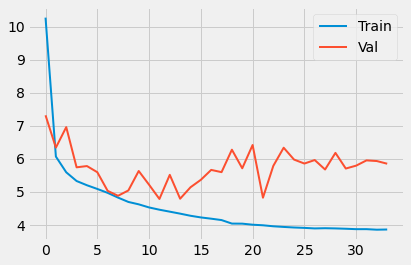

In [54]:
plt.plot(history.history['mean_absolute_percentage_error'][0:], label='Train', lw=2)
plt.plot(history.history['val_mean_absolute_percentage_error'][0:], label='Val', lw=2)
plt.legend()